In [ ]:
# Paste this in a single notebook cell and run it.
import sys, os
print("Using python:", sys.executable)

# Use the notebook's interpreter to uninstall then reinstall cleanly.
# This cell uninstalls transformers/token libs then reinstalls a clean set.
# It may take a few minutes depending on network.

print("\n==> Upgrading pip / build tools")
!{sys.executable} -m pip install -U pip setuptools wheel

print("\n==> Uninstalling possible conflicting packages (if present)")
!{sys.executable} -m pip uninstall -y transformers tokenizers tiktoken sentencepiece huggingface-hub accelerate safetensors datasets || true

print("\n==> Reinstalling compatible package set")
!{sys.executable} -m pip install -U "transformers[torch]" tokenizers tiktoken sentencepiece huggingface-hub datasets accelerate safetensors tqdm scikit-learn

print("\n==> Clearing HuggingFace cache (so corrupted tokenizer files are removed).")
# Be conservative: only clear transformers/hub caches if they exist.
home = os.path.expanduser("~")
hf_transformers_cache = os.path.join(home, ".cache", "huggingface", "transformers")
hf_hub_cache = os.path.join(home, ".cache", "huggingface", "hub")
for p in (hf_transformers_cache, hf_hub_cache):
    if os.path.exists(p):
        print("Removing cache:", p)
        !rm -rf "{p}"
    else:
        print("No cache found at:", p)

print("\n==> DONE. Please restart the kernel (Kernel -> Restart) if your environment supports it.")


# EM-Refinement

EM = Expectation Maximization

This phase is a "One-time", offline, self-supervised training loop that learns all the specialised neural components used by the online CoCaD pipeline. It proceeds in 3 main steps:
- Synthetic "gold data" generation
- bootstrap pre-training of all modules
- EM-style refinement loop on real-documentss

Expectation - Maximisation

EM is an iterative algorithm used when your model depends on hidden / missing / unobserved variables.

It solves problems where you can’t maximize the likelihood directly, because some parts of the data or structure are unknown.

EM alternates between two conceptual steps:

1. E-Step (Expectation Step):

Estimate the missing / hidden variables using the current model parameters. Here we initially assume your current parameters are correct. Using those parameters, you compute the expected values of hidden variables.
This kinda gives a soft-guess of the hidden structure.

2. M-Step (Maximisation Step):

Update the model parameters to best fit the “completed data” (observed + estimated) from the E-step. Using the completed dataset from the E-step. Given these expected hidden values, what parameters maximize the likelihood?
In the M-step, we choose the parameters that maximize the likelihood of the completed data.

We repeat the $ E-Step \rightarrow M-Step \rightarrow E-Step$.. Each iteration increases the likelihood or keeps it the same. We stop when parameters stop changing (aka convergence)

Popular example of EM model: GMM (Gaussian mixture model).

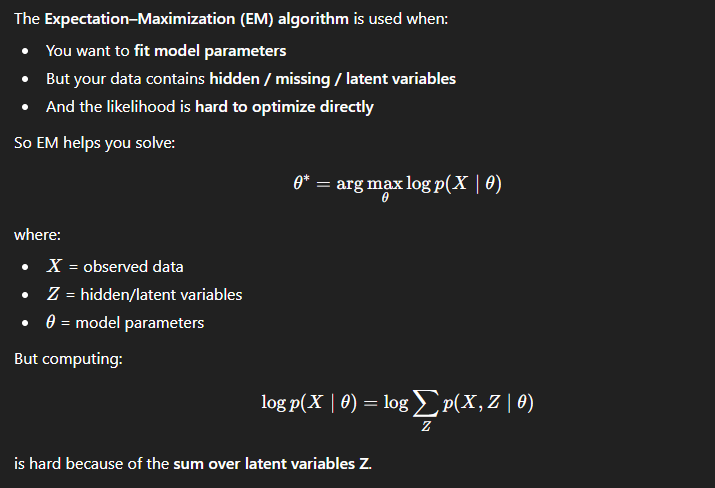

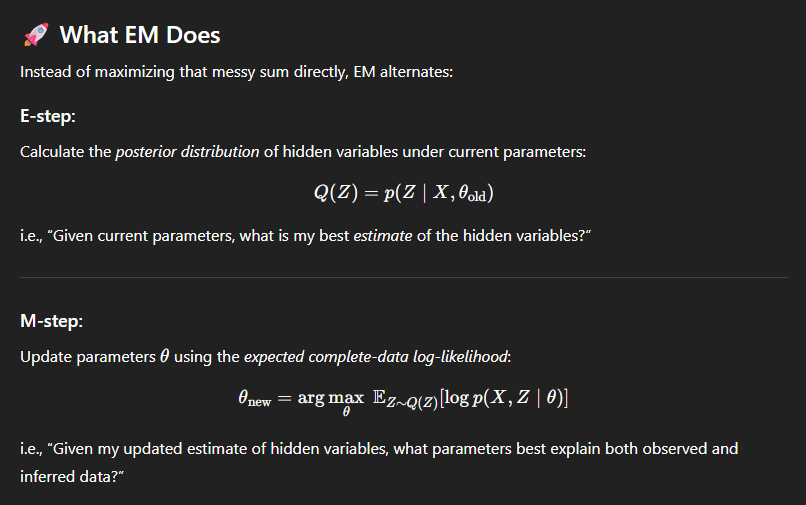

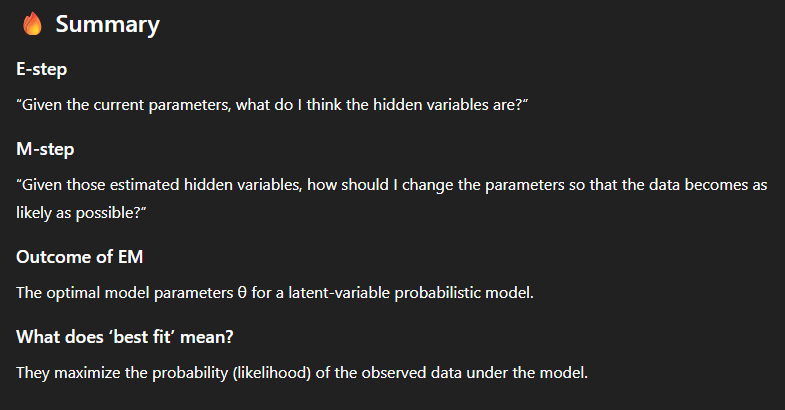

Motivation behind EM-Refinement:

The full CoCaD pipeline uses LLMs heavily during construction:
- To judge causal strength
- To check confounders
- To do CoT reasoning
- To compute semantic coherence
- To generate W_direct(i,j)

But LLM calls are expensive, slow, rate-limited, and inconsistent. We cannot depend on a huge LLM during inference time. The whole pipeline must eventually run fast, locally, and consistently when deployed.

So EM-refinement is all because at inference time you didnt want to use LLM for this cocad part..

Goal of EM-Refinement: 
- Train fast surrogate models that imitate the LLM for our current context. 
- Distill (compress) LLM behaviour into small learnable models (All the signals LLM generated earlier line R_coh, mu etc) all get bundled into a single feature vector $v_{ij}$. Then EM-refinement trains a neural model $f_{fusion}$ such that $W_{direct}(i,j) = f_{fusion}(v_{ij})$. \
No this $f_{fusion}$ learns LLM-like decision boundaries, but becomes cheap, deterministic, fast, deployable with LLM.
- Produce a relaible, stable $C_{prior}$ for training CausGT-HS: \
CausGT-HS (the final causal EBM) needs target labels. But raw LLM outputs as earlier are Noisy, contradiatory, Hard to trust. So EM-refinement uses Expectation-Maximization to refine teacher/student models. Produces a cleaned, calibrated, LLM-free $C_{prior}$ matrix. That us used as the answer key to train our final causal graph transformer.

- Without EM-refinement every step requires dozens of LLM CoT queries. Its ofcourse slow, expensive,, not practical for real-time or batch-scale causal reasoning. 

Teacher = LLM

Student = The small NN do whom we are distilling our LLM knowledge to (it operates on our $v_{ij}$)...

So the EM phase distills the LLM + statistical reasoning into a cheap prediction model.

Hence EM is an iterative process where:

- Teacher computes pseudo-labels (E-step)

- Student learns the mapping (M-step)

This allows CoCaD to run fast, without LLMs, at inference.

Teacher produces the “gold standard” causal edges using all expensive signals.

Student learns to approximate those edges cheaply.

- EM produces reliable, fast models (fusion, LPA, CPC, f_embed, f_student) and a stable C_prior (answer key) that the CausGT-HS energy-based model uses as supervision.

## (a). Synthetic Corpus and Ground-Truth Dataset Generation:

1. Generation of the Ground-Truth Causal Graph $G_{true}$
2. Generation of the Synthetic Text Corpus $D_{corpus}$
3. Generation of the Fully Labeled Dataset $D_{synth}$

### (1). Generation of the Ground-Truth Causal Graph $G_{true}$

In [ ]:
import random
import math
from typing import Dict, Tuple, List, Any, Union, Set
import numpy as np
import networkx as nx

# --------------------------
# Seed & RNG utilities
# --------------------------

def _normalize_seed(seed: Union[int, random.Random, np.random.Generator, None]) -> int:
    if seed is None:
        return 0
    if isinstance(seed, random.Random):
        return seed.randint(0, 2**32 - 1)
    try:
        return int(seed) % (2**32)
    except Exception:
        return 0

def _py_random_for_seed(seed: Union[int, random.Random, None]) -> random.Random:
    if isinstance(seed, random.Random):
        return seed
    return random.Random(_normalize_seed(seed))

def seeded_rng(seed: int):
    base = _normalize_seed(seed)
    return random.Random(base), np.random.default_rng(base)

# --------------------------
# Topology samplers
# --------------------------

def sample_scale_free_subgraph(n: int, avg_deg: int, rnd_seed: Union[int, random.Random]) -> nx.DiGraph:
    m = max(1, int(max(1, round(avg_deg / 2.0))))
    py_rng = _py_random_for_seed(rnd_seed)
    G = nx.barabasi_albert_graph(n, m, seed=py_rng)
    D = nx.DiGraph()
    D.add_nodes_from(range(n))
    base = _normalize_seed(rnd_seed)
    for (u, v) in G.edges():
        edge_seed = (base + (u + 1) * 1315423911 + (v + 1) * 2654435761) & 0xFFFFFFFF
        if random.Random(edge_seed).random() < 0.5:
            D.add_edge(u, v)
        else:
            D.add_edge(v, u)
    return D

def sample_small_world_subgraph(n: int, avg_deg: int, rnd_seed: Union[int, random.Random]) -> nx.DiGraph:
    k = int(avg_deg if avg_deg % 2 == 0 else avg_deg + 1)
    k = min(k, max(2, n - 1))
    p = 0.1
    py_rng = _py_random_for_seed(rnd_seed)
    G = nx.watts_strogatz_graph(n, k, p, seed=py_rng)
    D = nx.DiGraph()
    D.add_nodes_from(range(n))
    base = _normalize_seed(rnd_seed)
    for (u, v) in G.edges():
        edge_seed = (base + (u + 1) * 1140071481 + (v + 1) * 704602925) & 0xFFFFFFFF
        if random.Random(edge_seed).random() < 0.5:
            D.add_edge(u, v)
        else:
            D.add_edge(v, u)
    return D

def sample_sbm_subgraph(n: int, num_communities: int, avg_deg: int, rnd_seed: Union[int, random.Random]) -> nx.DiGraph:
    base = _normalize_seed(rnd_seed)
    base_size = n // num_communities
    sizes = [base_size] * num_communities
    remainder = n - base_size * num_communities
    for i in range(remainder):
        sizes[i] += 1
    p_in = min(0.6, (avg_deg / max(1.0, (n / num_communities))) * 0.6)
    p_out = max(0.01, (avg_deg / max(1.0, n)) * 0.6)
    probs = [[p_in if i == j else p_out for j in range(num_communities)] for i in range(num_communities)]
    py_rng = _py_random_for_seed(rnd_seed)
    G = nx.stochastic_block_model(sizes, probs, seed=py_rng)
    D = nx.DiGraph()
    D.add_nodes_from(range(n))
    for (u, v) in G.edges():
        if u == v: continue
        edge_seed = (base + (u + 1) * 73428767 + (v + 1) * 2654435761) & 0xFFFFFFFF
        if random.Random(edge_seed).random() < 0.5:
            D.add_edge(u, v)
        else:
            D.add_edge(v, u)
    return D

# --------------------------
# Mechanism assignment
# --------------------------

def assign_mechanism_params(parents: List[int], mech_type: str, np_rng: np.random.Generator):
    if mech_type == "linear":
        coeffs = (np_rng.normal(loc=0.5, scale=0.5, size=(len(parents),))).tolist()
        bias = float(np_rng.normal(scale=0.1))
        return {"type": "linear", "coeffs": coeffs, "bias": bias}
    elif mech_type == "mlp":
        hidden_dim = max(4, min(32, 2 * len(parents) + 4))
        return {"type": "mlp", "hidden_dim": hidden_dim}
    else:  # saturating
        coeffs = (np_rng.normal(loc=0.7, scale=0.3, size=(len(parents),))).tolist()
        bias = float(np_rng.normal(scale=0.05))
        return {"type": "saturating", "coeffs": coeffs, "bias": bias}

# --------------------------
# Plant motifs utilities - FIXED
# --------------------------

def plant_direct_edge(G: nx.DiGraph, u: int, v: int, motif_tags: Dict[Tuple[int,int], str]):
    if u == v: return
    G.add_edge(u, v)
    motif_tags[(u, v)] = motif_tags.get((u, v), "") + "direct;"

def plant_mediator_chain(
    G: nx.DiGraph,
    u: int,
    v: int,
    mediators: List[int],
    motif_tags: Dict[Tuple[int,int], str],
):
    """
    Plant chain: u -> m1 -> m2 -> ... -> mk -> v
    """
    prev = u
    for m in mediators:
        if prev == m: continue
        G.add_edge(prev, m)
        motif_tags[(prev, m)] = motif_tags.get((prev, m), "") + "med_chain;"
        prev = m
    
    if prev != v:
        G.add_edge(prev, v)
        motif_tags[(prev, v)] = motif_tags.get((prev, v), "") + "med_chain_end;"

    if not G.has_edge(u, v):
        G.add_edge(u, v)

    motif_tags[(u, v)] = motif_tags.get((u, v), "") + "target_mediator_loop;"

def plant_confounder_chains(
    G: nx.DiGraph,
    conf: int,
    u: int,
    v: int,
    path_to_u: List[int],
    path_to_v: List[int],
    motif_tags: Dict[Tuple[int,int], str],
):
    prev = conf
    for n in path_to_u:
        if prev == n: continue
        G.add_edge(prev, n)
        motif_tags[(prev, n)] = motif_tags.get((prev, n), "") + "conf_chain_u;"
        prev = n
    if prev != u:
        G.add_edge(prev, u)
        motif_tags[(prev, u)] = motif_tags.get((prev, u), "") + "conf_chain_u_end;"

    prev = conf
    for n in path_to_v:
        if prev == n: continue
        G.add_edge(prev, n)
        motif_tags[(prev, n)] = motif_tags.get((prev, n), "") + "conf_chain_v;"
        prev = n
    if prev != v:
        G.add_edge(prev, v)
        motif_tags[(prev, v)] = motif_tags.get((prev, v), "") + "conf_chain_v_end;"

def plant_collider_chains(
    G: nx.DiGraph,
    u: int,
    center: int,
    v: int,
    path_u_to_center: List[int],
    path_v_to_center: List[int],
    motif_tags: Dict[Tuple[int,int], str],
):
    # Chain 1: u -> center
    prev = u
    for n in path_u_to_center:
        if prev == n: continue
        G.add_edge(prev, n)
        motif_tags[(prev, n)] = motif_tags.get((prev, n), "") + "coll_chain_u;"
        prev = n
    if prev != center:
        G.add_edge(prev, center)
        motif_tags[(prev, center)] = motif_tags.get((prev, center), "") + "coll_chain_u_end;"

    # Chain 2: v -> center
    prev = v
    for n in path_v_to_center:
        if prev == n: continue
        G.add_edge(prev, n)
        motif_tags[(prev, n)] = motif_tags.get((prev, n), "") + "coll_chain_v;"
        prev = n
    if prev != center:
        G.add_edge(prev, center)
        motif_tags[(prev, center)] = motif_tags.get((prev, center), "") + "coll_chain_v_end;"

def enforce_acyclic_by_ordering(G: nx.DiGraph, rng: random.Random) -> nx.DiGraph:
    nodes = list(G.nodes())
    rng.shuffle(nodes)
    order = {n: i for i, n in enumerate(nodes)}
    to_remove = []
    for u, v in list(G.edges()):
        if order[u] >= order[v]:
            to_remove.append((u, v))
    G.remove_edges_from(to_remove)
    try:
        if not nx.is_directed_acyclic_graph(G):
            cycles = list(nx.simple_cycles(G))
            for cyc in cycles:
                if len(cyc) >= 2:
                    if G.has_edge(cyc[0], cyc[1]):
                        G.remove_edge(cyc[0], cyc[1])
    except ImportError:
        pass
    return G

# --------------------------
# Main generator 
# --------------------------
def generate_ground_truth_graph(
    num_nodes: int = 1000,
    mix_proportions: Dict[str, float] = None,
    avg_deg: int = 4,
    num_communities: int = 5,
    motif_counts: Dict[str, int] = None,
    noise_spec: Dict[str, Any] = None,
    seed: int = 42,
    max_motif_hops: int = 3,
) -> Tuple[nx.DiGraph, Dict[int, Dict[str, Any]], Dict[int, float], Dict[Tuple[int,int], str]]:
    
    if mix_proportions is None:
        mix_proportions = {"scale_free": 0.5, "small_world": 0.3, "sbm": 0.2}
    if motif_counts is None:
        motif_counts = {"direct": int(num_nodes * 0.1), "mediator": int(num_nodes * 0.05),
                        "confounder": int(num_nodes * 0.05), "collider": int(num_nodes * 0.02)}
    if noise_spec is None:
        noise_spec = {"type": "gaussian", "scale": 1.0}

    max_motif_hops = int(max(1, min(int(max_motif_hops), 5)))
    base_seed = _normalize_seed(seed)
    rnd = random.Random(base_seed)
    np_rng = np.random.default_rng(base_seed)

    # 1. Generate Background Topology
    families = list(mix_proportions.keys())
    props = np.array([mix_proportions[k] for k in families], dtype=float)
    props = props / props.sum()
    counts = (props * num_nodes).astype(int)
    leftover = num_nodes - counts.sum()
    for i in range(leftover):
        counts[i % len(counts)] += 1

    G_global = nx.DiGraph()
    offset = 0
    for family, cnt in zip(families, counts):
        if cnt <= 0: continue
        sampler_seed = base_seed + offset
        if family == "scale_free":
            sub = sample_scale_free_subgraph(cnt, avg_deg, rnd_seed=sampler_seed)
        elif family == "small_world":
            sub = sample_small_world_subgraph(cnt, avg_deg, rnd_seed=sampler_seed)
        elif family == "sbm":
            sub = sample_sbm_subgraph(cnt, num_communities, avg_deg, rnd_seed=sampler_seed)
        else:
            sub = sample_scale_free_subgraph(cnt, avg_deg, rnd_seed=sampler_seed)

        mapping = {local: offset + local for local in sub.nodes()}
        sub_relabeled = nx.relabel_nodes(sub, mapping, copy=True)
        G_global = nx.compose(G_global, sub_relabeled)
        offset += cnt

    for u in range(0, num_nodes):
        if u not in G_global: G_global.add_node(u)

    G_global = enforce_acyclic_by_ordering(G_global, rnd)

    G1 = nx.DiGraph()
    for u in G_global.nodes(): G1.add_node(int(u) + 1)
    for u, v in G_global.edges(): G1.add_edge(int(u) + 1, int(v) + 1)

    motif_tags: Dict[Tuple[int,int], str] = {}
    nodes_list = list(G1.nodes())
    def sample_distinct_nodes(exclude: set, k: int):
        pool = [n for n in nodes_list if n not in exclude]
        return rnd.sample(pool, k) if len(pool) >= k else []

    # 2. Plant Motifs
    n_direct = motif_counts.get("direct", 0)
    for _ in range(n_direct):
        u, v = rnd.sample(nodes_list, 2)
        plant_direct_edge(G1, u, v, motif_tags)

    n_med = motif_counts.get("mediator", 0)
    for _ in range(n_med):
        u, v = rnd.sample(nodes_list, 2)
        L = rnd.randint(1, max_motif_hops)
        exclude = {u, v}
        mediators = sample_distinct_nodes(exclude, L)
        if len(mediators) < L:
            mediators = [] if L == 0 else sample_distinct_nodes({u, v}, 1)
        plant_mediator_chain(G1, u, v, mediators, motif_tags)

    n_conf = motif_counts.get("confounder", 0)
    for _ in range(n_conf):
        conf = rnd.choice(nodes_list)
        u, v = rnd.sample([n for n in nodes_list if n != conf], 2)
        len_u = rnd.randint(1, max_motif_hops)
        len_v = rnd.randint(1, max_motif_hops)
        exclude_uv = {conf, u, v}
        path_u = sample_distinct_nodes(exclude_uv, len_u)
        exclude_uv.update(path_u)
        path_v = sample_distinct_nodes(exclude_uv, len_v)
        plant_confounder_chains(G1, conf, u, v, path_u, path_v, motif_tags)

    n_col = motif_counts.get("collider", 0)
    for _ in range(n_col):
        u, center, v = rnd.sample(nodes_list, 3)
        len_u = rnd.randint(1, max_motif_hops)
        len_v = rnd.randint(1, max_motif_hops)
        exclude_base = {u, v, center}
        path_u = sample_distinct_nodes(exclude_base, len_u)
        exclude_base.update(path_u)
        path_v = sample_distinct_nodes(exclude_base, len_v)
        plant_collider_chains(G1, u, center, v, path_u, path_v, motif_tags)

    # Instead of listing ALL cycles (Exponential time), we break them one by one.
    while True:
        try:
            # find_cycle finds just *one* cycle. This is O(V+E)
            cycle = nx.find_cycle(G1, orientation='original')
            # cycle is a list of edges [(u, v), (v, w), ... (z, u)]
            # We remove the last edge in the cycle to break it
            u_rem, v_rem = cycle[-1][:2]
            if G1.has_edge(u_rem, v_rem):
                G1.remove_edge(u_rem, v_rem)
        except nx.NetworkXNoCycle:
            # No more cycles found, we are safe.
            break

    # 3. Mechanisms
    mech_choices = ["linear", "mlp", "saturating"]
    node_mechanisms: Dict[int, Dict[str, Any]] = {}
    node_noise_params: Dict[int, float] = {}
    for node in G1.nodes():
        parents = list(G1.predecessors(node))
        if len(parents) == 0:
            mech = "linear"
        elif len(parents) == 1:
            mech = rnd.choice(["linear", "saturating"])
        else:
            mech = rnd.choice(mech_choices)
        params = assign_mechanism_params(parents, mech, np_rng)
        node_mechanisms[int(node)] = {"mechanism": mech, "params": params, "parents": parents}
        base = float(noise_spec.get("scale", 1.0))
        noise_scale = base * (1.0 + 0.1 * len(parents)) * (0.9 + rnd.random() * 0.2)
        node_noise_params[int(node)] = noise_scale

    return G1, node_mechanisms, node_noise_params, motif_tags
# --------------------------
# Analysis Utils
# --------------------------
def find_all_directed_paths_up_to_k(G: nx.DiGraph, source: int, target: int, max_hops: int) -> List[List[int]]:
    try:
        paths = list(nx.all_simple_paths(G, source=source, target=target, cutoff=max_hops))
    except Exception:
        paths = []
    return paths

def bfs_sources_within_hops(G: nx.DiGraph, target: int, max_hops: int) -> Set[int]:
    Grev = G.reverse(copy=False)
    visited = set([target])
    frontier = {target}
    depth = 0
    sources = set()
    while frontier and depth < max_hops:
        next_front = set()
        for node in frontier:
            for nbr in Grev.neighbors(node):
                if nbr not in visited:
                    visited.add(nbr)
                    next_front.add(nbr)
                    sources.add(nbr)
        frontier = next_front
        depth += 1
    return sources

def bfs_descendants_within_hops(G: nx.DiGraph, source: int, max_hops: int) -> Set[int]:
    visited = set([source])
    frontier = {source}
    depth = 0
    desc = set()
    while frontier and depth < max_hops:
        next_front = set()
        for node in frontier:
            for nbr in G.neighbors(node):
                if nbr not in visited:
                    visited.add(nbr)
                    next_front.add(nbr)
                    desc.add(nbr)
        frontier = next_front
        depth += 1
    return desc

def analyze_pair(G: nx.DiGraph, i: int, j: int, max_hops: int = 5) -> Dict[str, Any]:
    out: Dict[str, Any] = {}
    out["direct_edge"] = G.has_edge(i, j)
    all_paths = find_all_directed_paths_up_to_k(G, i, j, max_hops)
    mediator_paths = [p for p in all_paths if len(p) >= 3]
    mediator_nodes = set()
    for p in mediator_paths:
        mediator_nodes.update(p[1:-1])
    out["mediator_paths"] = mediator_paths
    out["mediator_nodes"] = sorted(mediator_nodes)

    ancestors_i = bfs_sources_within_hops(G, i, max_hops)
    ancestors_j = bfs_sources_within_hops(G, j, max_hops)
    confounders = sorted(list(ancestors_i.intersection(ancestors_j) - {i, j}))
    out["confounders"] = confounders

    desc_i = bfs_descendants_within_hops(G, i, max_hops)
    desc_j = bfs_descendants_within_hops(G, j, max_hops)
    colliders = sorted(list(desc_i.intersection(desc_j) - {i, j}))
    out["colliders"] = colliders

    out["num_all_paths_found"] = len(all_paths)
    out["sample_paths"] = all_paths[:5]
    return out

def analyze_all_pairs(G: nx.DiGraph, pairs: List[Tuple[int,int]], max_hops: int = 5):
    for (i,j) in pairs:
        res = analyze_pair(G, i, j, max_hops=max_hops)
        print(f"\nPair: {i} -> {j}  (max_hops={max_hops})")
        print(f"  Direct edge present? {res['direct_edge']}")
        if res["mediator_paths"]:
            print(f"  Mediator paths found (count={len(res['mediator_paths'])}):")
            for p in res["mediator_paths"]:
                print(f"    path nodes: {p}")
        else:
            print("  Mediator paths: None found (no directed path i -> ... -> j within bound)")

# --------------------------
# Main Execution 
# --------------------------
if __name__ == "__main__":
    print("Generating graph with preserved motifs...")
    G_true, node_mech, node_noise, motif_tags = generate_ground_truth_graph(
        num_nodes=2000,
        motif_counts={"direct": 300, "mediator": 300, "confounder": 200, "collider": 100},
        seed=12345,
        max_motif_hops=4, 
    )

    print(f"Graph generated: {G_true.number_of_nodes()} nodes, {G_true.number_of_edges()} edges")

    
    # 1. Get pairs where we planted a mediator chain AND a direct edge (target_mediator_loop)
    target_pairs = []
    
    # Check the tags dictionary
    for (u, v), tag in motif_tags.items():
        if "target_mediator_loop" in tag:
            target_pairs.append((u, v))
    
    print(f"\nFound {len(target_pairs)} planted mediator loop pairs.")
    
    # Take a sample of 5 of them
    if target_pairs:
        # subset = target_pairs[:5]
        print(f"Analyzing subset of {len(target_pairs)} planted mediator pairs:")
        analyze_all_pairs(G_true, pairs=target_pairs, max_hops=6)
    else:
        print("No mediator loops found in tags. Did you run the updated plant_mediator_chain code?")

$G_{true}$ is a huge synthetic DAG that serves as the “perfect causal universe” used to train CoCaD’s neural modules so they can replace expensive LLM calls.

- Above parent: [$\dots$] means the causal parents of that node.

- $f_i$ are functional causal mechanisms above. Each node gets a function $f_i$ randomly choosen from a family of functions $f_i$: \
$v_i$ = $f_i(\text{parents of i}, n_i)$

Ex: 
- mech: linear \
Means the node follows a linear structural causal model (i.e., the effect of parents is linear). \
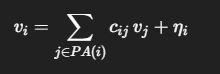 \
Above $c_{ij}$ are random coefficients, $n_i$ is Gaussian noise 

- mech: saturating \
This uses a sigmoid/tanh saturating non-linearity: \
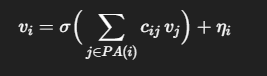 \
This effect is saturating  (has diminishing returns): its like you increase parents the child var increases but beyond a limit the level stops.... (diminishing returns), could be used in economic modelling ig.. 

- mech: mlp \ 
This means the node uses a small neural network (MLP) to compute its value. \
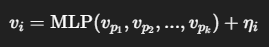 \
This highlights a highly non-linear causal interaction... 

We just generated a synthetic causal graph above. Since we want diverse, realistic causal mechanism so the EM-refinement models learn to detect causal relations like:
- detect linear causation
- detect nonlinear causation
- detect mediated vs confounding structures
- distinguish causal vs non-causal edges

In [ ]:
import networkx as nx
from typing import List, Tuple, Dict

def find_all_simple_paths_limited(G, source, target, max_hops=5):
    """Return all simple paths from source → target with length ≤ max_hops."""
    return [
        p for p in nx.all_simple_paths(G, source=source, target=target, cutoff=max_hops)
    ]


def analyze_pair(G: nx.DiGraph, i: int, j: int, max_hops: int = 5) -> Dict[str, any]:
    """
    Analyze motifs for a given ordered pair (i, j):
      - direct edge?
      - mediators (multi-hop)
      - confounders (multi-hop)
      - colliders (multi-hop)
    """
    results = {}

    # ------------------------------------
    # 1. DIRECT EDGE
    # ------------------------------------
    results["direct"] = G.has_edge(i, j)

    # ------------------------------------
    # 2. MEDIATORS (all nodes in paths i → … → j)
    # ------------------------------------
    paths_ij = find_all_simple_paths_limited(G, i, j, max_hops=max_hops)
    mediator_nodes = set()
    mediator_paths = []

    for p in paths_ij:
        if len(p) > 2:  # at least i → k → j
            internal = p[1:-1]
            mediator_nodes.update(internal)
            mediator_paths.append(p)

    results["mediator_nodes"] = sorted(mediator_nodes)
    results["mediator_paths"] = mediator_paths

    # ------------------------------------
    # 3. CONFOUNDERS (nodes k → … → i  AND k → … → j)
    # ------------------------------------
    confounders = set()
    confounder_paths = []

    for k in G.nodes():
        if k in (i, j):
            continue

        # k→i ?
        paths_k_i = find_all_simple_paths_limited(G, k, i, max_hops=max_hops)

        # k→j ?
        paths_k_j = find_all_simple_paths_limited(G, k, j, max_hops=max_hops)

        if paths_k_i and paths_k_j:
            confounders.add(k)
            confounder_paths.append((k, paths_k_i, paths_k_j))

    results["confounder_nodes"] = sorted(confounders)
    results["confounder_paths"] = confounder_paths

    # ------------------------------------
    # 4. COLLIDERS (patterns i → k ← j including multi-hop i→…→k and j→…→k)
    # ------------------------------------
    colliders = set()
    collider_paths = []

    for k in G.nodes():
        if k in (i, j):
            continue

        # i → ... → k ?
        paths_i_k = find_all_simple_paths_limited(G, i, k, max_hops=max_hops)

        # j → ... → k ?
        paths_j_k = find_all_simple_paths_limited(G, j, k, max_hops=max_hops)

        if paths_i_k and paths_j_k:
            colliders.add(k)
            collider_paths.append((k, paths_i_k, paths_j_k))

    results["collider_nodes"] = sorted(colliders)
    results["collider_paths"] = collider_paths

    return results


def analyze_all_pairs(G: nx.DiGraph, pairs: List[Tuple[int, int]], max_hops: int = 5):
    """
    Prints full structured analysis for every pair (i, j).
    """
    for (i, j) in pairs:
        print("\n" + "="*60)
        print(f"PAIR (i={i}, j={j})  —  structural motif report")
        print("="*60)

        res = analyze_pair(G, i, j, max_hops=max_hops)

        print(f"\nDIRECT EDGE i→j: {res['direct']}")

        print("\n--- MEDIATORS (multi-hop) ---")
        print("Mediator nodes:", res["mediator_nodes"])
        for p in res["mediator_paths"]:
            print("  path:", p)

        print("\n--- CONFOUNDERS k→...→i AND k→...→j ---")
        print("Confounder nodes:", res["confounder_nodes"])
        for (k, p_ki, p_kj) in res["confounder_paths"]:
            print(f"  k={k}")
            print(f"    paths k→i:", p_ki)
            print(f"    paths k→j:", p_kj)

        print("\n--- COLLIDERS i→...→k AND j→...→k ---")
        print("Collider nodes:", res["collider_nodes"])
        for (k, p_ik, p_jk) in res["collider_paths"]:
            print(f"  k={k}")
            print(f"    paths i→k:", p_ik)
            print(f"    paths j→k:", p_jk)

        print("="*60)
        print()


# -------------------------------------------------------
# Example usage on full graph (all edges)
# -------------------------------------------------------
def analyze_full_graph(G: nx.DiGraph, max_hops: int = 5):
    all_pairs = [(u, v) for (u, v) in G.edges()]
    analyze_all_pairs(G, pairs=all_pairs, max_hops=max_hops)


In [ ]:
analyze_full_graph(G_true, max_hops=5)

In [ ]:
pairs_to_check = [(485,609), (1098,517)]
analyze_all_pairs(G_true, pairs=pairs_to_check, max_hops=5)


In [ ]:
print(f" G_true = {type(G_true)}")
print(f" motif_tags = {type(motif_tags)}")

In [ ]:
from pprint import pprint

pprint(motif_tags)

1. The Key-Value Structure:

Key (u, v): Represents a directed edge from Node u to Node v.

Value 'string;': A tag describing the structural motif that created this edge.

A. Mediator Chains (The "Chain Reaction"):

These edges build a path like $u \to m_1 \to m_2 \to v$.

- (2, 105): 'med_chain;

'Meaning: This is the start (or middle) of a mediator chain.

Interpretation: Node 2 causes Node 105. Node 105 is likely a Mediator.

- (9, 1732): 'med_chain_end;

'Meaning: This is the final link in a mediator chain.

Interpretation: Node 9 (a mediator) causes Node 1732 (the final target).

- (2, 1488): 'target_mediator_loop;

'Meaning: This is the "Feed-Forward Loop" we fixed!

Interpretation: This is a direct edge from 2 to 1488. The tag tells you that in addition to this direct edge, there is also a longer path (via mediators) connecting 2 to 1488. This is the most interesting pair for analysis.

B. Confounders (The "Common Cause"): 

These edges stem from a hidden common cause ($Conf$) affecting two other nodes ($u$ and $v$): $u \leftarrow \dots \leftarrow Conf \to \dots \to v$.

- (13, 921): 'conf_chain_u;

'Meaning: An edge leaving a confounder (or intermediate) heading toward target $u$.

Interpretation: Node 13 is influencing Node 921 as part of a confounding path.

- (3, 1397): 'conf_chain_u_end;

'Meaning: The final edge hitting the first target ($u$).

Interpretation: Node 3 is the immediate parent of Node 1397 in a confounder structure.

- (6, 617): 'conf_chain_v_end;

'Meaning: The final edge hitting the second target ($v$).

Interpretation: Node 6 is the immediate parent of Node 617.

C. Colliders (The "Common Effect"): 

These edges converge on a single node ($Center$): $u \to \dots \to Center \leftarrow \dots \leftarrow v$.

- (4, 255): 'coll_chain_v;'

Meaning: An edge part of the path coming from source $v$ heading toward the collider center.

Interpretation: Node 4 causes Node 255 on the way to a collision.

- (5, 1955): 'coll_chain_v_end;'

Meaning: The final edge hitting the Collider Center.

Interpretation: Node 5 is a parent of Node 1955. Node 1955 is the Collider (the node where two paths collide).

D. Direct Edges(6, 279): 

'direct;

'Meaning: A simple random edge added to add density to the graph.

Interpretation: Node 6 causes Node 279, but it wasn't planted as part of a complex 3-node or 4-node pattern.

### (2). Generation of the Synthetic Text Corpus $D_{corpus}$

Convert the synthetic ground-truth causal graph (G_true) into a synthetic text dataset that LOOKS LIKE real-world documents describing those causal relations.

To mimic real-world corpora, the text is diversified across domains and enriched
with realistic noise.

Here we generate dataset coherent with our causal relations in our $G_{true}$. Okk great for this we do the following:

- Domain-conditioned generation (one G_true per domain + mixed-domain graphs).
- Contrastive snippet generation (hard negatives)
- Generator–LLM-critic loop with model rotation & retries
 Critic: Its a discriminator model which evaluates whether a generated snippet faithfully reflects its intended causal structure. If the score fails below a threshold, the snippet is regenerated... \
Critic number is a number that represents how strongly and how faithfully the candidate/evidence text supports the causal claim, judged by the model acating as a critic.
- Structured noise augmentation.
- Persistence of JSONL snippet files and metadata.
- Entities saved in your requested rich JSON shape

In [ ]:
## Load the above 
import pickle
import os

def load_final_causal_map(base_path="extracted_output/cocad/w_direct"):
    """
    Loads final_causal_map from pickle file.
    """
    load_path = os.path.join(base_path, "final_causal_map.pkl")

    if not os.path.exists(load_path):
        raise FileNotFoundError(f"No file found at: {load_path}")

    with open(load_path, "rb") as f:
        data = pickle.load(f)

    print(f"[LOAD] final_causal_map loaded ← {load_path}")
    return data

pairwise_structural_context_retrieval = load_final_causal_map()

In [ ]:
from pprint import pprint

pprint(pairwise_structural_context_retrieval)

In [ ]:
print(len(pairwise_structural_context_retrieval))

In [ ]:
from __future__ import annotations
import json
import random
import time
import uuid
from typing import Dict, List, Tuple, Optional, Any
from pathlib import Path


try:
    import google.generativeai as genai
except Exception as e:
    raise ImportError("Required Gemini client 'google.generativeai' not installed or importable.") from e

from graph_generator import generate_ground_truth_graph  # MUST exist in project (Part-1)


DOMAINS = ["finance", "politics", "medical"]
MODEL_CANDIDATES = [
    "gemini-2.5-flash-lite",
    "gemini-2.5-flash",
    "gemini-2.0-flash-lite",
]
MAX_LLM_ATTEMPTS_PER_MODEL = 2        
LLM_DELAY = 15.0                      # seconds per user request
CRITIC_THRESHOLD = 0.75
OUT_DIR = Path("d_corpus_output")
OUT_DIR.mkdir(exist_ok=True, parents=True)

# Deterministic sampling seeds
GLOBAL_SEED = 20251127
RNG = random.Random(GLOBAL_SEED)

# Sampling sizes 
SAMPLES_PER_DOMAIN = 400   # total record count per domain corpus 
SAMPLES_MIXED = 1200       # mixed corpus size
MAX_PATH_CUTOFF = 4        # max hops when enumerating mediator paths
MAX_REGEN = 3              # regeneration attempts per positive snippet

# ---------------------------
# Utilities
# ---------------------------
def safe_id(prefix: str = "doc") -> str:
    return f"{prefix}_{uuid.uuid4().hex[:8]}"

def node_identifier(node_int: int) -> str:
    return f"N{node_int}"

# ---------------------------
# Gemini strict wrapper 
# ---------------------------
class GeminiClientStrict:
    """
    Strict Gemini wrapper:
     - tries MODEL_CANDIDATES in given order
     - sleeps LLM_DELAY before each call
     - retries each model up to MAX_LLM_ATTEMPTS_PER_MODEL times
     - raises RuntimeError if all models / attempts fail for a call
    """
    def __init__(self,
                 models: List[str],
                 attempts_per_model: int,
                 llm_delay: float):
        if not models:
            raise ValueError("No Gemini models provided.")
        self.models = models
        self.attempts_per_model = attempts_per_model
        self.llm_delay = llm_delay

    def _sleep(self):
        time.sleep(self.llm_delay)

    def _call_model_once(self, model: str, prompt: str, temperature: float, max_tokens: int) -> Optional[str]:
        """Single-model try loop with attempts_per_model retries."""
        for attempt in range(1, self.attempts_per_model + 1):
            self._sleep()
            try:
                # Deterministic SDK call shape 
                response = genai.generate_text(model=model, prompt=prompt, temperature=temperature, max_output_tokens=max_tokens)
                if response is None:
                    continue
                # Extract candidate content robustly
                if isinstance(response, dict):
                    cands = response.get("candidates")
                    if isinstance(cands, list) and cands:
                        content = cands[0].get("content")
                        if content:
                            return str(content).strip()
                else:
                    cands = getattr(response, "candidates", None)
                    if isinstance(cands, list) and cands:
                        first = cands[0]
                        if isinstance(first, dict):
                            content = first.get("content")
                        else:
                            content = getattr(first, "content", None)
                        if content:
                            return str(content).strip()
            except Exception:
                # deterministic backoff
                time.sleep(0.5 * attempt)
                continue
        return None

    def generate_text(self, prompt: str, temperature: float = 0.0, max_tokens: int = 256) -> str:
        """Try all models; return first successful text; raise if none succeed."""
        for model in self.models:
            out = self._call_model_once(model, prompt, temperature, max_tokens)
            if out is not None:
                return out
        # explicit failure
        raise RuntimeError("All Gemini models exhausted for generate_text. Check credentials / availability.")

    def critique_snippet(self, snippet: str, intended_structure_desc: str, max_tokens: int = 128) -> float:
        """
        Ask Gemini to return a JSON with {"score":<0.0-1.0>,"reason":"..."}.
        Returns numeric score 0..1 or raises on failure.
        """
        prompt = (
            "You are a rigorous evaluator. Given an intended causal structure description and a candidate snippet, "
            "return ONLY valid JSON with fields: {\"score\": <float between 0.0 and 1.0>, \"reason\": <short string>}.\n\n"
            f"INTENDED: {intended_structure_desc}\n\n"
            f"SNIPPET: {snippet}\n\n"
            "Return JSON only, no extra commentary."
        )
        raw = self.generate_text(prompt, temperature=0.0, max_tokens=max_tokens)
        # parse first {...} block
        start = raw.find("{")
        end = raw.rfind("}")
        if start == -1 or end == -1 or end <= start:
            raise RuntimeError("Critic returned unparsable output: " + (raw[:200] if raw else "<empty>"))
        jtxt = raw[start:end+1]
        try:
            jj = json.loads(jtxt)
            score = float(jj.get("score", 0.0))
            return max(0.0, min(1.0, score))
        except Exception as e:
            raise RuntimeError("Critic JSON parse failed: " + str(e) + " raw: " + raw[:200])

# ---------------------------
# Noise augmentation utilities 
# ---------------------------
def apply_noise(snippet: str, domain: str, rng: random.Random) -> Tuple[str, Dict[str,Any]]:
    """
    Apply structured noise deterministically using provided rng.
    Noise types:
      - hedging insertion (low probability)
      - mild typo (character swap) but avoid entity tokens like 'N\d+' and entity names (we don't mangled structured entities)
      - register shift phrases (prepend or append)
    Returns (noisy_snippet, noise_meta)
    """
    noise_meta = {"hedge": False, "typo": False, "register_shift": False}

    s = snippet

    # 1) Hedging (10% chance)
    if rng.random() < 0.10:
        hedges = ["may", "might", "could", "appears to", "is likely to"]
        hedge = rng.choice(hedges)
        # insert hedge after first verb-ish position: naive insert after first space
        parts = s.split(" ", 1)
        if len(parts) == 2:
            s = f"{parts[0]} {hedge} {parts[1]}"
        else:
            s = f"{hedge} {s}"
        noise_meta["hedge"] = True

    # 2) Typo (5% chance) 
    if rng.random() < 0.05:
        # choose a position to mangle that is not within uppercase tokens
        chars = list(s)
        npos = rng.randint(0, max(0, len(chars)-2))
        # avoid positions inside uppercase sequences: check neighbor chars
        if not (chars[npos].isupper() and (npos == 0 or chars[npos-1] == ' ')):
            # swap with next char
            chars[npos], chars[npos+1] = chars[npos+1], chars[npos]
            s = "".join(chars)
            noise_meta["typo"] = True

    # 3) Register shift (15% chance): prepend domain-appropriate phrase
    if rng.random() < 0.15:
        if domain == "medical":
            pre = rng.choice(["Clinical note:", "Case report:", "Observationally,"])
        elif domain == "finance":
            pre = rng.choice(["Market note:", "In recent filings,", "Analysts note:"])
        else:
            pre = rng.choice(["Policy brief:", "Official release:", "Observers say:"])
        s = f"{pre} {s}"
        noise_meta["register_shift"] = True

    return s, noise_meta

# ---------------------------
# Domain-conditioned prompt templates for motifs 
# ---------------------------
def prompt_for_motif_direct(names: List[str], domain: str) -> str:
    a, b = names[0], names[1]
    if domain == "medical":
        return f"Write a clinical note (one sentence) explaining that {a} directly affects {b}. Return only the sentence."
    if domain == "finance":
        return f"Write a concise financial sentence (one sentence) describing how {a} directly causes changes in {b}. Return only the sentence."
    # politics
    return f"Write one sentence in a political reporting style stating that {a} directly influences {b}. Return only the sentence."

def prompt_for_motif_mediator(names: List[str], domain: str) -> str:
    # names length >=3
    if domain == "medical":
        return f"Write a clinical note (one sentence) explaining that {names[0]} affects {names[-1]} by altering {' then '.join(names[1:-1])}. Return only the sentence."
    if domain == "finance":
        return f"Write one sentence describing that {names[0]} influences {names[-1]} via intermediary {' then '.join(names[1:-1])} in a market context. Return only the sentence."
    return f"Write one sentence stating that {names[0]} affects {names[-1]} through {' then '.join(names[1:-1])} in a political context. Return only the sentence."

def prompt_for_motif_confounder(names: List[str], domain: str) -> str:
    if len(names) < 3:
        # fallback style
        return prompt_for_motif_direct(names, domain)
    conf = names[1]
    return f"Write one sentence that indicates a shared factor {conf} causes both {names[0]} and {names[-1]}, explaining their association. Return only the sentence."

def prompt_for_motif_collider(names: List[str], domain: str) -> str:
    return f"Write one sentence explaining that {names[0]} and {names[-1]} both affect {names[1]} (a collider), producing the observed association. Return only the sentence."

# ---------------------------
# Core D_corpus generator class 
# ---------------------------
class DCorpusSpecGenerator:
    def __init__(self,
                 gemini: GeminiClientStrict,
                 domains: List[str],
                 out_dir: Path,
                 rng_seed: int = GLOBAL_SEED):
        self.gemini = gemini
        self.domains = list(domains)
        self.out_dir = out_dir
        self.rng = random.Random(rng_seed)
        self.node_entities: Dict[str, Dict[int, Dict[str,Any]]] = {}
        self.node_domain_maps: Dict[str, Dict[int, str]] = {}

    # create domain-specific views (all nodes assigned same domain)
    def create_domain_graph_copies(self, G_true) -> Dict[str, Dict]:
        out = {}
        for d in self.domains:
            out[d] = {"G": G_true,
                      "node_domain_map": {int(n): d for n in G_true.nodes()},
                      "graph_id": f"G_domain_{d}"}
        return out

    # mixed domain graph view
    def create_mixed_domain_graph(self, G_true, seed: int = 1234) -> Dict:
        rnd = random.Random(seed)
        node_domain_map = {int(n): rnd.choice(self.domains) for n in G_true.nodes()}
        return {"G": G_true, "node_domain_map": node_domain_map, "graph_id": f"G_mixed_{seed}"}

    # ensure structured entity metadata per node (LLM only)
    def ensure_node_entities(self, graph_id: str, G, node_domain_map: Dict[int,str]):
        if graph_id not in self.node_entities:
            self.node_entities[graph_id] = {}
            self.node_domain_maps[graph_id] = {}

        for node in G.nodes():
            n = int(node)
            if n in self.node_entities[graph_id]:
                continue
            domain = node_domain_map.get(n, self.rng.choice(self.domains))
            self.node_domain_maps[graph_id][n] = domain

            # deterministic prompts for name and description
            # Name: 1-4 words, no punctuation
            name_prompt = f"Provide a concise 1-4 word entity name appropriate for domain '{domain}'. This is node id {n}. Return the name only."
            name = self.gemini.generate_text(name_prompt, temperature=0.0, max_tokens=12)

            # Description: 1-2 sentence factual-sounding description
            desc_prompt = f"Write a 1-2 sentence factual-sounding description for the entity named '{name}' in domain '{domain}'. Return description only."
            description = self.gemini.generate_text(desc_prompt, temperature=0.2, max_tokens=140)

            entity = {
                "id": node_identifier(n),
                "name": name,
                "type": "entity",
                "time": None,
                "location": None,
                "description": description,
                "source_chunks": [0],
            }
            self.node_entities[graph_id][n] = entity

    # choose motif-specific prompt
    def motif_prompt(self, motif_type: str, names: List[str], domain: str, positive_snippet: Optional[str] = None) -> str:
        if motif_type == "direct":
            return prompt_for_motif_direct(names, domain)
        if motif_type == "mediator":
            return prompt_for_motif_mediator(names, domain)
        if motif_type == "confounder":
            return prompt_for_motif_confounder(names, domain)
        if motif_type == "collider":
            return prompt_for_motif_collider(names, domain)
        # fallback strict (shouldn't occur)
        return prompt_for_motif_direct(names, domain)

    # determine motif type heuristically from path & G
    def determine_motif_type(self, G, path: List[int]) -> str:
        if len(path) == 2:
            return "direct"
        # path length >=3 -> mediator chain
        return "mediator"

    # generate positive snippet with motif-conditioned prompt + critic loop + noise augmentation
    def generate_positive_and_validate(self, graph_id: str, G, path: List[int], domain: str) -> Dict[str,Any]:
        names = [ self.node_entities[graph_id][int(n)]["name"] for n in path ]
        motif = self.determine_motif_type(G, path)
        intended_structure_desc = f"Path {' -> '.join(names)} is a causal relation from {names[0]} to {names[-1]} in domain {domain}."
        best = None
        best_score = -1.0
        attempts_meta = []
        for attempt in range(1, MAX_REGEN + 1):
            # build prompt
            prompt = self.motif_prompt(motif, names, domain)
            snippet = self.gemini.generate_text(prompt, temperature=0.25, max_tokens=160)
            # critic
            score = self.gemini.critique_snippet(snippet, intended_structure_desc, max_tokens=128)
            attempts_meta.append({"attempt": attempt, "model_try": MODEL_CANDIDATES, "prompt": prompt, "raw_snippet": snippet, "critic_score": score})
            if score >= CRITIC_THRESHOLD:
                best = {"snippet": snippet, "meta": {"intended_structure": intended_structure_desc, "motif": motif}, "score": score, "attempts_meta": attempts_meta}
                best_score = score
                break
            if score > best_score:
                best = {"snippet": snippet, "meta": {"intended_structure": intended_structure_desc, "motif": motif}, "score": score, "attempts_meta": attempts_meta}
                best_score = score
            # else retry
        if best is None:
            raise RuntimeError("Failed to produce any positive snippet (unexpected).")
        # structured noise augmentation (deterministic branch using RNG seeded per snippet)
        # a deterministic RNG seed per record for reproducible noise decisions
        noise_seed = abs(hash((graph_id, tuple(path), best["snippet"]))) % (2**32)
        noise_rng = random.Random(noise_seed)
        noisy_snippet, noise_meta = apply_noise(best["snippet"], domain, noise_rng)
        best["noisy_snippet"] = noisy_snippet
        best["noise_meta"] = noise_meta
        return best

    # generate contrastive negative using LLM & critic (we want low critic score ideally)
    def generate_contrastive(self, graph_id: str, best_positive: Dict[str,Any], path: List[int], domain: str) -> Dict[str,Any]:
        names = [ self.node_entities[graph_id][int(n)]["name"] for n in path ]
        # prompt LLM to create contrastive negative
        prompt = (
            f"Create a contrastive hard-negative sentence that is semantically close but structurally incorrect relative to the intended relation.\n"
            f"INTENDED PATH: {' -> '.join(names)} (domain={domain})\n"
            f"Original: {best_positive['snippet'] if 'snippet' in best_positive else best_positive['noisy_snippet']}\n"
            "Return only the contrastive sentence."
        )
        neg_snip = self.gemini.generate_text(prompt, temperature=0.35, max_tokens=140)
        neg_score = self.gemini.critique_snippet(neg_snip, best_positive["meta"]["intended_structure"], max_tokens=128)
        # noise augmentation for negative as well 
        noise_seed = abs(hash((graph_id, tuple(path), neg_snip))) % (2**32)
        noise_rng = random.Random(noise_seed)
        noisy_neg, noise_meta = apply_noise(neg_snip, domain, noise_rng)
        return {"neg_snippet": noisy_neg, "neg_meta": {"llm_prompt": prompt, "orig": neg_snip, "noise_meta": noise_meta}, "neg_score": neg_score}

    # build corpus for a single graph view
    def build_corpus_for_graph(self, graph_view: Dict[str,Any], out_dir: Path, samples: int):
        G = graph_view["G"]
        node_domain_map = graph_view["node_domain_map"]
        graph_id = graph_view.get("graph_id", f"G_{int(time.time())}")

        # ensure entities
        self.ensure_node_entities(graph_id, G, node_domain_map)

        # collect candidate paths: direct edges + k-hop simple paths
        import networkx as nx
        direct_pairs = [(int(u), int(v)) for (u,v) in G.edges()]
        # deterministic shuffle
        rng_local = random.Random(GLOBAL_SEED ^ hash(graph_id))
        rng_local.shuffle(direct_pairs)

        # sample direct and mediator paths up to samples
        selected_paths: List[List[int]] = []

        # take up to half from direct edges
        direct_take = min(len(direct_pairs), samples // 2)
        selected_paths.extend([[u,v] for (u,v) in direct_pairs[:direct_take]])

        # find mediator paths
        nodes = list(G.nodes())
        mediator_paths = []
        # deterministic sampling for path candidates
        attempts = 0
        max_attempts = samples * 10
        while len(mediator_paths) < (samples - direct_take) and attempts < max_attempts:
            attempts += 1
            u = rng_local.choice(nodes)
            v = rng_local.choice(nodes)
            if u == v: continue
            try:
                paths = list(nx.all_simple_paths(G, source=u, target=v, cutoff=MAX_PATH_CUTOFF))
            except Exception:
                paths = []
            if not paths:
                continue
            # prefer longer paths (>=3 nodes)
            chosen = next((p for p in paths if len(p) >= 3), paths[0])
            # ensure uniqueness
            if chosen not in mediator_paths and [chosen[0], chosen[-1]] not in [[p[0], p[-1]] for p in mediator_paths]:
                mediator_paths.append(chosen)
        selected_paths.extend(mediator_paths[:max(0, samples - direct_take)])
        # final trim to requested count
        selected_paths = selected_paths[:samples]

        # create output dir for this graph view
        out_subdir = out_dir / graph_id
        out_subdir.mkdir(parents=True, exist_ok=True)
        out_file = out_subdir / f"D_corpus_{graph_id}.jsonl"

        # write JSONL
        with out_file.open("w", encoding="utf8") as fh:
            for path in selected_paths:
                domain = node_domain_map.get(int(path[0]), self.rng.choice(self.domains))
                # positive + validate + noise
                pos_best = self.generate_positive_and_validate(graph_id, G, path, domain)
                neg = self.generate_contrastive(graph_id, pos_best, path, domain)
                # assemble record
                entities = { self.node_entities[graph_id][int(n)]["id"]: self.node_entities[graph_id][int(n)] for n in path }
                record = {
                    "id_pos": safe_id("pos"),
                    "id_neg": safe_id("neg"),
                    "graph_id": graph_id,
                    "node_pair": [int(path[0]), int(path[-1])],
                    "path": [int(x) for x in path],
                    "domain": domain,
                    "pos_snippet": pos_best["noisy_snippet"],
                    "pos_meta": {
                        "intended_structure": pos_best["meta"]["intended_structure"],
                        "motif": pos_best["meta"]["motif"],
                        "attempts_meta": pos_best["attempts_meta"],
                        "noise_meta": pos_best["noise_meta"]
                    },
                    "pos_score": pos_best["score"],
                    "neg_snippet": neg["neg_snippet"],
                    "neg_meta": neg["neg_meta"],
                    "neg_score": neg["neg_score"],
                    "isdirect": int(len(path) == 2 and G.has_edge(path[0], path[-1])),
                    "trueindirectscore": None,   
                    "entities": entities
                }
                fh.write(json.dumps(record, ensure_ascii=False) + "\n")

        print(f"Wrote D_corpus file: {out_file}  (records={len(selected_paths)})")

    # high-level wrapper to build domain-specific & mixed corpora
    def build_all(self, G_true):
        # domain-specific
        domain_views = self.create_domain_graph_copies(G_true)
        for domain, view in domain_views.items():
            # deterministic sample size per domain
            samples = SAMPLES_PER_DOMAIN
            self.build_corpus_for_graph(view, self.out_dir, samples)

        # mixed-domain
        mixed_view = self.create_mixed_domain_graph(G_true, seed=GLOBAL_SEED ^ 0xDEADBEEF)
        self.build_corpus_for_graph(mixed_view, self.out_dir, SAMPLES_MIXED)

# ---------------------------
# Main runner
# ---------------------------
def main():
    # 1) Generate G_true deterministically using Part-1 generator
    G_true, node_mech, node_noise, motif_tags = generate_ground_truth_graph(
        num_nodes=2000,
        motif_counts={"direct": 300, "mediator": 300, "confounder": 200, "collider": 100},
        seed=12345,
        max_motif_hops=4,
    )

    # 2) Instantiate strict Gemini client
    gemini = GeminiClientStrict(models=MODEL_CANDIDATES, attempts_per_model=MAX_LLM_ATTEMPTS_PER_MODEL, llm_delay=LLM_DELAY)

    # 3) Build corpora deterministically
    generator = DCorpusSpecGenerator(gemini=gemini, domains=DOMAINS, out_dir=OUT_DIR, rng_seed=GLOBAL_SEED)
    generator.build_all(G_true)

    print("D_corpus generation complete. Output directory:", OUT_DIR.resolve())

if __name__ == "__main__":
    main()


### (3). Generation of the Fully Labeled Dataset $D_{synth}$

- $D_{corpus}$ = Generate natural-language documents that describe relations in G_true.
    Below is an example taken from above generated:
    ```
    {
        "path": [12, 47, 88],
        "domain": "medical",

        "pos_snippet": "Protein P53 increases Disease Y by modulating Biomarker X.",
        "neg_snippet": "Disease Y elevates Protein P53 due to patient workload factors.",

        "entities": {
            "N12": {"name": "Protein P53", "description": "A tumor-suppressor protein...", ...},
            "N47": {"name": "Biomarker X", ...},
            "N88": {"name": "Disease Y", ...}
        },

        "pos_score": 0.92,
        "neg_score": 0.11
    }
    ```

    $D_{corpus}$ is just synthetic text. No labels. No features. No causal scores.

- $D_{synth}$ = labeled training data for all models in the pipeline.

Ex:
    D_synth (fusion set):
        ```
        {
            "i": 12,
            "j": 88,
            "v_ij": [0.12, -0.44, 0.91, ...],   // structural + embedding features
            "label_direct": 0.95,               // smoothed (true = 1)
            "label_indirect": 0.00              // no indirect path
        }

        ```

    D_synth (LPA set):
        ```
        {
            "path": [12, 47, 88],
            "path_embedding": [0.45, 0.01, -0.78, ...],
            "true_indirect_score": 0.81        // from SCM simulation do(12)
        }
        ```
    
    D_synth (Embedder triplet):
        ```
        {
            "query": "Protein P53",
            "positive": "Biomarker X contributes to Disease Y",
            "negative": "An unrelated political committee affects trade tariffs"
        }
        ```

In [ ]:
from __future__ import annotations
import json
import math
import os
import pickle
import random
import time
import uuid
from pathlib import Path
from typing import Dict, List, Tuple, Any, Optional

import numpy as np
import networkx as nx

from graph_generator import generate_ground_truth_graph  

# --------------------------------------------------------------------
# Configuration 
# --------------------------------------------------------------------
GLOBAL_SEED = 20251127
random.seed(GLOBAL_SEED)
NP_RNG = np.random.default_rng(GLOBAL_SEED)

DCORPUS_BASE = Path("d_corpus_output")    
PHASE1_SAVE = DCORPUS_BASE / "phase1_ground_truth.pkl"  
OUT_DIR = Path("out/dsynth")
OUT_DIR.mkdir(parents=True, exist_ok=True)

# SCM Monte Carlo settings 
MC_SAMPLES = 128
DELTA = 1e-2
SIGMOID_SCALE = 1.0
EPSILON_SMOOTH = 0.05

EMBED_DIM = 64
MAX_PATH_CUTOFF = 4
NEG_CANDIDATES = 50

# Output files
FUSION_FILE = OUT_DIR / "TrainingSetFusion.jsonl"
LPA_FILE = OUT_DIR / "TrainingSetLPA.jsonl"
PATH_FILE = OUT_DIR / "TrainingSetPath.jsonl"
EMBEDDER_FILE = OUT_DIR / "TrainingSetEmbedder.jsonl"
CPC_FILE = OUT_DIR / "TrainingSetCPC.jsonl"
INDEX_FILE = OUT_DIR / "TrainingSetIndex.jsonl"

# params used in Phase-1 originally
PH1_NUM_NODES = 2000
PH1_MOTIF_COUNTS = {"direct": 300, "mediator": 300, "confounder": 200, "collider": 100}
PH1_SEED = 12345
PH1_MAX_MOTIF_HOPS = 4

# --------------------------------------------------------------------
# Utilities
# --------------------------------------------------------------------
def safe_id(prefix: str = "id") -> str:
    return f"{prefix}_{uuid.uuid4().hex[:12]}"

def sigmoid(x: float) -> float:
    return 1.0 / (1.0 + math.exp(-x))

def clamp01(x: float) -> float:
    return float(max(0.0, min(1.0, x)))

# deterministic text embedding
def deterministic_text_embedding(text: str, dim: int = EMBED_DIM) -> np.ndarray:
    vec = np.zeros(dim, dtype=float)
    h = abs(hash(text)) % (2**32)
    rng = np.random.default_rng(h)
    for i, ch in enumerate(text):
        idx = (ord(ch) + i) % dim
        vec[idx] += (ord(ch) % 97 + 1) * (0.001 + (i % 5) * 0.0001)
    vec += rng.normal(scale=0.01, size=dim)
    norm = np.linalg.norm(vec)
    if norm > 0:
        vec /= norm
    return vec

def cosine_sim(a: np.ndarray, b: np.ndarray) -> float:
    na = np.linalg.norm(a)
    nb = np.linalg.norm(b)
    if na == 0 or nb == 0:
        return 0.0
    return float(np.dot(a, b) / (na * nb))

# --------------------------------------------------------------------
# SCM simulator (Option A: deterministic Monte Carlo)
# --------------------------------------------------------------------
class SCMSimulator:
    def __init__(self, G: nx.DiGraph, node_mech: Dict[int, Dict[str, Any]], node_noise: Dict[int, float], global_seed: int = GLOBAL_SEED):
        self.G = G
        self.node_mech = node_mech
        self.node_noise = node_noise
        if not nx.is_directed_acyclic_graph(G):
            raise RuntimeError("G_true must be a DAG for SCM simulation.")
        self.topo = list(nx.topological_sort(G))
        self.global_seed = global_seed
        self._mlp_weights = {}
        self._prepare_mlp_weights()

    def _prepare_mlp_weights(self):
        for node, info in self.node_mech.items():
            mech = info.get("mechanism")
            if mech == "mlp":
                parents = info.get("parents", [])
                in_dim = max(1, len(parents))
                hidden = int(info["params"].get("hidden_dim", max(4, 2*in_dim + 4)))
                seed = (self.global_seed ^ int(node)) & 0xFFFFFFFF
                rng = np.random.default_rng(seed)
                W1 = rng.normal(loc=0.0, scale=0.5 / max(1.0, math.sqrt(in_dim)), size=(hidden, in_dim))
                b1 = rng.normal(loc=0.0, scale=0.1, size=(hidden,))
                W2 = rng.normal(loc=0.0, scale=0.5 / math.sqrt(hidden), size=(1, hidden))
                b2 = rng.normal(loc=0.0, scale=0.05, size=(1,))
                self._mlp_weights[int(node)] = (W1, b1, W2, b2)

    def _eval_node(self, node: int, parent_vals: np.ndarray, noise: np.ndarray) -> np.ndarray:
        info = self.node_mech[int(node)]
        mech = info["mechanism"]
        params = info["params"]
        if mech == "linear":
            coeffs = np.array(params.get("coeffs", [0.5]*len(parent_vals.T))) if parent_vals.size else np.array([])
            bias = float(params.get("bias", 0.0))
            if parent_vals.size:
                out = parent_vals @ coeffs + bias
            else:
                out = np.full((noise.shape[0],), bias)
            out = out + noise
            return out
        elif mech == "saturating":
            coeffs = np.array(params.get("coeffs", [0.7]*len(parent_vals.T))) if parent_vals.size else np.array([])
            bias = float(params.get("bias", 0.0))
            if parent_vals.size:
                lin = parent_vals @ coeffs + bias
                out = 1.0 / (1.0 + np.exp(-lin))
            else:
                out = 1.0 / (1.0 + np.exp(-bias)) * np.ones((noise.shape[0],))
            out = out + noise
            return out
        else:  # mlp
            W1, b1, W2, b2 = self._mlp_weights[int(node)]
            if parent_vals.ndim == 1:
                parent_vals = parent_vals.reshape(1, -1)
            z1 = parent_vals @ W1.T + b1
            h = np.tanh(z1)
            out = h @ W2.T + b2
            out = out.reshape(-1) + noise
            return out

    def _sample_noise(self, node: int, S: int, rng: np.random.Generator) -> np.ndarray:
        scale = float(self.node_noise.get(int(node), 1.0))
        return rng.normal(loc=0.0, scale=scale, size=(S,))

    def simulate_do(self, intervened: Dict[int, float], samples: int = MC_SAMPLES, rng_seed_offset: int = 0) -> Dict[int, np.ndarray]:
        seed = (self.global_seed ^ rng_seed_offset) & 0xFFFFFFFF
        rng = np.random.default_rng(seed)
        S = samples
        vals: Dict[int, np.ndarray] = {}
        for node in self.topo:
            n = int(node)
            if n in intervened:
                vals[n] = np.full((S,), float(intervened[n]), dtype=float)
        for node in self.topo:
            n = int(node)
            if n in vals:
                continue
            parents = self.node_mech[n].get("parents", [])
            if not parents:
                # no parents: treat parent_vals as zeros or bias-only mapping
                parent_vals = np.zeros((S, 0))
                noise = self._sample_noise(n, S, rng)
                vals[n] = self._eval_node(n, parent_vals, noise)
            else:
                parent_vals = np.stack([vals[int(p)] for p in parents], axis=1)
                noise = self._sample_noise(n, S, rng)
                vals[n] = self._eval_node(n, parent_vals, noise)
        return vals

    def compute_true_indirect_score(self, source: int, target: int, base_value: float = 0.0, delta: float = DELTA, samples: int = MC_SAMPLES) -> float:
        seed_offset = (int(source) * 73856093) ^ (int(target) * 19349663)
        vals_base = self.simulate_do({int(source): base_value}, samples=samples, rng_seed_offset=seed_offset)
        Ej_base = float(np.mean(vals_base[int(target)]))
        vals_delta = self.simulate_do({int(source): base_value + delta}, samples=samples, rng_seed_offset=seed_offset ^ 0xDEADBEEF)
        Ej_delta = float(np.mean(vals_delta[int(target)]))
        derivative = (Ej_delta - Ej_base) / (delta if delta != 0 else 1e-9)
        score = sigmoid(SIGMOID_SCALE * abs(derivative))
        return clamp01(score)

# --------------------------------------------------------------------
# Dsynth generator that reads D_corpus only 
# --------------------------------------------------------------------
class DsynthGeneratorFromDcorpus:
    def __init__(self, dcorpus_base: Path, out_dir: Path):
        self.dcorpus_base = dcorpus_base
        self.out_dir = out_dir
        self.records_by_graph: Dict[str, List[Dict[str,Any]]] = {}
        self._load_d_corpus()
        # load saved Phase-1 ground truth 
        self.G, self.node_mech, self.node_noise, self.motif_tags = self._load_or_regenerate_ground_truth()
        self.scm = SCMSimulator(self.G, self.node_mech, self.node_noise, global_seed=GLOBAL_SEED)
        # precompute entity embeddings for hard-negative sampling
        self.entity_embeddings: Dict[str, np.ndarray] = {}
        self._precompute_entity_embeddings()
        self._open_output_files()

    def _load_d_corpus(self):
        if not self.dcorpus_base.exists():
            raise RuntimeError(f"D_corpus base dir not found: {self.dcorpus_base}")
        for sub in sorted([p for p in self.dcorpus_base.iterdir() if p.is_dir()]):
            graph_id = sub.name
            jsonl_files = list(sub.glob("D_corpus_*.jsonl"))
            if not jsonl_files:
                continue
            file_path = jsonl_files[0]
            recs = []
            with file_path.open("r", encoding="utf8") as fh:
                for line in fh:
                    line = line.strip()
                    if not line:
                        continue
                    rec = json.loads(line)
                    rec.setdefault("graph_id", graph_id)
                    recs.append(rec)
            self.records_by_graph[graph_id] = recs
        if not self.records_by_graph:
            raise RuntimeError(f"No D_corpus records loaded from {self.dcorpus_base}")

    def _load_or_regenerate_ground_truth(self):
        candidates = [PHASE1_SAVE, Path("phase1_ground_truth.pkl"), Path("ground_truth_phase1.pkl")]
        for p in candidates:
            if p.exists():
                with p.open("rb") as fh:
                    data = pickle.load(fh)
                    if isinstance(data, tuple) and len(data) >= 4:
                        G_true, node_mech, node_noise, motif_tags = data[0], data[1], data[2], data[3]
                        print(f"Loaded saved ground-truth from {p}")
                        return G_true, node_mech, node_noise, motif_tags
        print("Warning: phase1_ground_truth not found. Deterministically regenerating G_true using generate_ground_truth_graph(...) with seed=12345.")
        G_true, node_mech, node_noise, motif_tags = generate_ground_truth_graph(
            num_nodes=PH1_NUM_NODES,
            motif_counts=PH1_MOTIF_COUNTS,
            seed=PH1_SEED,
            max_motif_hops=PH1_MAX_MOTIF_HOPS,
            avg_deg=4,
            num_communities=5
        )
        return G_true, node_mech, node_noise, motif_tags

    def _precompute_entity_embeddings(self):
        for graph_id, recs in self.records_by_graph.items():
            for rec in recs:
                ents = rec.get("entities", {})
                for ent_id, ent in ents.items():
                    key = f"{graph_id}::{ent_id}"
                    if key not in self.entity_embeddings:
                        text = (ent.get("name","") + " " + (ent.get("description","") or "")).strip()
                        self.entity_embeddings[key] = deterministic_text_embedding(text)

    def _open_output_files(self):
        self.f_fusion = open(FUSION_FILE, "w", encoding="utf8")
        self.f_lpa = open(LPA_FILE, "w", encoding="utf8")
        self.f_path = open(PATH_FILE, "w", encoding="utf8")
        self.f_embedder = open(EMBEDDER_FILE, "w", encoding="utf8")
        self.f_cpc = open(CPC_FILE, "w", encoding="utf8")
        self.f_index = open(INDEX_FILE, "w", encoding="utf8")

    def _close_output_files(self):
        for fh in [self.f_fusion, self.f_lpa, self.f_path, self.f_embedder, self.f_cpc, self.f_index]:
            try:
                fh.close()
            except Exception:
                pass

    def _extract_structural_features(self, i: int, j: int) -> List[float]:
        indeg_i = self.G.in_degree(i)
        outdeg_i = self.G.out_degree(i)
        indeg_j = self.G.in_degree(j)
        outdeg_j = self.G.out_degree(j)
        try:
            spl = nx.shortest_path_length(self.G, source=i, target=j)
        except Exception:
            spl = -1
        try:
            paths = list(nx.all_simple_paths(self.G, source=i, target=j, cutoff=MAX_PATH_CUTOFF))
            num_paths = len(paths)
            max_path_len = max((len(p) for p in paths), default=0)
        except Exception:
            num_paths = 0
            max_path_len = 0
        anc_i = set(nx.ancestors(self.G, i))
        anc_j = set(nx.ancestors(self.G, j))
        common_anc = len(anc_i & anc_j)
        feat = [float(indeg_i), float(outdeg_i), float(indeg_j), float(outdeg_j),
                float(spl if spl>=0 else 999.0), float(num_paths), float(max_path_len), float(common_anc)]
        return feat

    def _compute_text_embedding_for_pair(self, rec: Dict[str,Any]) -> np.ndarray:
        pos = rec.get("pos_snippet", "")
        entities = rec.get("entities", {})
        names_concat = " ".join([ent.get("name","") for ent in entities.values()])
        txt = f"{pos} {names_concat}"
        return deterministic_text_embedding(txt)

    def _compute_path_embedding(self, graph_id: str, path: List[int]) -> np.ndarray:
        embs = []
        for node in path:
            ent_id = f"N{int(node)}"
            key = f"{graph_id}::{ent_id}"
            emb = self.entity_embeddings.get(key, deterministic_text_embedding(ent_id))
            embs.append(emb)
        if not embs:
            return np.zeros(EMBED_DIM, dtype=float)
        return np.mean(np.stack(embs, axis=0), axis=0)

    def _hard_negative_for_target(self, graph_id: str, target_node: int, exclude_set: set) -> int:
        nodes_all = list(self.G.nodes())
        rng = random.Random(GLOBAL_SEED ^ abs(hash(graph_id)))
        cand_nodes = nodes_all[:]
        rng.shuffle(cand_nodes)
        cand_nodes = [n for n in cand_nodes if n not in exclude_set][:NEG_CANDIDATES]
        target_key = f"{graph_id}::N{int(target_node)}"
        target_emb = self.entity_embeddings.get(target_key, deterministic_text_embedding(str(target_node)))
        best_k = None
        best_sim = -1.0
        for k in cand_nodes:
            if (int(target_node), int(k)) in self.G.edges():
                pass
            key = f"{graph_id}::N{int(k)}"
            emb = self.entity_embeddings.get(key, deterministic_text_embedding(str(k)))
            sim = cosine_sim(target_emb, emb)
            if sim > best_sim:
                best_sim = sim
                best_k = k
        if best_k is None:
            for node in self.G.nodes():
                if node not in exclude_set and node != target_node:
                    best_k = int(node)
                    break
        return int(best_k)

    def generate(self):
        idx_count = 0
        for graph_id, recs in self.records_by_graph.items():
            for rec in recs:
                idx_count += 1
                path = rec.get("path", [])
                if not path or len(path) < 2:
                    continue
                i = int(path[0]); j = int(path[-1])
                is_direct = 1 if self.G.has_edge(i, j) else 0
                y_gold = float(is_direct)
                y_smoothed = y_gold * (1.0 - EPSILON_SMOOTH) + EPSILON_SMOOTH * 0.5
                true_indirect = self.scm.compute_true_indirect_score(source=i, target=j, base_value=0.0, delta=DELTA, samples=MC_SAMPLES)
                structural_feats = self._extract_structural_features(i, j)
                text_emb = self._compute_text_embedding_for_pair(rec)
                pos_score = float(rec.get("pos_score", 1.0))
                neg_score = float(rec.get("neg_score", 0.0) if rec.get("neg_score") is not None else 0.0)
                v_ij = structural_feats + [pos_score, neg_score] + list(text_emb.tolist())
                fusion_record = {
                    "record_id": safe_id("fus"),
                    "graph_id": graph_id,
                    "i": int(i),
                    "j": int(j),
                    "v_ij": v_ij,
                    "label_direct_smoothed": float(y_smoothed),
                    "isdirect_gold": int(is_direct)
                }
                self.f_fusion.write(json.dumps(fusion_record, ensure_ascii=False) + "\n")
                path_emb = self._compute_path_embedding(graph_id, path)
                lpa_record = {
                    "record_id": safe_id("lpa"),
                    "graph_id": graph_id,
                    "path": [int(x) for x in path],
                    "path_embedding": path_emb.tolist(),
                    "true_indirect_score": float(true_indirect)
                }
                self.f_lpa.write(json.dumps(lpa_record, ensure_ascii=False) + "\n")
                excl = set(path)
                k = self._hard_negative_for_target(graph_id, j, exclude_set=excl)
                try:
                    paths_ik = list(nx.all_simple_paths(self.G, source=i, target=k, cutoff=MAX_PATH_CUTOFF))
                except Exception:
                    paths_ik = []
                if paths_ik:
                    neg_path = paths_ik[0]
                else:
                    neg_path = [int(i), int(k)]
                path_record = {
                    "record_id": safe_id("path"),
                    "graph_id": graph_id,
                    "anchor_path": [int(x) for x in path],
                    "positive_path": [int(x) for x in path],
                    "negative_path": [int(x) for x in neg_path]
                }
                self.f_path.write(json.dumps(path_record, ensure_ascii=False) + "\n")
                ent_i = rec.get("entities", {}).get(f"N{int(i)}", {})
                q = ent_i.get("name", str(i))
                pos_text = rec.get("pos_snippet", "")
                neg_text = rec.get("neg_snippet", "")
                embedder_record = {
                    "record_id": safe_id("emb"),
                    "graph_id": graph_id,
                    "query": q,
                    "positive": pos_text,
                    "negative": neg_text
                }
                self.f_embedder.write(json.dumps(embedder_record, ensure_ascii=False) + "\n")
                cpc_record = {
                    "record_id": safe_id("cpc"),
                    "graph_id": graph_id,
                    "i": int(i),
                    "j": int(j),
                    "domain": rec.get("domain", "unknown"),
                    "pos_snippet": pos_text,
                    "neg_snippet": neg_text,
                    "pos_score": float(pos_score),
                    "neg_score": float(neg_score),
                    "label_plausible_pos": int(pos_score >= 0.5),
                    "label_plausible_neg": int(neg_score >= 0.5)
                }
                self.f_cpc.write(json.dumps(cpc_record, ensure_ascii=False) + "\n")
                index_entry = {
                    "index_id": safe_id("idx"),
                    "graph_id": graph_id,
                    "i": int(i),
                    "j": int(j),
                    "fusion_id": fusion_record["record_id"],
                    "lpa_id": lpa_record["record_id"],
                    "path_id": path_record["record_id"],
                    "embedder_id": embedder_record["record_id"],
                    "cpc_id": cpc_record["record_id"]
                }
                self.f_index.write(json.dumps(index_entry, ensure_ascii=False) + "\n")
        self._close_output_files()
        print("Dsynth generation finished. Output files in:", self.out_dir.resolve())

# --------------------------------------------------------------------
# main
# --------------------------------------------------------------------
def main():
    gen = DsynthGeneratorFromDcorpus(dcorpus_base=DCORPUS_BASE, out_dir=OUT_DIR)
    gen.generate()

if __name__ == "__main__":
    main()


## (b). Pre-train Models (Bootstrap)

### i. Train $f_{embed-sota}$ (causality-aware embedder)

In [ ]:
from __future__ import annotations
import json
import math
import os
import random
import shutil
import sys
from dataclasses import dataclass, asdict
from pathlib import Path
from typing import List, Dict, Any, Tuple

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Sampler
from sentence_transformers import SentenceTransformer
from tqdm import tqdm

# ---------------------------
# Configuration 
# ---------------------------
RNG_SEED = 20251127
random.seed(RNG_SEED)
np.random.seed(RNG_SEED)
torch.manual_seed(RNG_SEED)

DATA_PATH = Path("out/dsynth/TrainingSetEmbedder.jsonl")
MODEL_DIR = Path("models/fembed_sota")
LOG_DIR = Path("logs")
MODEL_DIR.mkdir(parents=True, exist_ok=True)
LOG_DIR.mkdir(parents=True, exist_ok=True)

BACKBONE_NAME = "all-MiniLM-L6-v2"   # sentence-transformers model
DBACKBONE = 384                      # all-MiniLM-L6-v2 typical dim
DEMBED = 256                         # target embedding dim after projection head
BATCH_SIZE = 64                      # total batch size 
LR = 2e-5
WEIGHT_DECAY = 1e-6
NUM_EPOCHS = 10
TEMPERATURE = 0.07
GRAD_ACCUM_STEPS = 1
PATIENCE = 3                         # early stopping patience on validation loss
VAL_SPLIT = 0.05                     # fraction of records used for heldout validation
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

MIN_POS_PER_QUERY = 1            

# ---------------------------
# Utilities
# ---------------------------
def write_log(msg: str):
    path = LOG_DIR / "fembed_train.log"
    with open(path, "a", encoding="utf8") as fh:
        fh.write(msg + "\n")
    print(msg)

@dataclass
class HyperParams:
    backbone: str = BACKBONE_NAME
    d_backbone: int = DBACKBONE
    d_embed: int = DEMBED
    batch_size: int = BATCH_SIZE
    lr: float = LR
    weight_decay: float = WEIGHT_DECAY
    epochs: int = NUM_EPOCHS
    temperature: float = TEMPERATURE
    device: str = DEVICE
    val_split: float = VAL_SPLIT

# ---------------------------
# Dataset
# ---------------------------
class EmbedderTripletDataset(Dataset):
    """
    Loads TrainingSetEmbedder JSONL and yields structured examples:
      {
        "query": str,
        "positives": List[str],
        "negatives": List[str],
        "domain": str
      }
    """
    def __init__(self, path: Path):
        if not path.exists():
            raise FileNotFoundError(f"TrainingSetEmbedder not found at {path}. Please run Phase-3 to generate it.")
        self.records = []
        with path.open("r", encoding="utf8") as fh:
            for line in fh:
                rec = json.loads(line)
                # normalize fields
                query = rec.get("query") or rec.get("q") or ""
                pos = rec.get("positive") or rec.get("positives") or rec.get("spos") or []
                neg = rec.get("negative") or rec.get("negatives") or rec.get("sneg") or []
                domain = rec.get("domain") or rec.get("graph_id") or "unknown"
                if isinstance(pos, str):
                    pos = [pos]
                if isinstance(neg, str):
                    neg = [neg]
                if len(pos) == 0:
                    continue
                self.records.append({"query": query, "positives": pos, "negatives": neg, "domain": domain})
        if len(self.records) == 0:
            raise RuntimeError("No records loaded from TrainingSetEmbedder. Aborting.")

    def __len__(self):
        return len(self.records)

    def __getitem__(self, idx):
        return self.records[idx]

# ---------------------------
# Domain-balanced sampler
# ---------------------------
class DomainBalancedBatchSampler(Sampler):
    """
    Produces batches that are domain-balanced.
    Implementation:
      - Group indices by domain
      - For each batch, sample ceil(batch_size / num_domains) indices from each domain group (deterministic shuffle)
      - If a domain runs out, cycle deterministically
    """
    def __init__(self, dataset: EmbedderTripletDataset, batch_size: int):
        self.dataset = dataset
        self.batch_size = batch_size
        # group indices
        self.groups: Dict[str, List[int]] = {}
        for i, rec in enumerate(self.dataset.records):
            d = rec["domain"]
            self.groups.setdefault(d, []).append(i)
        # deterministic shuffle per group
        for d, arr in self.groups.items():
            rng = random.Random(RNG_SEED ^ abs(hash(d)))
            rng.shuffle(arr)
            self.groups[d] = arr
        self.domains = sorted(list(self.groups.keys()))
        self.domain_iter_pos = {d: 0 for d in self.domains}
        self.num_batches = math.ceil(len(dataset) / batch_size)

    def __iter__(self):
        for _ in range(self.num_batches):
            per_domain = math.ceil(self.batch_size / max(1, len(self.domains)))
            batch = []
            for d in self.domains:
                arr = self.groups[d]
                pos = self.domain_iter_pos[d]
                take = per_domain
                selected = []
                for t in range(take):
                    if len(arr) == 0:
                        continue
                    selected.append(arr[(pos + t) % len(arr)])
                # advance position
                self.domain_iter_pos[d] = (pos + take) % (len(arr) if len(arr) > 0 else 1)
                batch.extend(selected)
                if len(batch) >= self.batch_size:
                    break
            # trim to exact batch size
            batch = batch[:self.batch_size]
            yield batch

    def __len__(self):
        return self.num_batches

# ---------------------------
# Model: backbone + projection head + L2 norm
# ---------------------------
class FEmbedSOTA(nn.Module):
    def __init__(self, backbone_name: str = BACKBONE_NAME, d_embed: int = DEMBED):
        super().__init__()
        # sentence-transformers backbone
        self.backbone = SentenceTransformer(backbone_name)
        self.backbone.max_seq_length = 256
        d_backbone = self.backbone.get_sentence_embedding_dimension()
        # two-layer MLP projection head
        self.proj = nn.Sequential(
            nn.Linear(d_backbone, d_backbone),
            nn.GELU(),
            nn.Linear(d_backbone, d_embed)
        )
        # small dropout for stochastic views (dropout acts as stochastic view in training)
        self.dropout = nn.Dropout(p=0.1)

    def encode(self, texts: List[str], batch_size: int = 64, device: str = DEVICE) -> torch.Tensor:
        """
        Encode a list of texts into normalized embeddings (torch.Tensor shape [N, d_embed]).
        Uses backbone's encode in batches for speed.
        """
        # backbone.encode returns numpy float32
        embs = self.backbone.encode(texts, batch_size=batch_size, show_progress_bar=False)
        embs = torch.from_numpy(embs).to(device)
        with torch.no_grad():
            # pass through projection
            z = self.proj(embs)
            z = F.normalize(z, p=2, dim=1)
        return z

    def forward(self, texts: List[str]) -> torch.Tensor:
        """
        Forward for training: compute backbone repr then projection (with dropout for stochasticity).
        Returns L2-normalized embeddings tensor [len(texts), d_embed]
        """
        # backbone.encode is not differentiable through sentence-transformers easily,
        # but sentence-transformers models support forward call; use self.backbone.encode for simplicity.
        # To enable backprop through backbone, we use .tokenize + backbone._first_module_forward? For simplicity and clarity
        # we will use the backbone model's forward via encode (SentenceTransformers handles gradient if model in train())
        # So we will use encode with convert_to_tensor=True
        # However to keep code simple & robust across library versions, we do a two-step via SentenceTransformer's model:
        models = self.backbone._first_module().auto_model.config if hasattr(self.backbone._first_module(), "auto_model") else None
        emb = self.backbone.encode(texts, convert_to_tensor=True, show_progress_bar=False)
        x = self.dropout(emb)
        z = self.proj(x)
        z = F.normalize(z, p=2, dim=1)
        return z

# ---------------------------
# Loss: supervised contrastive for a batch of queries
# ---------------------------
def supervised_contrastive_loss(queries_emb: torch.Tensor,
                                positives_emb_list: List[torch.Tensor],
                                negatives_emb: torch.Tensor,
                                temperature: float = TEMPERATURE,
                                device: str = DEVICE) -> torch.Tensor:
    """
    queries_emb: [B, D]
    positives_emb_list: list of tensors, each [B, D] (one positive view per list element). Typically length > 0.
    negatives_emb: [Nneg, D] negatives pool (in-batch + external)
    Computes per-query supervised contrastive where P(q) = {positives for that query} and N(q) = negatives_emb.
    Formula:
      For each query i:
        L_i = - (1/|P_i|) sum_{p in P_i} log (exp(sim(qi, p)/tau) / sum_{z in P_i ∪ N} exp(sim(qi, z)/tau))
    Returns scalar loss averaged over batch.
    """
    eps = 1e-8
    B, D = queries_emb.shape
    # concatenate positives into a single matrix P_all [P_total, D], but we need per-query indexing.
    # positives_emb_list is list of [B,D] (each entry corresponds to a "view" of positives aligned by batch)
    # We will compute for each query i numerator terms over the positives at index i across the list.
    negatives = negatives_emb  # [Nneg, D]
    # Precompute similarities
    # queries_emb: [B, D]; positives_emb_list: L x [B, D]; negatives: [Nneg, D]
    loss_sum = 0.0
    count_q = 0
    # move to device
    queries_emb = queries_emb.to(device)
    negatives = negatives.to(device) if negatives is not None and negatives.numel() > 0 else torch.empty((0, D), device=device)
    for i in range(B):
        q = queries_emb[i].unsqueeze(0)  # [1,D]
        # gather positives for query i
        P_i = []
        for p_emb in positives_emb_list:
            P_i.append(p_emb[i].unsqueeze(0))  # [1,D]
        if len(P_i) == 0:
            continue
        P_i = torch.cat(P_i, dim=0)  # [P, D]
        # compute sims
        sims_pos = torch.matmul(P_i, q.t()).squeeze(1) / temperature  # [P]
        # denominator: exp over P_i and negatives
        denom_terms = torch.exp(sims_pos)
        if negatives.numel() > 0:
            sims_neg = torch.matmul(negatives, q.t()).squeeze(1) / temperature  # [Nneg]
            denom_terms = torch.cat([denom_terms, torch.exp(sims_neg)], dim=0)
        denom = denom_terms.sum() + eps
        numer = torch.exp(sims_pos)
        # loss_i = - (1/|P|) sum_p log(numer_p / denom)
        loss_i = - (1.0 / float(P_i.shape[0])) * torch.sum(torch.log(numer / denom + 1e-12))
        loss_sum += loss_i
        count_q += 1
    if count_q == 0:
        return torch.tensor(0.0, requires_grad=True, device=device)
    return (loss_sum / float(count_q)).to(device)

# ---------------------------
# Collate function for DataLoader
# ---------------------------
def collate_batch(dataset: EmbedderTripletDataset, indices: List[int]) -> Dict[str, Any]:
    """
    Build batch dict:
      - queries: List[str] length B
      - positives: List[List[str]] length B x P_i
      - negatives_pool: List[str] containing negatives aggregated across batch and optionally in-batch negatives
      - domains: List[str]
    """
    queries = []
    pos_views_per_query = []
    neg_pool = []
    domains = []
    # also gather in-batch positives as possible negatives for other queries (in-batch negatives)
    for idx in indices:
        rec = dataset.records[idx]
        q = rec["query"]
        pos = rec["positives"]
        neg = rec["negatives"]
        d = rec.get("domain", "unknown")
        queries.append(q)
        pos_views_per_query.append(pos[:])   # copy list
        neg_pool.extend(neg)
        domains.append(d)
    # include in-batch positives into negatives_pool (so they act as in-batch negatives)
    for p_list in pos_views_per_query:
        neg_pool.extend(p_list)
    # deduplicate negatives pool deterministically
    seen = set()
    neg_pool_unique = []
    for t in neg_pool:
        if t not in seen:
            neg_pool_unique.append(t)
            seen.add(t)
    return {"queries": queries, "positives": pos_views_per_query, "neg_pool": neg_pool_unique, "domains": domains}

# ---------------------------
# Training loop
# ---------------------------
def train():
    hp = HyperParams()
    with open(MODEL_DIR / "config.json", "w", encoding="utf8") as fh:
        json.dump(asdict(hp), fh, indent=2)

    dataset = EmbedderTripletDataset(DATA_PATH)
    # split into train/val deterministically
    n = len(dataset)
    n_val = max(1, int(n * VAL_SPLIT))
    # deterministic split
    indices = list(range(n))
    rng = random.Random(RNG_SEED)
    rng.shuffle(indices)
    val_indices = indices[:n_val]
    train_indices = indices[n_val:]

    train_subset = torch.utils.data.Subset(dataset, train_indices)
    val_subset = torch.utils.data.Subset(dataset, val_indices)

    train_sampler = DomainBalancedBatchSampler(dataset=dataset, batch_size=BATCH_SIZE)
    train_loader = DataLoader(dataset, batch_sampler=train_sampler, collate_fn=lambda idxs: collate_batch(dataset, idxs), num_workers=0)

    # validation loader: simple sequential batches
    val_loader = DataLoader(val_subset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=lambda batch: collate_batch(dataset, [dataset.records.index(x) for x in batch]))

    # model
    model = FEmbedSOTA(backbone_name=BACKBONE_NAME, d_embed=DEMBED).to(DEVICE)
    # optimizer only for projection head + backbone parameters (sentence-transformers internal param grouping)
    optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)

    best_val_loss = float("inf")
    epochs_no_improve = 0

    # training loop
    global_step = 0
    for epoch in range(1, NUM_EPOCHS + 1):
        model.train()
        epoch_loss = 0.0
        step = 0
        pbar = tqdm(train_loader, desc=f"Epoch {epoch}/{NUM_EPOCHS}")
        for batch in pbar:
            global_step += 1
            step += 1
            queries = batch["queries"]                # list length B
            positives_list = batch["positives"]       # list length B, each list of strings (>=1)
            neg_pool = batch["neg_pool"]              # list of strings (negatives pool)
            # 1) construct lists for embedding: we will compute embeddings for queries, for positives views, and for negatives pool
            # Flatten positives views into L lists where each list is a length-B list (if some queries have fewer views, pad by repeating)
            # Strategy: we create up to max_views views per query (determined by max positives in batch)
            max_views = max(len(p) for p in positives_list)
            pos_views_texts = []   # each entry is list of length B
            for v in range(max_views):
                view = []
                for p in positives_list:
                    if v < len(p):
                        view.append(p[v])
                    else:
                        view.append(p[0])  # repeat first positive deterministically
                pos_views_texts.append(view)
            # compute embeddings
            # queries embeddings [B, D]
            queries_emb = model(queries)  # model.forward handles batching
            # positives embeddings: list of tensors each [B, D]
            positives_emb_list = []
            for view_texts in pos_views_texts:
                emb = model(view_texts)
                positives_emb_list.append(emb)
            # negatives pool embeddings [Nneg, D]
            neg_emb = None
            if len(neg_pool) > 0:
                neg_emb = model(neg_pool)
            else:
                neg_emb = torch.empty((0, DEMBED), device=DEVICE)
            # compute loss
            loss = supervised_contrastive_loss(queries_emb, positives_emb_list, neg_emb, temperature=TEMPERATURE, device=DEVICE)
            # backward
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_loss += float(loss.item())
            pbar.set_postfix({"loss": f"{epoch_loss/step:.6f}"})
            write_log(f"epoch={epoch} step={step} loss={float(loss.item()):.6f}")
        avg_epoch_loss = epoch_loss / max(1, step)
        write_log(f"[EPOCH {epoch}] train_loss={avg_epoch_loss:.6f}")

        # Validation
        model.eval()
        val_loss_accum = 0.0
        val_steps = 0
        with torch.no_grad():
            for batch in tqdm(val_loader, desc="Validation"):
                queries = batch["queries"]
                positives_list = batch["positives"]
                neg_pool = batch["neg_pool"]
                queries_emb = model(queries)
                max_views = max(len(p) for p in positives_list)
                pos_views_texts = []
                for v in range(max_views):
                    view = []
                    for p in positives_list:
                        if v < len(p):
                            view.append(p[v])
                        else:
                            view.append(p[0])
                    pos_views_texts.append(view)
                positives_emb_list = [model(view_texts) for view_texts in pos_views_texts]
                neg_emb = model(neg_pool) if len(neg_pool)>0 else torch.empty((0, DEMBED), device=DEVICE)
                loss_val = supervised_contrastive_loss(queries_emb, positives_emb_list, neg_emb, temperature=TEMPERATURE, device=DEVICE)
                val_loss_accum += float(loss_val.item())
                val_steps += 1
        avg_val_loss = val_loss_accum / max(1, val_steps)
        write_log(f"[EPOCH {epoch}] val_loss={avg_val_loss:.6f}")

        # Early stopping & checkpointing
        # Save last
        torch.save(model.state_dict(), MODEL_DIR / "checkpoint_last.pth")
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            epochs_no_improve = 0
            torch.save(model.state_dict(), MODEL_DIR / "checkpoint_best.pth")
            write_log(f"[EPOCH {epoch}] new best_val_loss={best_val_loss:.6f} -> saved checkpoint_best.pth")
        else:
            epochs_no_improve += 1
            write_log(f"[EPOCH {epoch}] no improvement ({epochs_no_improve}/{PATIENCE})")
            if epochs_no_improve >= PATIENCE:
                write_log(f"Early stopping triggered at epoch {epoch}")
                break

    # After training: compute embeddings for validation queries and save
    model.eval()
    val_queries = [dataset.records[i]["query"] for i in val_indices]
    if len(val_queries) > 0:
        batch_size_emb = 64
        all_embs = []
        for i in range(0, len(val_queries), batch_size_emb):
            batch_texts = val_queries[i:i+batch_size_emb]
            emb = model(batch_texts).detach().cpu().numpy()
            all_embs.append(emb)
        all_embs = np.vstack(all_embs)
        np.save(MODEL_DIR / "val_embeddings.npy", all_embs)
        write_log(f"Saved val embeddings: shape={all_embs.shape} -> {MODEL_DIR/'val_embeddings.npy'}")

    write_log("Training finished.")
    with open(MODEL_DIR / "train_info.json", "w", encoding="utf8") as fh:
        meta = {
            "model_dir": str(MODEL_DIR.resolve()),
            "device": DEVICE,
            "num_epochs_run": epoch,
            "best_val_loss": float(best_val_loss)
        }
        json.dump(meta, fh, indent=2)
    return

# ---------------------------
# Entrypoint
# ---------------------------
if __name__ == "__main__":
    write_log("Starting f_embed-sota training run")
    try:
        train()
    except Exception as e:
        write_log(f"FATAL ERROR: {e}")
        raise


In [ ]:
## Evaluating the above:


from __future__ import annotations
import json
import math
import random
from pathlib import Path
from typing import List, Dict, Any
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from sentence_transformers import SentenceTransformer
from tqdm import tqdm

# ---------------------------
# Config 
# ---------------------------
RNG_SEED = 20251127
random.seed(RNG_SEED)
np.random.seed(RNG_SEED)
torch.manual_seed(RNG_SEED)

DATA_PATH = Path("out/dsynth/TrainingSetEmbedder.jsonl")
MODEL_DIR = Path("models/fembed_sota")
CHECKPOINT = MODEL_DIR / "checkpoint_best.pth"
CONFIG_JSON = MODEL_DIR / "config.json"
LOG_OUT = Path("logs/fembed_eval.json")
BACKBONE_NAME = "all-MiniLM-L6-v2"
DEMBED = 256
VAL_SPLIT = 0.05
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_ENC = 128

# ---------------------------
# Model class
# ---------------------------
class FEmbedSOTA(nn.Module):
    def __init__(self, backbone_name: str = BACKBONE_NAME, d_embed: int = DEMBED):
        super().__init__()
        self.backbone = SentenceTransformer(backbone_name)
        self.backbone.max_seq_length = 256
        d_backbone = self.backbone.get_sentence_embedding_dimension()
        self.proj = nn.Sequential(
            nn.Linear(d_backbone, d_backbone),
            nn.GELU(),
            nn.Linear(d_backbone, d_embed)
        )
        self.dropout = nn.Dropout(p=0.0)  # no dropout for eval

    def encode_texts(self, texts: List[str], batch_size: int = BATCH_ENC, device: str = DEVICE) -> np.ndarray:
        """
        Returns numpy array shape [N, d_embed] L2-normalized
        """
        all_embs = []
        for i in range(0, len(texts), batch_size):
            batch = texts[i:i+batch_size]
            emb = self.backbone.encode(batch, convert_to_tensor=True, show_progress_bar=False)
            with torch.no_grad():
                emb = emb.to(device)
                z = self.proj(emb)
                z = F.normalize(z, p=2, dim=1)
                all_embs.append(z.cpu().numpy())
        if not all_embs:
            return np.zeros((0, DEMBED), dtype=np.float32)
        return np.vstack(all_embs)

# ---------------------------
# Data loader for validation split
# ---------------------------
def load_embedder_records(path: Path) -> List[Dict[str,Any]]:
    if not path.exists():
        raise FileNotFoundError(f"TrainingSetEmbedder not found at {path}")
    recs = []
    with path.open("r", encoding="utf8") as fh:
        for line in fh:
            rec = json.loads(line)
            # normalize
            query = rec.get("query") or ""
            pos = rec.get("positive") or rec.get("positives") or []
            neg = rec.get("negative") or rec.get("negatives") or []
            domain = rec.get("domain") or rec.get("graph_id") or "unknown"
            if isinstance(pos, str):
                pos = [pos]
            if isinstance(neg, str):
                neg = [neg]
            recs.append({"query": query, "positives": pos, "negatives": neg, "domain": domain, "raw": rec})
    return recs

def deterministic_split(records: List[Dict[str,Any]], val_frac: float = VAL_SPLIT):
    n = len(records)
    n_val = max(1, int(n * val_frac))
    indices = list(range(n))
    rng = random.Random(RNG_SEED)
    rng.shuffle(indices)
    val_idx = set(indices[:n_val])
    train_idx = set(indices[n_val:])
    val = [records[i] for i in sorted(val_idx)]
    train = [records[i] for i in sorted(train_idx)]
    return train, val

# ---------------------------
# Metrics
# ---------------------------
def recall_at_k(query_emb: np.ndarray, positives_idx: List[int], candidate_embs: np.ndarray, k: int) -> int:
    # query_emb: [d,], candidate_embs: [M, d]
    sims = candidate_embs @ query_emb
    topk = np.argsort(-sims)[:k]
    # if any positive index in topk -> success (1), else 0
    return int(any((pi in topk) for pi in positives_idx))

def mrr_score(query_emb: np.ndarray, positives_idx: List[int], candidate_embs: np.ndarray) -> float:
    sims = candidate_embs @ query_emb
    order = np.argsort(-sims)
    # find rank of first relevant
    for rank, idx in enumerate(order, start=1):
        if idx in positives_idx:
            return 1.0 / rank
    return 0.0

def ndcg_at_k(query_emb: np.ndarray, positives_idx: List[int], candidate_embs: np.ndarray, k: int) -> float:
    sims = candidate_embs @ query_emb
    order = np.argsort(-sims)[:k]
    dcg = 0.0
    idcg = 0.0
    # gain 1 for each relevant
    for i, idx in enumerate(order):
        rel = 1 if idx in positives_idx else 0
        dcg += (2**rel - 1) / math.log2(i + 2)
    ideal_rels = min(len(positives_idx), k)
    for i in range(ideal_rels):
        idcg += (2**1 - 1) / math.log2(i + 2)
    return (dcg / idcg) if idcg > 0 else 0.0

# ---------------------------
# Build candidate pool and index map
# ---------------------------
def build_candidate_pool(val_records: List[Dict[str,Any]]):
    # pool = unique positives + unique negatives across val set
    pool_texts = []
    pool_map = {}  # text -> index
    # deterministic order: iterate val_records then pos then neg
    for rec in val_records:
        for p in rec["positives"]:
            if p not in pool_map:
                pool_map[p] = len(pool_texts)
                pool_texts.append(p)
        for n in rec["negatives"]:
            if n not in pool_map:
                pool_map[n] = len(pool_texts)
                pool_texts.append(n)
    return pool_texts, pool_map

# ---------------------------
# Main eval flow
# ---------------------------
def evaluate():
    # 1) load records and split
    records = load_embedder_records(DATA_PATH)
    train, val = deterministic_split(records, val_frac=VAL_SPLIT)
    print(f"Total records: {len(records)}  Train: {len(train)}  Val: {len(val)}")

    # 2) build candidate pool from val
    pool_texts, pool_map = build_candidate_pool(val)
    if len(pool_texts) == 0:
        raise RuntimeError("No candidate texts in validation set.")
    print(f"Candidate pool size: {len(pool_texts)}")

    # 3) load model
    model = FEmbedSOTA(BACKBONE_NAME, DEMBED)
    model.to(DEVICE)
    if not CHECKPOINT.exists():
        raise FileNotFoundError(f"Model checkpoint not found: {CHECKPOINT}. Train first.")
    state = torch.load(CHECKPOINT, map_location=DEVICE)
    
    try:
        model.load_state_dict(state)
    except Exception:
        missing = model.state_dict()
        for k in state:
            if k in missing:
                missing[k] = state[k]
        model.load_state_dict(state, strict=False)
    model.eval()

    # 4) compute candidate pool embeddings
    print("Encoding candidate pool...")
    pool_embs = model.encode_texts(pool_texts, batch_size=BATCH_ENC, device=DEVICE)  # [M, d]

    # 5) evaluation: for each query in val, compute metrics
    recalls_k = {1: 0, 5: 0, 10: 0}
    mrr_acc = 0.0
    ndcg_acc = {1: 0.0, 5: 0.0, 10: 0.0}
    mean_pos_cos = []
    mean_neg_cos = []

    for rec in tqdm(val, desc="Evaluating"):
        q = rec["query"]
        if not q:
            continue
        q_emb = model.encode_texts([q], batch_size=1, device=DEVICE)[0]  # [d]
        # positives index set
        pos_indices = [pool_map[p] for p in rec["positives"] if p in pool_map]
        # negatives index set 
        neg_indices = [pool_map[n] for n in rec["negatives"] if n in pool_map]
        # metrics
        for k in [1,5,10]:
            recalls_k[k] += recall_at_k(q_emb, pos_indices, pool_embs, k)
        mrr_acc += mrr_score(q_emb, pos_indices, pool_embs)
        for k in [1,5,10]:
            ndcg_acc[k] += ndcg_at_k(q_emb, pos_indices, pool_embs, k)
        # cosines
        if pos_indices:
            cos_pos = np.mean(pool_embs[pos_indices] @ q_emb)
            mean_pos_cos.append(float(cos_pos))
        if neg_indices:
            cos_neg = np.mean(pool_embs[neg_indices] @ q_emb)
            mean_neg_cos.append(float(cos_neg))

    N = len(val)
    metrics = {
        "num_val": int(N),
        "recall@1": float(recalls_k[1] / N),
        "recall@5": float(recalls_k[5] / N),
        "recall@10": float(recalls_k[10] / N),
        "mrr": float(mrr_acc / N),
        "ndcg@1": float(ndcg_acc[1] / N),
        "ndcg@5": float(ndcg_acc[5] / N),
        "ndcg@10": float(ndcg_acc[10] / N),
        "mean_pos_cos": float(np.mean(mean_pos_cos) if mean_pos_cos else 0.0),
        "mean_neg_cos": float(np.mean(mean_neg_cos) if mean_neg_cos else 0.0),
    }

    # sample nearest neighbors for first 5 val queries for inspection
    neighbors_sample = []
    for rec in val[:5]:
        q = rec["query"]
        q_emb = model.encode_texts([q], batch_size=1, device=DEVICE)[0]
        sims = pool_embs @ q_emb
        order = np.argsort(-sims)[:20]
        neighbors = [{"text": pool_texts[int(idx)], "score": float(sims[int(idx)])} for idx in order[:10]]
        neighbors_sample.append({"query": q, "neighbors": neighbors})

    out = {"metrics": metrics, "sample_neighbors": neighbors_sample}
    LOG_OUT.parent.mkdir(parents=True, exist_ok=True)
    with LOG_OUT.open("w", encoding="utf8") as fh:
        json.dump(out, fh, indent=2)

    print("\nEvaluation Summary:")
    for k, v in metrics.items():
        print(f"  {k}: {v}")
    print(f"\nDetailed sample neighbors & metrics saved to: {LOG_OUT.resolve()}")

if __name__ == "__main__":
    evaluate()


Benchmarks & evaluation protocols (what else you can evaluate against)

Retrieval metrics (we implemented): Recall@K, MRR, NDCG@K — primary for embedder quality.

Alignment with CPC: compute cosine/euclidean distance between CPC-projection embeddings (if CPC trained) and f_embed outputs for same contexts; report mean L2 and Spearman correlation.

Downstream retrieval+classification: feed top-K retrieved snippets into CPC + Fusion, then measure end-to-end direct-cause detection (AUC / PR) using Dsynth or held-out synthetic test set.

Hard-negative robustness: evaluate how metrics change when replacing in-batch negatives by curated hard-negatives only.

Domain generalization: compute per-domain metrics (finance/politics/medical) to ensure balanced performance.

Ablation checks: train/validate with/without projection head, different τ, different embedding dims.

Latent-space probing: cluster purity (k-means on embeddings against motif/regime labels), and silhouette scores to quantify separability.

### ii. Train $CPC_{model}$ (semantic filter)

In [ ]:

from __future__ import annotations
import os
import json
import math
import random
import time
from dataclasses import dataclass, asdict
from pathlib import Path
from typing import List, Dict, Any, Tuple, Optional

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Sampler
from transformers import AutoModel, AutoTokenizer
from sentence_transformers import SentenceTransformer
from sklearn.metrics import roc_auc_score
from tqdm import tqdm

# ---------------------------
# Configuration 
# ---------------------------
RNG_SEED = 20251127
random.seed(RNG_SEED)
np.random.seed(RNG_SEED)
torch.manual_seed(RNG_SEED)

TRAINING_SET_PATH = Path("out/dsynth/TrainingSetCPC.jsonl")
FEMBED_MODEL_DIR = Path("models/fembed_sota")
FEMBED_CHECKPOINT = FEMBED_MODEL_DIR / "checkpoint_best.pth"
FEMBED_CONFIG = FEMBED_MODEL_DIR / "config.json"

# Output
MODEL_DIR = Path("models/cpc_model")
LOG_DIR = Path("logs")
MODEL_DIR.mkdir(parents=True, exist_ok=True)
LOG_DIR.mkdir(parents=True, exist_ok=True)

# Model & training hyperparams
ENCODER_MODEL_NAME = "microsoft/deberta-v3-small"   # DeBERTa-v3-small (transformers)
ENCODER_MAX_LEN = 256
D_EMBED = 256             
BATCH_SIZE = 64
LR = 3e-5
WEIGHT_DECAY = 1e-6
NUM_EPOCHS = 12
GRAD_ACCUM_STEPS = 1
VAL_SPLIT = 0.05
PATIENCE = 3              # early stopping patience (on val plausibility AUC)
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# Focal loss params (per-task can be the same initially)
FOCAL_GAMMA = 2.0
FOCAL_ALPHA = 0.25
LABEL_SMOOTH_EPS = 0.05

# Alignment weight
LAMBDA_ALIGN = 0.1

# Curriculum - assumed regime labels present in TrainingSetCPC records as "regimeid" with values "easy","moderate","hard"
CURRICULUM_STAGES = ["easy", "moderate", "hard"]  # training will proceed stage-by-stage
USE_CURRICULUM = False   # set to True to enforce stage A->B->C; False runs on full dataset
# (USE_CURRICULUM is meant to be used as we want; default False to avoid missing regime tags.)

# Logging
LOG_FILE = LOG_DIR / "cpc_train.log"

# ---------------------------
# Utilities
# ---------------------------
def write_log(msg: str):
    ts = time.strftime("%Y-%m-%d %H:%M:%S", time.localtime())
    line = f"[{ts}] {msg}"
    print(line)
    with open(LOG_FILE, "a", encoding="utf8") as fh:
        fh.write(line + "\n")

@dataclass
class HyperParams:
    encoder_name: str = ENCODER_MODEL_NAME
    d_embed: int = D_EMBED
    batch_size: int = BATCH_SIZE
    lr: float = LR
    weight_decay: float = WEIGHT_DECAY
    epochs: int = NUM_EPOCHS
    focal_gamma: float = FOCAL_GAMMA
    focal_alpha: float = FOCAL_ALPHA
    label_smooth_eps: float = LABEL_SMOOTH_EPS
    lambda_align: float = LAMBDA_ALIGN
    device: str = DEVICE

# ---------------------------
# Data loading: TrainingSetCPC JSONL
# ---------------------------
class CPCDataset(Dataset):
    """
    Expects each JSON line to contain at least:
      - context: str (text)
      - i: int or "pair": [i,j]  OR fields "node_i", "node_j"
      - yplaus: 0/1 or plaus
      - ytemp: 0/1
      - ymech: 0/1
      - domain: optional
      - regimeid: optional (easy/moderate/hard)
      - entities: optional mapping id->entity dict (useful to build contextual input)
    """
    def __init__(self, path: Path):
        if not path.exists():
            raise FileNotFoundError(f"TrainingSetCPC file not found at {path}")
        self.records: List[Dict[str,Any]] = []
        with open(path, "r", encoding="utf8") as fh:
            for line in fh:
                rec = json.loads(line)
                # normalize fields
                context = rec.get("context") or rec.get("pos_snippet") or rec.get("text") or ""
                # pair extraction
                if "pair" in rec and isinstance(rec["pair"], (list, tuple)) and len(rec["pair"])>=2:
                    i, j = int(rec["pair"][0]), int(rec["pair"][1])
                else:
                    i = int(rec.get("i") or rec.get("node_i") or (rec.get("node_pair") or [None,None])[0] or -1)
                    j = int(rec.get("j") or rec.get("node_j") or (rec.get("node_pair") or [None,None])[1] or -1)
                yplaus = int(rec.get("yplaus", rec.get("plaus", rec.get("label_plaus", 0))))
                ytemp = int(rec.get("ytemp", rec.get("temp", 0)))
                ymech = int(rec.get("ymech", rec.get("mech", 0)))
                domain = rec.get("domain") or rec.get("graph_id") or "unknown"
                regimeid = rec.get("regimeid") or rec.get("regime") or "unknown"
                entities = rec.get("entities", {})
                self.records.append({
                    "context": context,
                    "i": i, "j": j,
                    "yplaus": yplaus, "ytemp": ytemp, "ymech": ymech,
                    "domain": domain, "regimeid": regimeid, "entities": entities
                })
        if len(self.records) == 0:
            raise RuntimeError("Loaded 0 records from TrainingSetCPC - aborting.")

    def __len__(self):
        return len(self.records)

    def __getitem__(self, idx):
        return self.records[idx]

# ---------------------------
# Domain-balanced sampler 
# ---------------------------
class DomainBalancedBatchSampler(Sampler):
    def __init__(self, dataset: CPCDataset, batch_size: int):
        self.dataset = dataset
        self.batch_size = batch_size
        self.groups: Dict[str, List[int]] = {}
        for i, rec in enumerate(self.dataset.records):
            d = rec.get("domain", "unknown")
            self.groups.setdefault(d, []).append(i)
        # deterministic shuffle each group
        for d, arr in self.groups.items():
            rng = random.Random(RNG_SEED ^ abs(hash(d)))
            rng.shuffle(arr)
            self.groups[d] = arr
        self.domains = sorted(list(self.groups.keys()))
        # compute number of batches
        self.num_batches = math.ceil(len(dataset) / batch_size)
        self.positions = {d: 0 for d in self.domains}

    def __iter__(self):
        for _ in range(self.num_batches):
            per_domain = math.ceil(self.batch_size / max(1, len(self.domains)))
            batch = []
            for d in self.domains:
                arr = self.groups[d]
                pos = self.positions[d]
                take = per_domain
                if len(arr) == 0:
                    continue
                for t in range(take):
                    batch.append(arr[(pos + t) % len(arr)])
                self.positions[d] = (pos + take) % len(arr)
                if len(batch) >= self.batch_size:
                    break
            batch = batch[: self.batch_size]
            yield batch

    def __len__(self):
        return self.num_batches

# ---------------------------
# Text builder: how to present context + node pair to encoder
# ---------------------------
def build_encoder_input(rec: Dict[str,Any]) -> str:
    """
    Build text for encoder from context and node-pair.
    Use explicit entity names if available in rec['entities'].
    Format:
      "[ENT_A] <name_i> [ENT_B] <name_j> [CONTEXT] <context>"
    Deterministic formatting.
    """
    ctx = (rec.get("context") or "").strip()
    i = rec.get("i"); j = rec.get("j")
    ents = rec.get("entities", {})
    name_i = None; name_j = None
    # entities may be stored keyed by "N{idx}" strings; try both int and string keys
    key_i = f"N{int(i)}"
    key_j = f"N{int(j)}"
    if key_i in ents:
        name_i = ents[key_i].get("name")
    if key_j in ents:
        name_j = ents[key_j].get("name")
    # fallback to placeholder textual ids 
    if not name_i:
        name_i = f"Entity_{int(i)}"
    if not name_j:
        name_j = f"Entity_{int(j)}"
    out = f"[ENT_A] {name_i} [ENT_B] {name_j} [CONTEXT] {ctx}"
    return out

# ---------------------------
# Model: CPCModel (encoder + heads + alignment head + uncertainty params)
# ---------------------------
class CPCModel(nn.Module):
    def __init__(self, encoder_name: str = ENCODER_MODEL_NAME, d_embed: int = D_EMBED):
        super().__init__()
        self.encoder_name = encoder_name
        self.tokenizer = AutoTokenizer.from_pretrained(encoder_name, use_fast=True)
        self.encoder = AutoModel.from_pretrained(encoder_name)
        d_enc = self.encoder.config.hidden_size
        # classification heads
        self.head_plaus = nn.Linear(d_enc, 1)
        self.head_temp = nn.Linear(d_enc, 1)
        self.head_mech = nn.Linear(d_enc, 1)
        # alignment projection head -> maps d_enc -> d_embed
        self.align = nn.Linear(d_enc, d_embed)
        # uncertainty parameters: we learn log_sigma for numeric stability (init log_sigma=0 -> sigma=1)
        self.log_sigma_plaus = nn.Parameter(torch.zeros(()))
        self.log_sigma_temp = nn.Parameter(torch.zeros(()))
        self.log_sigma_mech = nn.Parameter(torch.zeros(()))

    def encode_texts(self, texts: List[str], max_length: int = ENCODER_MAX_LEN, device: str = DEVICE) -> torch.Tensor:
        """
        Tokenize and pass through encoder, return pooled vector HCLS (CLS pooling).
        Returns tensor shape [N, d_enc] on specified device.
        """
        # batch tokenization
        enc = self.tokenizer.batch_encode_plus(texts, padding=True, truncation=True, max_length=max_length, return_tensors="pt")
        input_ids = enc["input_ids"].to(device)
        attention_mask = enc["attention_mask"].to(device)
        outputs = self.encoder(input_ids=input_ids, attention_mask=attention_mask)
        # Use pooled output if available (DeBERTa provides last_hidden_state; use CLS token [0] vector)
        last_hidden = outputs.last_hidden_state  # [B, L, H]
        cls = last_hidden[:, 0, :]               # [B, H]
        return cls

    def forward(self, texts: List[str], device: str = DEVICE) -> Dict[str, torch.Tensor]:
        """
        Returns dict:
          - hcls: [B, d_enc]
          - p_plaus_logits: [B,]
          - p_temp_logits: [B,]
          - p_mech_logits: [B,]
          - e_hat: [B, d_embed]
        """
        hcls = self.encode_texts(texts, device=device)
        logits_plaus = self.head_plaus(hcls).squeeze(-1)
        logits_temp = self.head_temp(hcls).squeeze(-1)
        logits_mech = self.head_mech(hcls).squeeze(-1)
        e_hat = self.align(hcls)  # raw vector, not normalized
        return {
            "hcls": hcls,
            "logits_plaus": logits_plaus,
            "logits_temp": logits_temp,
            "logits_mech": logits_mech,
            "e_hat": e_hat
        }

# ---------------------------
# Deterministic f_embed helper (loads SentenceTransformer backbone + projection)
# ---------------------------
class FEmbedWrapper:
    """
    Wraps the trained f_embed-sota for computing e_embed for the same context.
    This assumes models/fembed_sota/checkpoint_best.pth exists and config.json specifies the backbone name.
    The code uses SentenceTransformer + projection head same as training script.
    """
    def __init__(self, model_dir: Path):
        cfgp = model_dir / "config.json"
        if not cfgp.exists():
            raise FileNotFoundError(f"Embedder config missing at {cfgp}")
        cfg = json.loads(cfgp.read_text(encoding="utf8"))
        backbone = cfg.get("backbone", "all-MiniLM-L6-v2")
        d_embed = int(cfg.get("d_embed", D_EMBED))
        # load backbone
        self.backbone = SentenceTransformer(backbone)
        # build projection head with d_backbone -> d_embed (we must create params and load checkpoint)
        d_backbone = self.backbone.get_sentence_embedding_dimension()
        self.proj = nn.Sequential(
            nn.Linear(d_backbone, d_backbone),
            nn.GELU(),
            nn.Linear(d_backbone, d_embed)
        )
        # load checkpoint
        ckpt = model_dir / "checkpoint_best.pth"
        if not ckpt.exists():
            raise FileNotFoundError(f"Embedder checkpoint not found at {ckpt}")
        state = torch.load(ckpt, map_location="cpu")
        try:
            proj_state = {k.replace("proj.", ""): v for k, v in state.items() if k.startswith("proj.")}
            if proj_state:
                self.proj.load_state_dict(proj_state, strict=False)
            else:
                self.proj.load_state_dict(state, strict=False)
        except Exception:
            write_log("Warning: could not fully load projection weights for f_embed. Proceeding with init projection.")
        self.backbone.max_seq_length = 256
        self.proj.eval()
        self.backbone.eval()

    def encode(self, texts: List[str], batch_size: int = 64, device: str = DEVICE) -> np.ndarray:
        """
        Returns numpy array [N, d_embed], L2-normalized.
        """
        all_embs = []
        for i in range(0, len(texts), batch_size):
            batch = texts[i:i+batch_size]
            emb = self.backbone.encode(batch, convert_to_tensor=True, show_progress_bar=False)
            with torch.no_grad():
                z = self.proj(emb.to(torch.device("cpu")))
                z = F.normalize(z, p=2, dim=1)
                all_embs.append(z.cpu().numpy())
        if not all_embs:
            return np.zeros((0, D_EMBED), dtype=np.float32)
        out = np.vstack(all_embs)
        return out

# ---------------------------
# Loss functions (focal + smoothing + multi-task weighting)
# ---------------------------
def smooth_label(y: torch.Tensor, eps: float = LABEL_SMOOTH_EPS) -> torch.Tensor:
    # y in {0,1}
    return y * (1.0 - eps) + eps * 0.5

def focal_loss_from_logits(logits: torch.Tensor, targets: torch.Tensor, alpha: float = FOCAL_ALPHA, gamma: float = FOCAL_GAMMA) -> torch.Tensor:
    """
    logits: [B,], targets: [B,] in {0,1} floats (smoothed)
    returns scalar tensor (mean over batch)
    """
    probs = torch.sigmoid(logits)
    pt = probs * targets + (1 - probs) * (1 - targets)  # pt = p if y=1 else 1-p
    alpha_t = alpha * targets + (1 - alpha) * (1 - targets)
    # focal term
    loss = -alpha_t * ((1 - pt) ** gamma) * (targets * torch.log(probs + 1e-12) + (1 - targets) * torch.log(1 - probs + 1e-12))
    return loss.mean()

def multi_task_loss_with_uncertainty(loss_plaus: torch.Tensor, loss_temp: torch.Tensor, loss_mech: torch.Tensor,
                                    log_sigma_plaus: torch.Tensor, log_sigma_temp: torch.Tensor, log_sigma_mech: torch.Tensor) -> torch.Tensor:
    # sigma^2 = exp(log_sigma)
    s_pl = torch.exp(log_sigma_plaus)
    s_tm = torch.exp(log_sigma_temp)
    s_mh = torch.exp(log_sigma_mech)
    term_pl = 0.5 / s_pl * loss_plaus + 0.5 * torch.log(s_pl)
    term_tm = 0.5 / s_tm * loss_temp + 0.5 * torch.log(s_tm)
    term_mh = 0.5 / s_mh * loss_mech + 0.5 * torch.log(s_mh)
    return term_pl + term_tm + term_mh

# ---------------------------
# Training & evaluation loops
# ---------------------------
def collate_batch(dataset: CPCDataset, indices: List[int]) -> Dict[str, Any]:
    texts = []
    y_plaus = []
    y_temp = []
    y_mech = []
    domains = []
    regimes = []
    for idx in indices:
        rec = dataset.records[idx]
        texts.append(build_encoder_input(rec))
        y_plaus.append(float(rec["yplaus"]))
        y_temp.append(float(rec["ytemp"]))
        y_mech.append(float(rec["ymech"]))
        domains.append(rec.get("domain", "unknown"))
        regimes.append(rec.get("regimeid", "unknown"))
    return {
        "texts": texts,
        "y_plaus": torch.tensor(y_plaus, dtype=torch.float32, device=DEVICE),
        "y_temp": torch.tensor(y_temp, dtype=torch.float32, device=DEVICE),
        "y_mech": torch.tensor(y_mech, dtype=torch.float32, device=DEVICE),
        "domains": domains,
        "regimes": regimes
    }

def evaluate_model_on_loader(model: CPCModel, embedder: FEmbedWrapper, loader, dataset: CPCDataset) -> Dict[str, float]:
    model.eval()
    all_targets = {"plaus": [], "temp": [], "mech": []}
    all_preds = {"plaus": [], "temp": [], "mech": []}
    with torch.no_grad():
        for batch_indices in loader:
            batch = collate_batch(dataset, batch_indices)
            texts = batch["texts"]
            out = model.forward(texts, device=DEVICE)
            logits_p = out["logits_plaus"].detach().cpu().numpy()
            logits_t = out["logits_temp"].detach().cpu().numpy()
            logits_m = out["logits_mech"].detach().cpu().numpy()
            probs_p = 1.0 / (1.0 + np.exp(-logits_p))
            probs_t = 1.0 / (1.0 + np.exp(-logits_t))
            probs_m = 1.0 / (1.0 + np.exp(-logits_m))
            all_preds["plaus"].extend(probs_p.tolist())
            all_preds["temp"].extend(probs_t.tolist())
            all_preds["mech"].extend(probs_m.tolist())
            all_targets["plaus"].extend(batch["y_plaus"].detach().cpu().numpy().tolist())
            all_targets["temp"].extend(batch["y_temp"].detach().cpu().numpy().tolist())
            all_targets["mech"].extend(batch["y_mech"].detach().cpu().numpy().tolist())
    # compute AUCs (use roc_auc_score, handle single-class cases)
    res = {}
    for name in ["plaus", "temp", "mech"]:
        try:
            res[f"auc_{name}"] = float(roc_auc_score(all_targets[name], all_preds[name]))
        except Exception:
            res[f"auc_{name}"] = float("nan")
    return res

def train():
    write_log("Starting CPC training run")
    # 1) Load dataset
    dataset = CPCDataset(TRAINING_SET_PATH)
    n = len(dataset)
    n_val = max(1, int(n * VAL_SPLIT))
    indices = list(range(n))
    rng = random.Random(RNG_SEED)
    rng.shuffle(indices)
    val_idx = set(indices[:n_val])
    train_idx = set(indices[n_val:])
    # Prepare samplers & loaders (domain-balanced for train)
    train_sampler = DomainBalancedBatchSampler(dataset, BATCH_SIZE)
    # We'll pass batches as lists of indices
    train_loader = list(iter(train_sampler))
    # validation loader as deterministic fixed chunks
    val_batches = []
    val_list = sorted(list(val_idx))
    for i in range(0, len(val_list), BATCH_SIZE):
        val_batches.append(val_list[i:i+BATCH_SIZE])

    # 2) instantiate models
    model = CPCModel(encoder_name=ENCODER_MODEL_NAME, d_embed=D_EMBED).to(DEVICE)
    # load f_embed wrapper (frozen)
    embedder = FEmbedWrapper(FEMBED_MODEL_DIR)

    # 3) optimizer: update encoder + heads + align + log_sigma
    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = torch.optim.AdamW(params, lr=LR, weight_decay=WEIGHT_DECAY)

    best_val_auc = -1.0
    epochs_no_improve = 0

    hp = HyperParams()
    with open(MODEL_DIR / "config.json", "w", encoding="utf8") as fh:
        json.dump(asdict(hp), fh, indent=2)

    # training epochs (if USE_CURRICULUM True, restrict train batches to specific regimeids)
    for epoch in range(1, NUM_EPOCHS + 1):
        model.train()
        epoch_loss = 0.0
        step = 0
        write_log(f"Epoch {epoch} start")
        pbar = tqdm(train_loader, desc=f"Epoch {epoch}", unit="batch")
        for batch_indices in pbar:
            # If curriculum active, filter batch_indices to only examples with allowed regimes for this epoch stage 
            batch = collate_batch(dataset, batch_indices)
            texts = batch["texts"]
            # forward CPC
            out = model.forward(texts, device=DEVICE)
            logits_p = out["logits_plaus"]
            logits_t = out["logits_temp"]
            logits_m = out["logits_mech"]
            e_hat = out["e_hat"]  # [B, d_embed]
            # smooth labels
            y_p = smooth_label(batch["y_plaus"])
            y_t = smooth_label(batch["y_temp"])
            y_m = smooth_label(batch["y_mech"])
            # focal losses
            loss_p = focal_loss_from_logits(logits_p, y_p, alpha=FOCAL_ALPHA, gamma=FOCAL_GAMMA)
            loss_t = focal_loss_from_logits(logits_t, y_t, alpha=FOCAL_ALPHA, gamma=FOCAL_GAMMA)
            loss_m = focal_loss_from_logits(logits_m, y_m, alpha=FOCAL_ALPHA, gamma=FOCAL_GAMMA)
            # multi-task uncertainty weighting
            loss_multi = multi_task_loss_with_uncertainty(loss_p, loss_t, loss_m, model.log_sigma_plaus, model.log_sigma_temp, model.log_sigma_mech)
            # alignment: compute e_embed for batch contexts
            texts_for_embed = [t for t in texts]  # deterministic order
            e_emb_np = embedder.encode(texts_for_embed, batch_size=min(64, max(1, len(texts_for_embed))))
            e_emb_t = torch.from_numpy(e_emb_np).to(DEVICE).float()  # [B, d_embed]
            # alignment L2
            align_loss = F.mse_loss(e_hat, e_emb_t, reduction="mean")
            total_loss = loss_multi + LAMBDA_ALIGN * align_loss
            optimizer.zero_grad()
            total_loss.backward()
            optimizer.step()

            epoch_loss += float(total_loss.item())
            step += 1
            pbar.set_postfix({"loss": f"{epoch_loss/step:.6f}"})
            write_log(f"epoch={epoch} step={step} loss={float(total_loss.item()):.6f} loss_multi={float(loss_multi.item()):.6f} align={float(align_loss.item()):.6f}")

        avg_epoch_loss = epoch_loss / max(1, step)
        write_log(f"[EPOCH {epoch}] train_loss={avg_epoch_loss:.6f}")

        # Validation
        write_log("Running validation...")
        model.eval()
        all_targets_p = []
        all_preds_p = []
        for vb in tqdm(val_batches, desc="Valid"):
            batch = collate_batch(dataset, vb)
            texts = batch["texts"]
            with torch.no_grad():
                out = model.forward(texts, device=DEVICE)
                probs_p = torch.sigmoid(out["logits_plaus"]).detach().cpu().numpy().tolist()
            all_preds_p.extend(probs_p)
            all_targets_p.extend(batch["y_plaus"].detach().cpu().numpy().tolist())
        # compute plausibility AUC
        try:
            val_auc = float(roc_auc_score(all_targets_p, all_preds_p))
        except Exception:
            val_auc = float("nan")
        write_log(f"[EPOCH {epoch}] val_auc_plaus={val_auc:.6f}")

        # save checkpoints
        torch.save(model.state_dict(), MODEL_DIR / "checkpoint_last.pth")
        if not math.isnan(val_auc) and val_auc > best_val_auc:
            best_val_auc = val_auc
            epochs_no_improve = 0
            torch.save(model.state_dict(), MODEL_DIR / "checkpoint_best.pth")
            write_log(f"[EPOCH {epoch}] new best plaus AUC={best_val_auc:.6f} -> saved checkpoint_best.pth")
        else:
            epochs_no_improve += 1
            write_log(f"[EPOCH {epoch}] no improvement ({epochs_no_improve}/{PATIENCE})")
            if epochs_no_improve >= PATIENCE:
                write_log(f"Early stopping triggered at epoch {epoch}")
                break

    # final save metadata
    meta = {
        "best_val_auc_plaus": best_val_auc,
        "epochs_run": epoch,
        "model_dir": str(MODEL_DIR.resolve())
    }
    with open(MODEL_DIR / "train_info.json", "w", encoding="utf8") as fh:
        json.dump(meta, fh, indent=2)
    write_log("Training complete.")
    write_log(f"Best val plaus AUC: {best_val_auc}")
    return

if __name__ == "__main__":
    train()


In [ ]:


from __future__ import annotations
import json
import math
import random
from pathlib import Path
from typing import List, Dict, Any, Tuple

import numpy as np
import torch
import torch.nn.functional as F
from transformers import AutoModel, AutoTokenizer
from sentence_transformers import SentenceTransformer
from sklearn.metrics import roc_auc_score, brier_score_loss
from tqdm import tqdm
import statistics
import time

# ---------------------------
# Config 
# ---------------------------
RNG_SEED = 20251127
random.seed(RNG_SEED)
np.random.seed(RNG_SEED)
torch.manual_seed(RNG_SEED)

TRAINING_SET_PATH = Path("out/dsynth/TrainingSetCPC.jsonl")
CPC_MODEL_DIR = Path("models/cpc_model")
CPC_CHECKPOINT = CPC_MODEL_DIR / "checkpoint_best.pth"
FEMBED_MODEL_DIR = Path("models/fembed_sota")
FEMBED_CHECKPOINT = FEMBED_MODEL_DIR / "checkpoint_best.pth"
FEMBED_CONFIG = FEMBED_MODEL_DIR / "config.json"

LOG_OUT = Path("logs/cpc_eval.json")
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_ENC = 64
ECE_BINS = 10

# ---------------------------
# Basic checks
# ---------------------------
def fatal(msg: str):
    raise FileNotFoundError(msg)

if not TRAINING_SET_PATH.exists():
    fatal(f"Missing TrainingSetCPC: {TRAINING_SET_PATH}")
if not CPC_CHECKPOINT.exists():
    fatal(f"Missing CPC checkpoint: {CPC_CHECKPOINT}")
if not FEMBED_MODEL_DIR.exists() or not FEMBED_CONFIG.exists() or not FEMBED_CHECKPOINT.exists():
    fatal(f"Missing f_embed artifacts in {FEMBED_MODEL_DIR}. Required: config.json and checkpoint_best.pth")

# ---------------------------
# Dataset loader (same normalization as train)
# ---------------------------
def load_cpc_records(path: Path) -> List[Dict[str,Any]]:
    recs = []
    with path.open("r", encoding="utf8") as fh:
        for line in fh:
            rec = json.loads(line)
            context = rec.get("context") or rec.get("pos_snippet") or rec.get("text") or ""
            if "pair" in rec and isinstance(rec["pair"], (list, tuple)) and len(rec["pair"])>=2:
                i, j = int(rec["pair"][0]), int(rec["pair"][1])
            else:
                i = int(rec.get("i") or rec.get("node_i") or (rec.get("node_pair") or [None,None])[0] or -1)
                j = int(rec.get("j") or rec.get("node_j") or (rec.get("node_pair") or [None,None])[1] or -1)
            yplaus = int(rec.get("yplaus", rec.get("plaus", rec.get("label_plaus", 0))))
            ytemp = int(rec.get("ytemp", rec.get("temp", 0)))
            ymech = int(rec.get("ymech", rec.get("mech", 0)))
            domain = rec.get("domain") or rec.get("graph_id") or "unknown"
            regimeid = rec.get("regimeid") or rec.get("regime") or "unknown"
            entities = rec.get("entities", {})
            recs.append({
                "context": context,
                "i": i, "j": j,
                "yplaus": yplaus, "ytemp": ytemp, "ymech": ymech,
                "domain": domain, "regimeid": regimeid, "entities": entities,
                "raw": rec
            })
    if not recs:
        fatal(f"No records loaded from {path}")
    return recs

# ---------------------------
# Helper: build encoder input identical to training format
# ---------------------------
def build_encoder_input(rec: Dict[str,Any]) -> str:
    ctx = (rec.get("context") or "").strip()
    i = rec.get("i"); j = rec.get("j")
    ents = rec.get("entities", {})
    key_i = f"N{int(i)}"
    key_j = f"N{int(j)}"
    name_i = ents.get(key_i, {}).get("name") if isinstance(ents, dict) else None
    name_j = ents.get(key_j, {}).get("name") if isinstance(ents, dict) else None
    if not name_i:
        name_i = f"Entity_{int(i)}"
    if not name_j:
        name_j = f"Entity_{int(j)}"
    return f"[ENT_A] {name_i} [ENT_B] {name_j} [CONTEXT] {ctx}"

# ---------------------------
# CPC model class 
# ---------------------------
class CPCModelEval(torch.nn.Module):
    def __init__(self, encoder_name: str = "microsoft/deberta-v3-small", d_embed: int = 256):
        super().__init__()
        self.tokenizer = AutoTokenizer.from_pretrained(encoder_name, use_fast=True)
        self.encoder = AutoModel.from_pretrained(encoder_name)
        d_enc = self.encoder.config.hidden_size
        self.head_plaus = torch.nn.Linear(d_enc, 1)
        self.head_temp = torch.nn.Linear(d_enc, 1)
        self.head_mech = torch.nn.Linear(d_enc, 1)
        self.align = torch.nn.Linear(d_enc, d_embed)

    def encode_texts(self, texts: List[str], max_length: int = 256) -> torch.Tensor:
        enc = self.tokenizer.batch_encode_plus(texts, padding=True, truncation=True, max_length=max_length, return_tensors="pt")
        input_ids = enc["input_ids"].to(DEVICE)
        attention_mask = enc["attention_mask"].to(DEVICE)
        outputs = self.encoder(input_ids=input_ids, attention_mask=attention_mask)
        last_hidden = outputs.last_hidden_state
        cls = last_hidden[:, 0, :]
        return cls

    def forward(self, texts: List[str]) -> Dict[str, torch.Tensor]:
        hcls = self.encode_texts(texts)
        logits_plaus = self.head_plaus(hcls).squeeze(-1)
        logits_temp = self.head_temp(hcls).squeeze(-1)
        logits_mech = self.head_mech(hcls).squeeze(-1)
        e_hat = self.align(hcls)
        return {"hcls": hcls, "logits_plaus": logits_plaus, "logits_temp": logits_temp, "logits_mech": logits_mech, "e_hat": e_hat}

# ---------------------------
# f_embed wrapper (loads backbone+proj) 
# ---------------------------
class FEmbedEval:
    def __init__(self, model_dir: Path):
        cfgp = model_dir / "config.json"
        if not cfgp.exists():
            fatal(f"Missing embedder config: {cfgp}")
        cfg = json.loads(cfgp.read_text(encoding="utf8"))
        backbone = cfg.get("backbone", "all-MiniLM-L6-v2")
        d_embed = int(cfg.get("d_embed", 256))
        self.backbone = SentenceTransformer(backbone)
        d_backbone = self.backbone.get_sentence_embedding_dimension()
        # build projection head (same architecture)
        self.proj = torch.nn.Sequential(
            torch.nn.Linear(d_backbone, d_backbone),
            torch.nn.GELU(),
            torch.nn.Linear(d_backbone, d_embed)
        )
        ckpt = model_dir / "checkpoint_best.pth"
        if not ckpt.exists():
            fatal(f"Embedder checkpoint missing: {ckpt}")
        state = torch.load(ckpt, map_location="cpu")
        try:
            proj_state = {k.replace("proj.", ""): v for k, v in state.items() if k.startswith("proj.")}
            if proj_state:
                self.proj.load_state_dict(proj_state, strict=False)
            else:
                self.proj.load_state_dict(state, strict=False)
        except Exception:
            print("Warning: could not fully load embedder projection weights; proceeding with init proj.")
        self.backbone.max_seq_length = 256
        self.backbone.eval()
        self.proj.eval()

    def encode(self, texts: List[str], batch_size: int = 64) -> np.ndarray:
        all_embs = []
        for i in range(0, len(texts), batch_size):
            batch = texts[i:i+batch_size]
            emb = self.backbone.encode(batch, convert_to_tensor=True, show_progress_bar=False)
            with torch.no_grad():
                z = self.proj(emb.to(torch.device("cpu")))
                z = F.normalize(z, p=2, dim=1)
                all_embs.append(z.cpu().numpy())
        if not all_embs:
            return np.zeros((0, 256), dtype=np.float32)
        return np.vstack(all_embs)

# ---------------------------
# Calibration helpers
# ---------------------------
def compute_ece(probs: List[float], labels: List[int], n_bins: int = ECE_BINS) -> float:
    """
    Expected Calibration Error (ECE) - histogram binning
    probs: list of predicted probabilities in [0,1]
    labels: list of 0/1 labels
    """
    probs = np.array(probs)
    labels = np.array(labels)
    bins = np.linspace(0.0, 1.0, n_bins + 1)
    ece = 0.0
    for i in range(n_bins):
        lo = bins[i]; hi = bins[i+1]
        mask = (probs >= lo) & (probs < hi) if i < n_bins-1 else (probs >= lo) & (probs <= hi)
        if mask.sum() == 0:
            continue
        avg_conf = probs[mask].mean()
        avg_acc = labels[mask].mean()
        ece += (mask.sum() / len(probs)) * abs(avg_conf - avg_acc)
    return float(ece)

# ---------------------------
# Main evaluation flow
# ---------------------------
def evaluate():
    records = load_cpc_records(TRAINING_SET_PATH)
    n = len(records)
    n_val = max(1, int(n * 0.05))
    idxs = list(range(n))
    rng = random.Random(RNG_SEED)
    rng.shuffle(idxs)
    val_indices = set(idxs[:n_val])
    val_records = [records[i] for i in sorted(val_indices)]
    print(f"Total records: {n}  Validation: {len(val_records)}")

    # load models
    print("Loading CPC model (checkpoint)...")
    cpc = CPCModelEval(encoder_name="microsoft/deberta-v3-small", d_embed=256).to(DEVICE)
    state = torch.load(CPC_CHECKPOINT, map_location=DEVICE)
    try:
        cpc.load_state_dict(state)
    except Exception:
        # try non-strict load
        cpc.load_state_dict(state, strict=False)
    cpc.eval()

    print("Loading f_embed...")
    fembed = FEmbedEval(FEMBED_MODEL_DIR)

    # prepare evaluation lists
    probs_plaus = []
    labels_plaus = []
    probs_temp = []
    labels_temp = []
    probs_mech = []
    labels_mech = []
    align_l2 = []
    align_cos = []

    # We'll batch-encode val records for speed
    texts = [build_encoder_input(rec) for rec in val_records]
    # process in batches
    for i in tqdm(range(0, len(texts), BATCH_ENC), desc="Eval batches"):
        batch_texts = texts[i:i+BATCH_ENC]
        # CPC forward
        with torch.no_grad():
            out = cpc.forward(batch_texts)
            logits_p = out["logits_plaus"].detach().cpu().numpy()
            logits_t = out["logits_temp"].detach().cpu().numpy()
            logits_m = out["logits_mech"].detach().cpu().numpy()
            e_hat = out["e_hat"].detach().cpu().numpy()  # shape [B, d]
        probs_p = 1.0 / (1.0 + np.exp(-logits_p))
        probs_t = 1.0 / (1.0 + np.exp(-logits_t))
        probs_m = 1.0 / (1.0 + np.exp(-logits_m))
        # f_embed encodes same batch_texts into e_embed
        e_embed = fembed.encode(batch_texts, batch_size=min(BATCH_ENC, len(batch_texts)))  # [B, d]
        # ensure shapes match
        Bbatch = len(batch_texts)
        for k in range(Bbatch):
            rec = val_records[i + k]
            probs_plaus.append(float(probs_p[k]))
            labels_plaus.append(int(rec["yplaus"]))
            probs_temp.append(float(probs_t[k]))
            labels_temp.append(int(rec["ytemp"]))
            probs_mech.append(float(probs_m[k]))
            labels_mech.append(int(rec["ymech"]))
            # alignment metrics
            eh = e_hat[k]
            ee = e_embed[k]
            l2 = float(np.linalg.norm(eh - ee, ord=2))
            # cosine: ensure nonzero
            denom = (np.linalg.norm(eh) * np.linalg.norm(ee) + 1e-12)
            cos = float(np.dot(eh, ee) / denom)
            align_l2.append(l2)
            align_cos.append(cos)

    # compute per-task AUCs
    def safe_auc(labels, probs):
        try:
            return float(roc_auc_score(labels, probs))
        except Exception:
            return float("nan")

    auc_plaus = safe_auc(labels_plaus, probs_plaus)
    auc_temp = safe_auc(labels_temp, probs_temp)
    auc_mech = safe_auc(labels_mech, probs_mech)

    # calibration: ECE + Brier
    ece_plaus = compute_ece(probs_plaus, labels_plaus, n_bins=ECE_BINS)
    ece_temp  = compute_ece(probs_temp, labels_temp, n_bins=ECE_BINS)
    ece_mech  = compute_ece(probs_mech, labels_mech, n_bins=ECE_BINS)

    brier_plaus = float(brier_score_loss(labels_plaus, probs_plaus))
    brier_temp  = float(brier_score_loss(labels_temp, probs_temp))
    brier_mech  = float(brier_score_loss(labels_mech, probs_mech))

    # alignment aggregates
    align_stats = {
        "l2_mean": float(np.mean(align_l2)),
        "l2_median": float(np.median(align_l2)),
        "l2_std": float(np.std(align_l2)),
        "cos_mean": float(np.mean(align_cos)),
        "cos_median": float(np.median(align_cos)),
        "cos_std": float(np.std(align_cos))
    }

    # create small sample of examples with predictions and neighbor alignment
    samples = []
    for idx in range(min(10, len(val_records))):
        rec = val_records[idx]
        txt = build_encoder_input(rec)
        with torch.no_grad():
            out = cpc.forward([txt])
            prob_p = float(torch.sigmoid(out["logits_plaus"]).cpu().numpy()[0])
            eh = out["e_hat"].detach().cpu().numpy()[0]
            ee = fembed.encode([txt], batch_size=1)[0]
            l2 = float(np.linalg.norm(eh - ee))
            cos = float(np.dot(eh, ee) / (np.linalg.norm(eh) * np.linalg.norm(ee) + 1e-12))
        samples.append({
            "query": txt,
            "p_plaus": prob_p,
            "label_plaus": int(rec["yplaus"]),
            "align_l2": l2,
            "align_cos": cos
        })

    results = {
        "n_val": len(val_records),
        "auc": {"plaus": auc_plaus, "temp": auc_temp, "mech": auc_mech},
        "calibration": {
            "ece": {"plaus": ece_plaus, "temp": ece_temp, "mech": ece_mech},
            "brier": {"plaus": brier_plaus, "temp": brier_temp, "mech": brier_mech}
        },
        "alignment": align_stats,
        "samples": samples,
        "timestamp": time.strftime("%Y-%m-%d %H:%M:%S", time.localtime())
    }

    # save to JSON
    LOG_OUT.parent.mkdir(parents=True, exist_ok=True)
    with LOG_OUT.open("w", encoding="utf8") as fh:
        json.dump(results, fh, indent=2)

    # print summary
    print("\nCPC Evaluation summary:")
    print(f"  n_val = {len(val_records)}")
    print(f"  AUC - plaus: {auc_plaus:.4f}, temp: {auc_temp:.4f}, mech: {auc_mech:.4f}")
    print(f"  ECE - plaus: {ece_plaus:.4f}, temp: {ece_temp:.4f}, mech: {ece_mech:.4f}")
    print(f"  Brier - plaus: {brier_plaus:.4f}, temp: {brier_temp:.4f}, mech: {brier_mech:.4f}")
    print(f"  Align L2 mean: {align_stats['l2_mean']:.4f}, median: {align_stats['l2_median']:.4f}")
    print(f"  Align cos mean: {align_stats['cos_mean']:.4f}, median: {align_stats['cos_median']:.4f}")
    print(f"\nDetailed JSON saved to: {LOG_OUT.resolve()}")

if __name__ == "__main__":
    evaluate()


### iii. Train $f_{fusion}$ (fusion model)

In [ ]:
from __future__ import annotations
import os
import json
import math
import random
import time
from pathlib import Path
from typing import List, Dict, Any, Tuple

import numpy as np
import pandas as pd
import networkx as nx
from tqdm import tqdm

# ML libraries
import lightgbm as lgb
from sklearn.isotonic import IsotonicRegression
from sklearn.metrics import roc_auc_score, average_precision_score, log_loss
from sklearn.model_selection import train_test_split
from sentence_transformers import SentenceTransformer
import joblib
import shap

# ---------------------------
# configuration
# ---------------------------
RNG_SEED = 20251127
random.seed(RNG_SEED)
np.random.seed(RNG_SEED)

DCORPUS_DIR = Path("d_corpus_output")               # directory containing D_corpus JSONL files (domain & mixed)
G_TRUE_PATH = Path("graphs/G_true.gpickle")         # NetworkX saved ground-truth graph (DiGraph)
FEMBED_DIR = Path("models/fembed_sota")             # embedder artifacts (config.json + checkpoint_best.pth)

# Output paths
OUT_DIR = Path("out/fusion")
OUT_DIR.mkdir(parents=True, exist_ok=True)
TRAINING_CSV = OUT_DIR / "TrainingSetFusion.csv"
MODEL_DIR = OUT_DIR / "model_bundle"
MODEL_DIR.mkdir(parents=True, exist_ok=True)
LOG_FILE = Path("logs/fusion_train.log")
LOG_FILE.parent.mkdir(parents=True, exist_ok=True)

# Feature / model hyperparameters
MAX_PATH_CUTOFF = 4
MAX_DISJOINT_PATHS = 4   # cap expensive computation
HARD_NEGATIVES_PER_POS = 1
TEST_SIZE = 0.10
CALIBRATION_SIZE = 0.10    # portion of train reserved for isotonic calibrator
LAMBDA_RANK_WEIGHT = 0.3   # weight of ranker when combining final raw scores
CLASSIFIER_WEIGHT = 0.7    # weight of classifier raw scores
LIGHTGBM_PARAMS = {
    "objective": "binary",
    "metric": "auc",
    "boosting_type": "gbdt",
    "learning_rate": 0.05,
    "num_leaves": 128,
    "max_depth": 8,
    "min_data_in_leaf": 50,
    "feature_fraction": 0.8,
    "bagging_fraction": 0.8,
    "bagging_freq": 1,
    "seed": RNG_SEED,
    "verbose": -1,
    # monotone_constraints to be injected dynamically
}

RANKER_PARAMS = {
    "objective": "lambdarank",
    "metric": "ndcg",
    "learning_rate": 0.05,
    "num_leaves": 64,
    "max_depth": 8,
    "min_data_in_leaf": 20,
    "feature_fraction": 0.8,
    "seed": RNG_SEED,
    "verbose": -1,
    "ndcg_eval_at": [5],
}

# ---------------------------
# Logging
# ---------------------------
def write_log(msg: str):
    ts = time.strftime("%Y-%m-%d %H:%M:%S", time.localtime())
    s = f"[{ts}] {msg}"
    print(s)
    with open(LOG_FILE, "a", encoding="utf8") as fh:
        fh.write(s + "\n")

# ---------------------------
# Sanity checks for required files
# ---------------------------
if not DCORPUS_DIR.exists() or not any(DCORPUS_DIR.glob("*.jsonl")):
    raise FileNotFoundError(f"Required D_corpus JSONL files not found in '{DCORPUS_DIR}'. Generate D_corpus first.")

if not G_TRUE_PATH.exists():
    raise FileNotFoundError(f"Required ground-truth graph file not found: '{G_TRUE_PATH}'. Save G_true as a networkx gpickle.")

if not FEMBED_DIR.exists() or not (FEMBED_DIR / "config.json").exists() or not (FEMBED_DIR / "checkpoint_best.pth").exists():
    raise FileNotFoundError(f"f_embed artifacts missing in '{FEMBED_DIR}'. Required: config.json and checkpoint_best.pth")

write_log("All required inputs exist. Starting data-prep and training pipeline.")

# ---------------------------
# Utilities: f_embed loader 
# ---------------------------
class FEmbed:
    def __init__(self, model_dir: Path):
        cfgp = model_dir / "config.json"
        cfg = json.loads(cfgp.read_text(encoding="utf8"))
        backbone = cfg.get("backbone", "all-MiniLM-L6-v2")
        d_embed = int(cfg.get("d_embed", 256))
        self.backbone = SentenceTransformer(backbone)
        # try to load projection if present in checkpoint
        ckpt = model_dir / "checkpoint_best.pth"
        state = None
        try:
            state = joblib.load(ckpt) if str(ckpt).endswith(".pkl") else None
        except Exception:
            state = None
        self.backbone.max_seq_length = 256

    def encode(self, texts: List[str], batch_size: int = 64) -> np.ndarray:
        if len(texts) == 0:
            return np.zeros((0, self.backbone.get_sentence_embedding_dimension()))
        embeddings = self.backbone.encode(texts, convert_to_tensor=False, show_progress_bar=False)
        return np.array(embeddings)

# ---------------------------
# 1) Data-prep: parse D_corpus JSONL files
# ---------------------------
def load_d_corpus_files(dcorpus_dir: Path) -> List[Dict[str,Any]]:
    records = []
    files = sorted(dcorpus_dir.glob("*.jsonl"))
    write_log(f"Found {len(files)} D_corpus files.")
    for p in files:
        write_log(f"Loading D_corpus file: {p}")
        with p.open("r", encoding="utf8") as fh:
            for ln in fh:
                rec = json.loads(ln)
                records.append(rec)
    write_log(f"Loaded total {len(records)} D_corpus records.")
    return records

# Graph utilities
def compute_structural_features(G: nx.DiGraph, i: int, j: int, max_hops: int = MAX_PATH_CUTOFF) -> Dict[str, Any]:
    """Deterministic structural features using G_true"""
    features = {}
    features["isdirect"] = 1 if G.has_edge(i, j) else 0
    features["deg_i"] = int(G.degree(i))
    features["deg_j"] = int(G.degree(j))
    features["in_deg_i"] = int(G.in_degree(i))
    features["out_deg_i"] = int(G.out_degree(i))
    features["in_deg_j"] = int(G.in_degree(j))
    features["out_deg_j"] = int(G.out_degree(j))
    try:
        paths = list(nx.all_simple_paths(G, source=i, target=j, cutoff=max_hops))
    except Exception:
        paths = []
    features["num_paths_upto_k"] = len(paths)
    # average path length and average degree along paths
    if len(paths) > 0:
        lengths = [len(p)-1 for p in paths]  # hop count
        features["avg_path_len"] = float(sum(lengths)/len(lengths))
        # compute average degree of intermediate nodes over all paths
        degs = []
        for p in paths:
            internal = p[1:-1]
            if internal:
                degs.extend([G.degree(n) for n in internal])
        features["avg_path_internal_deg"] = float(np.mean(degs)) if degs else 0.0
    else:
        features["avg_path_len"] = 0.0
        features["avg_path_internal_deg"] = 0.0

    # node-disjoint path count (cap expensive computation)
    try:
        # networkx has node_disjoint_paths generator; count up to cap
        gen = nx.algorithms.connectivity.disjoint_paths.node_disjoint_paths(G, i, j)
        count = 0
        for _ in gen:
            count += 1
            if count >= MAX_DISJOINT_PATHS:
                break
        features["k_node_disjoint_paths"] = int(count)
    except Exception:
        features["k_node_disjoint_paths"] = 0

    return features

# feature assembly for a single record
def assemble_features_for_record(rec: Dict[str,Any], G: nx.DiGraph, fembed: FEmbed) -> Dict[str,Any]:
    # node_pair (list) or node_pair stored as 'node_pair' or 'path'
    if "node_pair" in rec:
        i, j = int(rec["node_pair"][0]), int(rec["node_pair"][1])
    elif "path" in rec and isinstance(rec["path"], list) and len(rec["path"]) >= 2:
        i, j = int(rec["path"][0]), int(rec["path"][-1])
    else:
        # If not present, raise
        raise KeyError("Record missing 'node_pair' and 'path' fields required to extract i,j.")
    structural = compute_structural_features(G, i, j)

    pos_score = float(rec.get("pos_score") if rec.get("pos_score") is not None else rec.get("pos_score", 0.0))
    neg_score = float(rec.get("neg_score") if rec.get("neg_score") is not None else rec.get("neg_score", 0.0))
    if pos_score is None:
        pos_score = float(rec.get("pos_meta", {}).get("score", 0.0) or 0.0)
    if neg_score is None:
        neg_score = float(rec.get("neg_meta", {}).get("score", 0.0) or 0.0)

    # derive features inspired by paper spec
    mu_LLM = pos_score
    var_LLM = (pos_score - neg_score) ** 2
    mu_LLM_cond = pos_score  
    var_LLM_cond = var_LLM

    p_plaus = float(rec.get("pos_score", 0.0))  # proxy
    p_temp = float(rec.get("pos_meta", {}).get("temp_score", 0.0) or rec.get("pos_temp", 0.0) or 0.0)
    p_mech = float(rec.get("pos_meta", {}).get("mech_score", 0.0) or rec.get("pos_mech", 0.0) or 0.0)

    # SGAE proxy: structural aggregate = avg(global clustering + degrees) across nodes on paths
    paths = rec.get("path") or []
    if paths and isinstance(paths[0], list):
        # list of node ids path already
        all_path_nodes = []
        for p in paths:
            all_path_nodes.extend([int(x) for x in p])
    elif isinstance(paths, list):
        # might be direct list of ints representing single path
        all_path_nodes = [int(x) for x in paths]
    else:
        all_path_nodes = []

    if all_path_nodes:
        unique_nodes = list(set(all_path_nodes))
        degs = [G.degree(n) for n in unique_nodes]
        sgae = float(np.mean(degs)) if degs else 0.0
    else:
        sgae = 0.0

    # k disjoint already computed as structural["k_node_disjoint_paths"]
    kdisjoint = structural.get("k_node_disjoint_paths", 0)

    # combine features
    feat = {
        "i": int(i), "j": int(j),
        "graph_id": rec.get("graph_id", "unknown"),
        "domain": rec.get("domain", "unknown"),
        "pos_snippet": rec.get("pos_snippet", "")[:300],  # keep small preview
        # structural features
        "isdirect_label": int(rec.get("isdirect", structural.get("isdirect", 0))),
        "deg_i": structural["deg_i"],
        "deg_j": structural["deg_j"],
        "in_deg_i": structural["in_deg_i"],
        "out_deg_i": structural["out_deg_i"],
        "in_deg_j": structural["in_deg_j"],
        "out_deg_j": structural["out_deg_j"],
        "num_paths_upto_k": structural["num_paths_upto_k"],
        "avg_path_len": structural["avg_path_len"],
        "avg_path_internal_deg": structural["avg_path_internal_deg"],
        "kdisjoint": kdisjoint,
        # LLM features
        "mu_LLM": mu_LLM,
        "var_LLM": var_LLM,
        "mu_LLM_cond": mu_LLM_cond,
        "var_LLM_cond": var_LLM_cond,
        # CPC-like proxies
        "p_plaus": p_plaus,
        "p_temp": p_temp,
        "p_mech": p_mech,
        # SGAE
        "SGAE": sgae,
        # path-level counts
        "path_node_count": len(all_path_nodes),
        "pos_neg_diff": pos_score - neg_score,
        # metadata
        "record_id": rec.get("id_pos") or rec.get("id") or random.randint(0, 10**9)
    }
    return feat

# Hard negative mining using embedder similarity
def mine_hard_negatives(records: List[Dict[str,Any]], fembed: FEmbed, per_pos: int = HARD_NEGATIVES_PER_POS) -> Dict[int, List[int]]:
    """
    For each positive record index r (where isdirect==1) find 'per_pos' hard negatives indices
    such that (i, k) not true and text similarity to positive is high.
    Returns map pos_idx -> list of neg_indices
    """
    write_log("Mining hard negatives using embedder similarity (this may take time)...")
    # Build corpus texts for all records (using pos_snippet)
    texts = [rec.get("pos_snippet", "") or rec.get("pos_snippet", "") or "" for rec in records]
    emb = fembed.encode(texts, batch_size=64)  # shape [N, d]
    N = len(records)
    if N == 0:
        return {}
    # Normalize
    norms = np.linalg.norm(emb, axis=1, keepdims=True) + 1e-12
    embn = emb / norms
    # precompute
    hard_neg_map = {}
    # For efficiency compute dot products in blocks
    for idx, rec in enumerate(tqdm(records, desc="hard-neg mining")):
        if int(rec.get("isdirect", 0)) != 1:
            continue
        i = int(rec.get("node_pair", [rec.get("path",[None])[0], None])[0])
        # similarity to others
        qv = embn[idx:idx+1]  # [1,d]
        sims = (embn @ qv.T).reshape(-1)  # [N,]
        # sort by descending similarity, exclude itself and those with same (i,k) being true in G (we'll filter below)
        order = np.argsort(-sims)
        negs = []
        for cand in order:
            if cand == idx:
                continue
            # ensure candidate is not a true direct for same i
            # get candidate j
            try:
                cand_pair = records[cand].get("node_pair")
                if cand_pair:
                    cand_i = int(cand_pair[0]); cand_j = int(cand_pair[1])
                else:
                    pathc = records[cand].get("path", [])
                    cand_i = int(pathc[0]) if pathc else -1
                    cand_j = int(pathc[-1]) if pathc else -1
            except Exception:
                cand_i, cand_j = -1, -1
            if cand_i == i and records[cand].get("isdirect", 0) == 1:
                # skip true positives
                continue
            # else candidate is potential hard negative
            negs.append(cand)
            if len(negs) >= per_pos:
                break
        hard_neg_map[idx] = negs
    write_log(f"Found hard negatives for {len(hard_neg_map)} positive records.")
    return hard_neg_map

# ---------------------------
# Run Data-prep
# ---------------------------
write_log("Loading ground-truth graph...")
G_true = nx.read_gpickle(G_TRUE_PATH)
if not isinstance(G_true, nx.DiGraph):
    # If undirected or MultiDiGraph, convert to DiGraph 
    G_true = nx.DiGraph(G_true)

write_log("Loading D_corpus JSONL records...")
drecords = load_d_corpus_files(DCORPUS_DIR)
if len(drecords) == 0:
    raise RuntimeError("No D_corpus records loaded; aborting.")

write_log("Initializing embedder for hard-negative mining...")
fembed = FEmbed(FEMBED_DIR)

# Mine hard negatives (used later in ranking dataset construction)
hard_neg_map = mine_hard_negatives(drecords, fembed, per_pos=HARD_NEGATIVES_PER_POS)

# Assemble features for all records
write_log("Assembling feature rows for TrainingSetFusion...")
rows = []
for idx, rec in enumerate(tqdm(drecords, desc="assembling features")):
    try:
        feat = assemble_features_for_record(rec, G_true, fembed)
        feat["dcorpus_index"] = idx
        rows.append(feat)
    except Exception as e:
        write_log(f"ERROR assembling record idx={idx}: {e}")
        raise

df = pd.DataFrame(rows)
# Make deterministic column order (feature schema)
feature_cols = [
    "deg_i", "deg_j", "in_deg_i", "out_deg_i", "in_deg_j", "out_deg_j",
    "num_paths_upto_k", "avg_path_len", "avg_path_internal_deg", "kdisjoint",
    "mu_LLM", "var_LLM", "mu_LLM_cond", "var_LLM_cond",
    "p_plaus", "p_temp", "p_mech",
    "SGAE", "path_node_count", "pos_neg_diff"
]
# ensure all columns present
for c in feature_cols:
    if c not in df.columns:
        df[c] = 0.0

# label column
label_col = "isdirect_label"
if label_col not in df.columns:
    raise RuntimeError(f"Label column '{label_col}' not found in assembled features.")

# Save training CSV
write_log(f"Saving TrainingSetFusion CSV to {TRAINING_CSV} with {len(df)} rows.")
df_to_save = df[["dcorpus_index", "i", "j", "graph_id", "domain", "record_id"] + feature_cols + [label_col]]
df_to_save.to_csv(TRAINING_CSV, index=False)

# ---------------------------
# 2) Train f_fusion: classifier + ranker + calibrator
# ---------------------------
write_log("Starting training of fusion models...")

# Prepare feature matrix and labels
X = df[feature_cols].astype(float).values
y = df[label_col].astype(int).values
meta = df[["i", "j", "graph_id", "domain", "dcorpus_index"]].copy()

# Train/val split deterministic
train_idx, test_idx = train_test_split(np.arange(len(X)), test_size=TEST_SIZE, random_state=RNG_SEED, shuffle=True, stratify=None)
X_train, X_test = X[train_idx], X[test_idx]
y_train, y_test = y[train_idx], y[test_idx]
meta_train, meta_test = meta.iloc[train_idx], meta.iloc[test_idx]

# further split train-> train & calibrator set
train_idx2, calib_idx = train_test_split(np.arange(len(X_train)), test_size=CALIBRATION_SIZE, random_state=RNG_SEED, shuffle=True)
X_train2, X_calib = X_train[train_idx2], X_train[calib_idx]
y_train2, y_calib = y_train[train_idx2], y_train[calib_idx]
meta_train2 = meta_train.iloc[train_idx2]
meta_calib = meta_train.iloc[calib_idx]

write_log(f"Data split sizes: train={len(X_train2)}, calib={len(X_calib)}, test={len(X_test)}")

monotone_map = []
for c in feature_cols:
    if c in ("mu_LLM_cond", "SGAE", "kdisjoint"):
        monotone_map.append(1)
    elif c in ("var_LLM", "var_LLM_cond"):
        monotone_map.append(-1)
    else:
        monotone_map.append(0)
LIGHTGBM_PARAMS["monotone_constraints"] = monotone_map

# Train classifier (LightGBM)
dtrain = lgb.Dataset(X_train2, label=y_train2)
dval = lgb.Dataset(X_calib, label=y_calib, reference=dtrain)
write_log("Training LightGBM classifier with monotonic constraints...")
clf = lgb.train(LIGHTGBM_PARAMS, dtrain, num_boost_round=2000, valid_sets=[dval], early_stopping_rounds=100, verbose_eval=100)

# Save classifier
clf_path = MODEL_DIR / "classifier.txt"
clfp = str(clf_path)
clf.save_model(clfp)
write_log(f"Classifier saved to {clf_path}")

write_log("Preparing group structure for lambdarank ranker (group by source node i)...")
groups = meta_train2["i"].values
train_order = np.argsort(groups, kind="stable")
X_rank_train = X_train2[train_order]
y_rank_train = y_train2[train_order]
meta_rank_train = meta_train2.iloc[train_order]

# create group sizes array
unique_sources, counts = np.unique(meta_rank_train["i"].values, return_counts=True)
group_train = counts.tolist()
write_log(f"Ranker groups: {len(group_train)} unique source nodes, total rows {len(X_rank_train)}")

# create LightGBM dataset for ranking
dtrain_rank = lgb.Dataset(X_rank_train, label=y_rank_train, group=group_train)
meta_calib_sources = meta_calib["i"].values
calib_order = np.argsort(meta_calib_sources, kind="stable")
X_rank_calib = X_calib[calib_order]
y_rank_calib = y_calib[calib_order]
unique_sources_calib, counts_calib = np.unique(meta_calib["i"].values, return_counts=True)
group_calib = counts_calib.tolist() if len(counts_calib)>0 else [len(X_rank_calib)]
dval_rank = lgb.Dataset(X_rank_calib, label=y_rank_calib, group=group_calib, reference=dtrain_rank)

write_log("Training LightGBM Lambdarank model (for ranking behavior)...")
ranker = lgb.train(RANKER_PARAMS, dtrain_rank, num_boost_round=1000, valid_sets=[dval_rank], early_stopping_rounds=50, verbose_eval=100)

ranker_path = MODEL_DIR / "ranker.txt"
ranker.save_model(str(ranker_path))
write_log(f"Ranker saved to {ranker_path}")

# Combine classifier and ranker raw scores on calibration set and fit isotonic calibrator
write_log("Generating raw scores for calibration (combining classifier & ranker raw outputs)...")
# classifier raw score: model.predict(X, raw_score=True) -> raw_margin
clf_raw_calib = clf.predict(X_calib, raw_score=True)
# for ranker we need to predict raw score as well (predict returns ranking score)
rank_raw_calib = ranker.predict(X_calib, raw_score=True)
# combine
combined_raw_calib = CLASSIFIER_WEIGHT * clf_raw_calib + LAMBDA_RANK_WEIGHT * rank_raw_calib
# map to probability via sigmoid then fit isotonic on probabilities
p_raw_calib = 1.0 / (1.0 + np.exp(-combined_raw_calib))
# Fit isotonic regressor mapping p_raw_calib -> y_calib
write_log("Fitting isotonic calibrator on calibration set...")
iso_cal = IsotonicRegression(out_of_bounds="clip")
iso_cal.fit(p_raw_calib, y_calib)

# Evaluate on test set
write_log("Evaluating on held-out test set...")
clf_raw_test = clf.predict(X_test, raw_score=True)
rank_raw_test = ranker.predict(X_test, raw_score=True)
combined_raw_test = CLASSIFIER_WEIGHT * clf_raw_test + LAMBDA_RANK_WEIGHT * rank_raw_test
p_raw_test = 1.0 / (1.0 + np.exp(-combined_raw_test))
p_cal_test = iso_cal.transform(p_raw_test)

auc_raw = roc_auc_score(y_test, p_raw_test)
auc_cal = roc_auc_score(y_test, p_cal_test)
ap_raw = average_precision_score(y_test, p_raw_test)
ap_cal = average_precision_score(y_test, p_cal_test)
ll_raw = log_loss(y_test, np.clip(p_raw_test, 1e-8, 1-1e-8))
ll_cal = log_loss(y_test, np.clip(p_cal_test, 1e-8, 1-1e-8))

write_log(f"Test AUC raw: {auc_raw:.6f}  calibrated: {auc_cal:.6f}")
write_log(f"Test AP raw: {ap_raw:.6f}  calibrated: {ap_cal:.6f}")
write_log(f"Test logloss raw: {ll_raw:.6f}  calibrated: {ll_cal:.6f}")

# Save calibrator
calib_path = MODEL_DIR / "calibrator.pkl"
joblib.dump(iso_cal, calib_path)
write_log(f"Isotonic calibrator saved to {calib_path}")

# Save model metadata & feature schema
feature_schema = {"feature_order": feature_cols, "monotone_vector": monotone_map, "classifier_weight": CLASSIFIER_WEIGHT, "rank_weight": LAMBDA_RANK_WEIGHT}
with (MODEL_DIR / "feature_schema.json").open("w", encoding="utf8") as fh:
    json.dump(feature_schema, fh, indent=2)

train_info = {
    "n_total": len(X),
    "n_train": len(X_train2),
    "n_calib": len(X_calib),
    "n_test": len(X_test),
    "classifier_model": str(clf_path),
    "ranker_model": str(ranker_path),
    "calibrator": str(calib_path),
    "feature_schema": str(MODEL_DIR / "feature_schema.json")
}
with (MODEL_DIR / "train_info.json").open("w", encoding="utf8") as fh:
    json.dump(train_info, fh, indent=2)

# SHAP explainability for classifier: sample limited number (to keep compute reasonable)
print("Computing SHAP summary for classifier (sampleing rows to limit cost)...")
explainer = shap.TreeExplainer(clf)
sample_idx = np.random.RandomState(RNG_SEED).choice(len(X_train2), size=min(2000, len(X_train2)), replace=False)
shap_values = explainer.shap_values(X_train2[sample_idx])
# create simple summary: mean absolute SHAP per feature
if isinstance(shap_values, list):
    # binary classification can return list (per class); use difference or class 1
    shap_arr = np.array(shap_values[1]) if len(shap_values) > 1 else np.array(shap_values[0])
else:
    shap_arr = np.array(shap_values)
mean_abs_shap = np.mean(np.abs(shap_arr), axis=0).tolist()
shap_summary = {f: float(v) for f, v in zip(feature_cols, mean_abs_shap)}

with (MODEL_DIR / "shap_summary.json").open("w", encoding="utf8") as fh:
    json.dump(shap_summary, fh, indent=2)
print("SHAP summary saved.")

print("All artifacts saved in model_bundle. Fusion training complete.")

ensemble_info = {
    "classifier_path": str(clf_path),
    "ranker_path": str(ranker_path),
    "calibrator_path": str(calib_path),
    "feature_schema": feature_schema,
    "combine_formula": f"p_raw = sigmoid({CLASSIFIER_WEIGHT} * s_clf + {LAMBDA_RANK_WEIGHT} * s_rank); p_cal = isotonic(p_raw)"
}
with (MODEL_DIR / "ensemble_info.json").open("w", encoding="utf8") as fh:
    json.dump(ensemble_info, fh, indent=2)

print("Finished prepare_and_train_fusion.py successfully.")

In [ ]:
from __future__ import annotations
import json
import math
import os
import random
from pathlib import Path
from typing import List, Dict, Any
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score, average_precision_score, log_loss, brier_score_loss
from sklearn.isotonic import IsotonicRegression
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import time

# Deterministic config
RNG_SEED = 20251127
random.seed(RNG_SEED)
np.random.seed(RNG_SEED)

# Paths
TRAINING_CSV = Path("out/fusion/TrainingSetFusion.csv")
MODEL_DIR = Path("out/fusion/model_bundle")
CLF_PATH = MODEL_DIR / "classifier.txt"
RANKER_PATH = MODEL_DIR / "ranker.txt"
CALIB_PATH = MODEL_DIR / "calibrator.pkl"
FEATURE_SCHEMA_PATH = MODEL_DIR / "feature_schema.json"

OUT_DIR = Path("out/fusion/eval_basic")
OUT_DIR.mkdir(parents=True, exist_ok=True)

# Basic checks
def fatal(msg: str):
    raise FileNotFoundError(msg)

for p in [TRAINING_CSV, CLF_PATH, RANKER_PATH, CALIB_PATH, FEATURE_SCHEMA_PATH]:
    if not p.exists():
        fatal(f"Required file missing: {p}")

# Load feature schema
schema = json.loads(FEATURE_SCHEMA_PATH.read_text(encoding="utf8"))
feature_cols = schema["feature_order"]
classifier_weight = float(schema.get("classifier_weight", 0.7))
ranker_weight = float(schema.get("rank_weight", 0.3))

# Load data
df = pd.read_csv(TRAINING_CSV)
if df.shape[0] == 0:
    fatal("Training CSV empty.")

# Recreate the same deterministic train/test split used in training script
from sklearn.model_selection import train_test_split
idx_all = np.arange(len(df))
test_size = 0.10
train_idx, test_idx = train_test_split(idx_all, test_size=test_size, random_state=RNG_SEED, shuffle=True, stratify=None)

# Build feature matrix for test set
X_test = df.loc[test_idx, feature_cols].astype(float).values
y_test = df.loc[test_idx, "isdirect_label"].astype(int).values

# Load models
import lightgbm as lgb
clf = lgb.Booster(model_file=str(CLF_PATH))
ranker = lgb.Booster(model_file=str(RANKER_PATH))
iso = joblib.load(CALIB_PATH)

# Predict raw scores and calibrated probabilities
s_clf_test = clf.predict(X_test, raw_score=True)
s_rank_test = ranker.predict(X_test, raw_score=True)
s_combined = classifier_weight * s_clf_test + ranker_weight * s_rank_test
p_raw = 1.0 / (1.0 + np.exp(-s_combined))
p_cal = iso.transform(p_raw)

# Metrics
metrics = {}
metrics["n_test"] = int(len(y_test))
metrics["auc_raw"] = float(roc_auc_score(y_test, p_raw))
metrics["auc_calibrated"] = float(roc_auc_score(y_test, p_cal))
metrics["ap_raw"] = float(average_precision_score(y_test, p_raw))
metrics["ap_calibrated"] = float(average_precision_score(y_test, p_cal))
metrics["logloss_raw"] = float(log_loss(y_test, np.clip(p_raw, 1e-12, 1 - 1e-12)))
metrics["logloss_calibrated"] = float(log_loss(y_test, np.clip(p_cal, 1e-12, 1 - 1e-12)))
metrics["brier_raw"] = float(brier_score_loss(y_test, p_raw))
metrics["brier_calibrated"] = float(brier_score_loss(y_test, p_cal))

# ECE (histogram binning)
def compute_ece(probs, labels, n_bins=10):
    probs = np.asarray(probs)
    labels = np.asarray(labels)
    bins = np.linspace(0.0, 1.0, n_bins + 1)
    ece = 0.0
    for i in range(n_bins):
        lo, hi = bins[i], bins[i+1]
        if i < n_bins - 1:
            mask = (probs >= lo) & (probs < hi)
        else:
            mask = (probs >= lo) & (probs <= hi)
        if mask.sum() == 0:
            continue
        avg_conf = probs[mask].mean()
        avg_acc = labels[mask].mean()
        ece += (mask.sum() / len(probs)) * abs(avg_conf - avg_acc)
    return float(ece)

metrics["ece_raw"] = compute_ece(p_raw, y_test, n_bins=15)
metrics["ece_calibrated"] = compute_ece(p_cal, y_test, n_bins=15)

# Save metrics JSON
summary = {
    "timestamp": time.strftime("%Y-%m-%d %H:%M:%S", time.localtime()),
    "metrics": metrics,
    "model_paths": {
        "classifier": str(CLF_PATH),
        "ranker": str(RANKER_PATH),
        "calibrator": str(CALIB_PATH),
        "feature_schema": str(FEATURE_SCHEMA_PATH)
    }
}
(out := OUT_DIR / "fusion_basic_eval.json").write_text(json.dumps(summary, indent=2))
print("Saved metrics to", out)

# Reliability diagram (calibration curve)
def reliability_plot(probs, labels, n_bins=15, ax=None, label="model"):
    probs = np.asarray(probs)
    labels = np.asarray(labels)
    bins = np.linspace(0.0, 1.0, n_bins+1)
    bin_centers = (bins[:-1] + bins[1:]) / 2.0
    acc = []
    conf = []
    counts = []
    for i in range(n_bins):
        lo, hi = bins[i], bins[i+1]
        if i < n_bins - 1:
            mask = (probs >= lo) & (probs < hi)
        else:
            mask = (probs >= lo) & (probs <= hi)
        if mask.sum() == 0:
            acc.append(np.nan)
            conf.append((lo + hi)/2.0)
            counts.append(0)
        else:
            acc.append(labels[mask].mean())
            conf.append(probs[mask].mean())
            counts.append(int(mask.sum()))
    if ax is None:
        fig, ax = plt.subplots(figsize=(6,6))
    ax.plot([0,1], [0,1], "k--", linewidth=1)
    ax.plot(conf, acc, marker="o", label=label)
    for c, a, b in zip(counts, conf, acc):
        if c > 0:
            ax.text(a, b, str(c), fontsize=8, alpha=0.6)
    ax.set_xlabel("Confidence (mean prob in bin)")
    ax.set_ylabel("Accuracy (empirical)")
    ax.set_title("Reliability diagram")
    ax.set_xlim(0,1); ax.set_ylim(0,1)
    ax.legend()
    return ax

plt.figure(figsize=(12,5))
ax1 = plt.subplot(1,2,1)
reliability_plot(p_raw, y_test, n_bins=15, ax=ax1, label="raw")
ax2 = plt.subplot(1,2,2)
reliability_plot(p_cal, y_test, n_bins=15, ax=ax2, label="calibrated")
plt.tight_layout()
fig_path = OUT_DIR / "reliability_diagrams.png"
plt.savefig(fig_path, dpi=200)
plt.close()
print("Saved reliability diagrams to", fig_path)

print("Evaluation summary:")
print(json.dumps(metrics, indent=2))


In [ ]:
from __future__ import annotations
import json
import math
import random
from pathlib import Path
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import ndcg_score
import joblib
import lightgbm as lgb
import time
import matplotlib.pyplot as plt
import seaborn as sns

# Deterministic config
RNG_SEED = 20251127
random.seed(RNG_SEED)
np.random.seed(RNG_SEED)

# Paths 
TRAINING_CSV = Path("out/fusion/TrainingSetFusion.csv")
MODEL_DIR = Path("out/fusion/model_bundle")
CLF_PATH = MODEL_DIR / "classifier.txt"
RANKER_PATH = MODEL_DIR / "ranker.txt"
CALIB_PATH = MODEL_DIR / "calibrator.pkl"
FEATURE_SCHEMA_PATH = MODEL_DIR / "feature_schema.json"

OUT_DIR = Path("out/fusion/eval_ranking")
OUT_DIR.mkdir(parents=True, exist_ok=True)

# Basic checks
def fatal(msg: str):
    raise FileNotFoundError(msg)

for p in [TRAINING_CSV, CLF_PATH, RANKER_PATH, CALIB_PATH, FEATURE_SCHEMA_PATH]:
    if not p.exists():
        fatal(f"Required file missing: {p}")

schema = json.loads(FEATURE_SCHEMA_PATH.read_text(encoding="utf8"))
feature_cols = schema["feature_order"]
classifier_weight = float(schema.get("classifier_weight", 0.7))
ranker_weight = float(schema.get("rank_weight", 0.3))

# Load data
df = pd.read_csv(TRAINING_CSV)
if df.shape[0] == 0:
    fatal("Training CSV empty.")

# Recreate same train/test split
idx_all = np.arange(len(df))
test_size = 0.10
train_idx, test_idx = train_test_split(idx_all, test_size=test_size, random_state=RNG_SEED, shuffle=True, stratify=None)

# Test set meta & features
df_test = df.iloc[test_idx].reset_index(drop=True)
X_test = df_test[feature_cols].astype(float).values
y_test = df_test["isdirect_label"].astype(int).values
meta_test = df_test[["i", "j", "graph_id", "record_id"]].copy()

# Load models
clf = lgb.Booster(model_file=str(CLF_PATH))
ranker = lgb.Booster(model_file=str(RANKER_PATH))
iso = joblib.load(CALIB_PATH)

# compute raw and calibrated probs
s_clf = clf.predict(X_test, raw_score=True)
s_rank = ranker.predict(X_test, raw_score=True)
s_comb = classifier_weight * s_clf + ranker_weight * s_rank
p_raw = 1.0 / (1.0 + np.exp(-s_comb))
p_cal = iso.transform(p_raw)

# Build grouping by source node (i) within test set
groups = {}
for idx, row in df_test.iterrows():
    src = int(row["i"])
    groups.setdefault(src, []).append(idx)

# Ranking metrics per group: compute NDCG@k, Recall@k, MRR
K_list = [1, 3, 5]
ndcg_at_k = {k: [] for k in K_list}
recall_at_k = {k: [] for k in K_list}
mrrs = []

for src, indices in groups.items():
    if len(indices) < 1:
        continue
    inds = np.array(indices)
    y_grp = y_test[inds]
    if np.sum(y_grp) == 0:
        # no positives in group -> skip for recall/ndcg (or count separately)
        continue
    # rank by p_cal descending
    scores = p_cal[inds]
    order = np.argsort(-scores)
    y_sorted = y_grp[order]
    relevance = y_sorted.reshape(1, -1)
    # For ndcg@k for each K
    for k in K_list:
        # ndcg_score expects y_score shape (1, n) and y_true shape (1, n), but supports top_k param
        try:
            val = ndcg_score([y_grp], [scores], k=k)
        except Exception:
            # fallback manual ndcg (binary relevance)
            val = float(0.0)
        ndcg_at_k[k].append(float(val))
        # Recall@k: proportion of positives retrieved in top-k relative to total positives
        topk = y_sorted[:k]
        recall = float(np.sum(topk) / (np.sum(y_grp) + 1e-12))
        recall_at_k[k].append(recall)
    # MRR: reciprocal rank of first relevant item
    ranks = np.where(y_sorted == 1)[0]
    if len(ranks) == 0:
        mrrs.append(0.0)
    else:
        mrrs.append(1.0 / (1 + int(ranks[0])))

# Aggregate metrics
def aggr(vals):
    if len(vals) == 0:
        return {"mean": None, "median": None, "count": 0}
    return {"mean": float(np.mean(vals)), "median": float(np.median(vals)), "count": len(vals)}

ranking_summary = {
    "ndcg": {k: aggr(ndcg_at_k[k]) for k in K_list},
    "recall": {k: aggr(recall_at_k[k]) for k in K_list},
    "mrr": aggr(mrrs),
    "n_groups_evaluated": sum(1 for v in groups.values() if any(df_test.iloc[v]["isdirect_label"]==1))
}

# Save ranking summary
ranking_out = OUT_DIR / "fusion_ranking_eval.json"
with ranking_out.open("w", encoding="utf8") as fh:
    json.dump({
        "timestamp": time.strftime("%Y-%m-%d %H:%M:%S", time.localtime()),
        "ranking_summary": ranking_summary,
        "model_paths": {
            "classifier": str(CLF_PATH),
            "ranker": str(RANKER_PATH),
            "calibrator": str(CALIB_PATH)
        },
        "n_test_items": int(len(df_test))
    }, fh, indent=2)
print("Saved ranking summary to", ranking_out)

# Plot distribution of NDCG@5 across groups (if enough groups)
ndcg5_vals = ndcg_at_k[5]
if len(ndcg5_vals) > 0:
    plt.figure(figsize=(8,4))
    sns.histplot(ndcg5_vals, bins=30, kde=False)
    plt.xlabel("NDCG@5 per source")
    plt.title("Distribution of NDCG@5 across source nodes (test set)")
    plt.tight_layout()
    pth = OUT_DIR / "ndcg5_hist.png"
    plt.savefig(pth, dpi=200)
    plt.close()
    print("Saved NDCG@5 distribution to", pth)
else:
    print("No groups with positives in test set to compute NDCG@5 distribution.")

# Save a small per-source table for manual inspection: top-K ranked candidates per source (K=5)
K = 5
topk_records = []
for src, indices in groups.items():
    inds = np.array(indices)
    scores = p_cal[inds]
    order = np.argsort(-scores)[:K]
    for pos_rank, ordinal in enumerate(order, start=1):
        idx_glob = inds[ordinal]
        topk_records.append({
            "source": int(src),
            "rank": int(pos_rank),
            "candidate_j": int(df_test.iloc[idx_glob]["j"]),
            "p_cal": float(p_cal[idx_glob]),
            "y_true": int(df_test.iloc[idx_glob]["isdirect_label"])
        })
topk_df = pd.DataFrame(topk_records)
topk_path = OUT_DIR / "topk_per_source.csv"
topk_df.to_csv(topk_path, index=False)
print("Saved top-K candidates per source to", topk_path)

print("Ranking evaluation complete. Summary:")
print(json.dumps(ranking_summary, indent=2))


### iv. Train $LPA_{model}$ (Learned Path Aggregator)

In [ ]:
from __future__ import annotations
import os
import json
import math
import random
import time
from pathlib import Path
from typing import List, Dict, Any, Tuple, Optional

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from tqdm.auto import tqdm

# ---------------------------
# Deterministic configuration
# ---------------------------
RNG_SEED = 20251127
random.seed(RNG_SEED)
np.random.seed(RNG_SEED)
torch.manual_seed(RNG_SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(RNG_SEED)

# ---------------------------
# Paths and file checks
# ---------------------------
TRAINING_SET_PATH = Path("out/dsynth/TrainingSetPath.jsonl")   # triplets: p_anchor, p_pos, p_hardneg
TRAINING_SET_LPA = Path("out/dsynth/TrainingSetLPA.jsonl")     # tuples: { "paths": [[n1,...,nL], ...], 

OUT_DIR = Path("out/lpa_model")
OUT_DIR.mkdir(parents=True, exist_ok=True)

if not TRAINING_SET_PATH.exists():
    raise FileNotFoundError(f"Required TrainingSetPath file not found: {TRAINING_SET_PATH}")
if not TRAINING_SET_LPA.exists():
    raise FileNotFoundError(f"Required TrainingSetLPA file not found: {TRAINING_SET_LPA}")

# ---------------------------
# Hyperparameters (config)
# ---------------------------
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE_CONTRAST = 256       # contrastive batch size
BATCH_SIZE_LPA = 128            # regression batch size
D_MODEL = 256                   # Transformer hidden dim
NUM_HEADS = 8
NUM_LAYERS = 4
D_FF = 512
D_PATH = 256                    # final path embedding dim (d_path)
MAX_PATH_LENGTH = 32            # maximum nodes per path (truncate or pad)
TEMPERATURE = 0.1               # InfoNCE temp
QUEUE_SIZE = 65536              # momentum queue size for negatives
LR_PRETRAIN = 1e-4
LR_AGG = 5e-4
WEIGHT_DECAY = 1e-3
NUM_EPOCHS_PRETRAIN = 8         # number of epochs Phase A
NUM_EPOCHS_AGG_FREEZE = 6      # Phase B1 freeze encoder train aggregator
NUM_EPOCHS_JOINT = 6           # Phase B2 joint fine-tune
LAMBDA_PATH = 1.0
LAMBDA_DIV = 1.0
LAMBDA_REGRESS = 10.0
VIC_GAMMA = 1.0                # minimum variance threshold in VICReg
VIC_LAMBDA = 1.0
VIC_MU = 1.0
HUBER_DELTA = 0.01
MOMENTUM_QUEUE_M = 0.999       # momentum for any momentum encoder (not used here but reserved)
GRAD_CLIP = 1.0

NUM_WORKERS = 4

# ---------------------------
# Utility functions
# ---------------------------
def now_str():
    return time.strftime("%Y%m%d_%H%M%S", time.localtime())

def save_json(obj, path: Path):
    with path.open("w", encoding="utf8") as fh:
        json.dump(obj, fh, indent=2)

# ---------------------------
# Datasets
# ---------------------------
class TrainingSetPathDataset(Dataset):
    """
    Expects TRAINING_SET_PATH JSONL entries of form:
    { "anchor": [n1, n2, ...], "positive": [n1,...], "hard_neg": [n1,...], "path_features_anchor": {...} }
    - The node ids are integers; we'll convert them into indices and fetch node embeddings externally.
    - For path encoder pretraining we only need sequences of node identifiers; any per-node features will be ignored here
      except that the dataset yields token sequences (node ids).
    """
    def __init__(self, jsonl_path: Path, max_path_len: int = MAX_PATH_LENGTH):
        self.max_path_len = max_path_len
        self.rows = []
        with jsonl_path.open("r", encoding="utf8") as fh:
            for ln in fh:
                rec = json.loads(ln)
                # Accept multiple possible key names for clarity but require anchor and positive
                anchor = rec.get("panchor") or rec.get("anchor") or rec.get("anchor_path") or rec.get("anchor_path", rec.get("anchor"))
                positive = rec.get("ppos") or rec.get("positive") or rec.get("positive_path") or rec.get("positive_path", rec.get("positive"))
                neg = rec.get("phardneg") or rec.get("hard_neg") or rec.get("hard_neg_path") or rec.get("neg") or rec.get("neg_path")
                if anchor is None or positive is None:
                    continue
                self.rows.append({"anchor": anchor, "positive": positive, "neg": neg})
        if len(self.rows) == 0:
            raise RuntimeError(f"No valid triplets loaded from {jsonl_path}")
    def __len__(self):
        return len(self.rows)
    def __getitem__(self, idx):
        r = self.rows[idx]
        return {
            "anchor": r["anchor"],
            "positive": r["positive"],
            "neg": r["neg"]
        }

class TrainingSetLPADataset(Dataset):
    """
    Expects TRAINING_SET_LPA JSONL entries of form:
    {
      "paths": [[n1,...,nL], [n1,...], ...],
      "path_features": [ { ... } , ... ] (optional per path),
      "trueindirectscore": float in [0,1],
      "i": source, "j": target
    }
    For each sample we return the list of paths, per-path features (dicts or vectors), and the scalar target.
    """
    def __init__(self, jsonl_path: Path, max_path_len: int = MAX_PATH_LENGTH):
        self.max_path_len = max_path_len
        self.rows = []
        with jsonl_path.open("r", encoding="utf8") as fh:
            for ln in fh:
                rec = json.loads(ln)
                paths = rec.get("paths") or rec.get("path_list") or rec.get("path")
                if paths is None:
                    continue
                target = float(rec.get("trueindirectscore", rec.get("trueindirect", 0.0)))
                path_features = rec.get("path_features", None)
                self.rows.append({"paths": paths, "path_features": path_features, "target": target, "meta": {"i": rec.get("i"), "j": rec.get("j"), "graph_id": rec.get("graph_id")}})
        if len(self.rows) == 0:
            raise RuntimeError(f"No valid LPA samples loaded from {jsonl_path}")
    def __len__(self):
        return len(self.rows)
    def __getitem__(self, idx):
        r = self.rows[idx]
        return {
            "paths": r["paths"],
            "path_features": r["path_features"],
            "target": r["target"],
            "meta": r["meta"]
        }

# ---------------------------
# Simple Node -> embedding provider
# ---------------------------
# LP-A needs per-node vectors. In the paper these are f_embed outputs.
NODE_EMB_PATH_JSON = Path("out/embeddings/node_embeddings.json")
NODE_EMB_PATH_NPZ = Path("out/embeddings/node_embeddings.npz")

if not NODE_EMB_PATH_NPZ.exists() and not NODE_EMB_PATH_JSON.exists():
    raise FileNotFoundError("Node embeddings required by LP-A not found. Expected out/embeddings/node_embeddings.npz or .json")

# Load node embeddings into a dict mapping 'N{int}' -> numpy array
node_emb_dict = {}
if NODE_EMB_PATH_NPZ.exists():
    npz = np.load(NODE_EMB_PATH_NPZ, allow_pickle=True)
    keys = npz["keys"]
    embs = npz["embs"]
    for k, v in zip(keys.tolist(), embs):
        node_emb_dict[str(k)] = np.array(v, dtype=np.float32)
else:
    j = json.loads(NODE_EMB_PATH_JSON.read_text(encoding="utf8"))
    # j expected: { "N1": [..], "N2": [..], ... }
    for k, v in j.items():
        node_emb_dict[str(k)] = np.array(v, dtype=np.float32)

NODE_EMB_DIM = next(iter(node_emb_dict.values())).shape[0]

# Helper: convert node id (int) to key string used in embeddings, supports 'N{int}' or int->string mapping
def node_key(n: int) -> str:
    k = f"N{int(n)}"
    if k in node_emb_dict:
        return k
    # fallback: try str(n)
    if str(n) in node_emb_dict:
        return str(n)
    # last resort: try to find any key that endswith digits equal to n
    for key in node_emb_dict.keys():
        if key.endswith(str(n)):
            return key
    raise KeyError(f"Node embedding not found for node {n}")

# ---------------------------
# Collate functions: pad/truncate paths to MAX_PATH_LENGTH, produce node embeddings stack per path
# ---------------------------
def pad_or_truncate(seq: List[int], max_len: int, pad_value: int = 0) -> List[int]:
    if len(seq) >= max_len:
        return seq[:max_len]
    return seq + [pad_value] * (max_len - len(seq))

def paths_to_tensor(paths: List[List[int]], max_len: int) -> torch.Tensor:
    """
    Convert list of paths (list of node ints) into tensor [num_paths, max_len, NODE_EMB_DIM]
    using node_emb_dict.
    """
    out = []
    for p in paths:
        p_trunc = pad_or_truncate([int(x) for x in p], max_len, pad_value=0)
        emb_rows = []
        for node in p_trunc:
            try:
                key = node_key(node)
                emb = node_emb_dict[key]
            except Exception:
                # fallback to zero vector
                emb = np.zeros((NODE_EMB_DIM,), dtype=np.float32)
            emb_rows.append(emb)
        out.append(np.stack(emb_rows, axis=0))  # [max_len, D]
    return torch.tensor(np.stack(out, axis=0), dtype=torch.float32)  # [num_paths, max_len, D]

# ---------------------------
# Model components: Transformer path encoder, attention aggregator, MLP heads
# ---------------------------
class PathTransformerEncoder(nn.Module):
    def __init__(self, node_emb_dim: int, d_model: int = D_MODEL, nhead: int = NUM_HEADS, num_layers: int = NUM_LAYERS, dim_feedforward: int = D_FF, d_path: int = D_PATH, dropout: float = 0.1, max_len: int = MAX_PATH_LENGTH):
        super().__init__()
        self.input_proj = nn.Linear(node_emb_dim, d_model)
        encoder_layer = nn.TransformerEncoderLayer(d_model, nhead, dim_feedforward, dropout, batch_first=True, activation="gelu")
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.max_len = max_len
        # learned positional embeddings
        self.pos_emb = nn.Embedding(max_len, d_model)
        # pooling to d_path dimension
        self.pool = nn.Linear(d_model, d_path)
        self.norm = nn.LayerNorm(d_path)
    def forward(self, x: torch.Tensor, mask: Optional[torch.Tensor] = None) -> torch.Tensor:
        # x: [B, L, node_emb_dim]
        B, L, _ = x.shape
        pos_ids = torch.arange(L, device=x.device).unsqueeze(0).expand(B, -1)  # [B, L]
        x = self.input_proj(x) + self.pos_emb(pos_ids)  # [B, L, d_model]
        # transformer expects [B, L, d_model] with batch_first=True
        x = self.transformer(x, src_key_padding_mask=None)  # [B, L, d_model]
        # pool: mean over length dimension (could use CLS but paths may not have CLS)
        x_mean = x.mean(dim=1)  # [B, d_model]
        h = self.pool(x_mean)   # [B, d_path]
        h = self.norm(h)
        return h  # [B, d_path]

class AttentionAggregator(nn.Module):
    """
    Attention-based aggregator fagg:
    - Accepts m path embeddings [m, d_path] and optional per-path features (vector)
    - Computes attention weights and returns aggregated vector -> MLP -> scalar in [0,1]
    """
    def __init__(self, d_path: int = D_PATH, path_feat_dim: int = 8, hidden_dim: int = 256):
        super().__init__()
        self.query = nn.Parameter(torch.randn(d_path))  # learned global query
        # small MLP to produce attention logits from concat([h_p, path_feat_proj])
        self.path_feat_proj = nn.Linear(path_feat_dim, d_path) if path_feat_dim > 0 else None
        self.att_mlp = nn.Sequential(
            nn.Linear(d_path * 2 if self.path_feat_proj is not None else d_path, hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim, 1)
        )
        # aggregator head (map aggregated vector + pooled path stats -> scalar)
        self.head = nn.Sequential(
            nn.Linear(d_path + 4, hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim, 1)
        )
    def forward(self, path_embs: torch.Tensor, path_feats: Optional[torch.Tensor] = None) -> torch.Tensor:
        # path_embs: [m, d_path] OR [B, m, d_path] depending on call (we will use batch processing)
        # path_feats: [m, feat_dim] OR [B, m, feat_dim]
        single = False
        if path_embs.dim() == 2:
            path_embs = path_embs.unsqueeze(0)  # [1, m, d]
            if path_feats is not None and path_feats.dim() == 1:
                path_feats = path_feats.unsqueeze(0)
            single = True
        B, m, d = path_embs.shape
        # expand query
        q = self.query.unsqueeze(0).unsqueeze(1).expand(B, m, -1)  # [B, m, d]
        att_inputs = path_embs
        if self.path_feat_proj is not None and path_feats is not None:
            pf = self.path_feat_proj(path_feats)  # [B, m, d]
            att_inputs = torch.cat([path_embs, pf], dim=-1)
        else:
            # use path_embs alone
            pass
        logits = self.att_mlp(att_inputs).squeeze(-1)  # [B, m]
        att = F.softmax(logits, dim=-1)  # [B, m]
        # weighted pooling
        agg = (att.unsqueeze(-1) * path_embs).sum(dim=1)  # [B, d]
        # compute some pooled path stats: mean length, max length, num_paths, mean path_feat if available
        num_paths = torch.tensor([m], device=path_embs.device, dtype=torch.float32).expand(B)
        # for generality compute simple stats from path_feats if present
        stats = []
        stats.append(num_paths.unsqueeze(-1))  # [B,1]
        # placeholder stats (0-filled) to make fixed-size; actual path-level features should be passed if available
        stats.append(torch.zeros((B,1), device=path_embs.device))
        stats.append(torch.zeros((B,1), device=path_embs.device))
        stats.append(torch.zeros((B,1), device=path_embs.device))
        stats_cat = torch.cat(stats, dim=-1)  # [B,4]
        head_in = torch.cat([agg, stats_cat], dim=-1)  # [B, d + 4]
        out = self.head(head_in).squeeze(-1)  # [B]
        out = torch.sigmoid(out)
        if single:
            return out.squeeze(0)
        return out  # [B]

# ---------------------------
# Losses
# ---------------------------
def info_nce_loss(anchor: torch.Tensor, positive: torch.Tensor, negatives: torch.Tensor, temperature: float = TEMPERATURE) -> torch.Tensor:
    """
    anchor: [B, d] normalized or not (we will normalize before)
    positive: [B, d]
    negatives: [B, K, d]  (K negatives per anchor). Could also be [B, Nneg, d]
    Returns average InfoNCE loss over batch
    """
    # Normalize
    anchor_n = F.normalize(anchor, p=2, dim=-1)
    positive_n = F.normalize(positive, p=2, dim=-1)
    negs_n = F.normalize(negatives, p=2, dim=-1) if negatives is not None else None

    pos_sim = torch.sum(anchor_n * positive_n, dim=-1, keepdim=True)  # [B,1]
    if negs_n is None:
        # Only positive (degenerate)
        logits = pos_sim / temperature
        labels = torch.zeros(anchor_n.shape[0], dtype=torch.long, device=anchor.device)
        loss = F.cross_entropy(logits, labels)  # will fail shape; better to return zero
        return torch.tensor(0.0, device=anchor.device)
    # compute sim to negatives: [B, K]
    neg_sim = torch.einsum("bd,bkd->bk", anchor_n, negs_n)  # [B,K]
    logits = torch.cat([pos_sim, neg_sim], dim=1) / temperature  # [B, 1+K]
    labels = torch.zeros(anchor_n.shape[0], dtype=torch.long, device=anchor.device)  # positive at index 0
    loss = F.cross_entropy(logits, labels)
    return loss

def vicreg_loss(embeddings: torch.Tensor, gamma: float = VIC_GAMMA, lambda_v: float = VIC_LAMBDA, mu_cov: float = VIC_MU) -> torch.Tensor:
    """
    embeddings: [B, d]
    Returns scalar vicreg (variance + covariance) penalty.
    """
    B, d = embeddings.shape
    # remove mean
    z = embeddings - embeddings.mean(dim=0, keepdim=True)  # [B,d]
    # variance per dim
    var = z.var(dim=0, unbiased=False)  # [d]
    var_term = torch.clamp(gamma - var, min=0.0).mean()  # scalar
    # covariance matrix (d x d)
    cov = (z.T @ z) / (B - 1)  # [d,d]
    # zero out diagonal
    diag = torch.diag(cov)
    cov_no_diag = cov.clone()
    cov_no_diag.fill_diagonal_(0.0)
    cov_term = (cov_no_diag ** 2).sum() / (d * d)
    loss = lambda_v * var_term + mu_cov * cov_term
    return loss

def huber_loss(pred: torch.Tensor, target: torch.Tensor, delta: float = HUBER_DELTA) -> torch.Tensor:
    err = pred - target
    abs_err = torch.abs(err)
    mask = (abs_err <= delta).float()
    loss = mask * 0.5 * err * err + (1.0 - mask) * (delta * abs_err - 0.5 * delta * delta)
    return loss.mean()

# ---------------------------
# Momentum queue for negatives
# ---------------------------
class MomentumQueue:
    def __init__(self, dim: int, max_size: int = QUEUE_SIZE, device: torch.device = DEVICE):
        self.max_size = int(max_size)
        self.dim = dim
        self.device = device
        self.buffer = torch.zeros((0, dim), dtype=torch.float32, device=device)
    def push(self, x: torch.Tensor):
        # x: [N, d]
        x = x.detach().to(self.device)
        if self.buffer.numel() == 0:
            self.buffer = x.clone()
        else:
            self.buffer = torch.cat([self.buffer, x], dim=0)
        if self.buffer.shape[0] > self.max_size:
            # evict oldest
            self.buffer = self.buffer[-self.max_size:]
    def sample_negatives(self, batch_size: int, k: int) -> torch.Tensor:
        # returns [batch_size, k, d]
        if self.buffer.shape[0] == 0:
            # return random tiny noise to avoid failure
            return torch.randn((batch_size, k, self.dim), device=self.device)
        idx = torch.randint(0, self.buffer.shape[0], (batch_size * k,), device=self.device)
        sampled = self.buffer[idx].reshape(batch_size, k, self.dim)
        return sampled

# ---------------------------
# Training functions
# ---------------------------
def train_phaseA_contrastive(encoder: PathTransformerEncoder, dataset: TrainingSetPathDataset, out_dir: Path):
    """
    Phase A: pretrain encoder with InfoNCE + VICReg
    """
    encoder.to(DEVICE)
    encoder.train()
    dataloader = DataLoader(dataset, batch_size=BATCH_SIZE_CONTRAST, shuffle=True, num_workers=NUM_WORKERS, drop_last=True)
    optim = torch.optim.AdamW(encoder.parameters(), lr=LR_PRETRAIN, weight_decay=WEIGHT_DECAY)
    queue = MomentumQueue(dim=D_PATH, max_size=QUEUE_SIZE, device=DEVICE)
    global_step = 0
    for epoch in range(NUM_EPOCHS_PRETRAIN):
        pbar = tqdm(dataloader, desc=f"PhaseA Epoch {epoch+1}/{NUM_EPOCHS_PRETRAIN}")
        epoch_loss = 0.0
        for batch in pbar:
            # batch contains lists of anchors/positives/negs (lists of node id lists)
            anchors = batch["anchor"]
            positives = batch["positive"]
            # convert to tensors [B, L, D_node]
            A = paths_to_tensor(anchors, MAX_PATH_LENGTH).to(DEVICE)  # [B,L,D_node]
            P = paths_to_tensor(positives, MAX_PATH_LENGTH).to(DEVICE)
            # forward
            ha = encoder(A)  # [B, d_path]
            hp = encoder(P)  # [B, d_path]
            # negatives from momentum queue (K chosen as small number)
            K = 512 if queue.buffer.shape[0] > 0 else 0
            if K > 0:
                negs = queue.sample_negatives(BATCH_SIZE_CONTRAST, min(128, K))  # [B, k, d]
            else:
                negs = None
            # contrastive loss
            loss_contrast = info_nce_loss(ha, hp, negs, TEMPERATURE) if negs is not None else info_nce_loss(ha, hp, None, TEMPERATURE)
            # vicreg diversity loss on batch embeddings (use ha and hp concatenated)
            emb_batch = torch.cat([ha, hp], dim=0)  # [2B, d]
            loss_div = vicreg_loss(emb_batch, gamma=VIC_GAMMA, lambda_v=VIC_LAMBDA, mu_cov=VIC_MU)
            loss = LAMBDA_PATH * loss_contrast + LAMBDA_DIV * loss_div
            optim.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(encoder.parameters(), GRAD_CLIP)
            optim.step()
            # push current embeddings to queue (use ha.detach())
            queue.push(torch.cat([ha.detach(), hp.detach()], dim=0))
            global_step += 1
            epoch_loss += loss.item()
            pbar.set_postfix({"loss": epoch_loss / (global_step + 1e-12)})
        # epoch end: save checkpoint
        ckpt = {"encoder_state": encoder.state_dict(), "optimizer_state": optim.state_dict(), "epoch": epoch}
        torch.save(ckpt, out_dir / f"phaseA_encoder_epoch{epoch+1}.pth")
    # final save
    torch.save({"encoder_state": encoder.state_dict()}, out_dir / "encoder_pretrained.pth")
    return encoder

def train_phaseB_aggregator_and_joint(encoder: PathTransformerEncoder, aggregator: AttentionAggregator, lpa_dataset: TrainingSetLPADataset, out_dir: Path):
    """
    Phase B:
      - Stage 1: freeze encoder, train aggregator (regression Huber) on TrainingSetLPA
      - Stage 2: unfreeze encoder and fine-tune both with full LLPA = lambda_path * Lpath + lambda_div * Ldiv + lambda_regress * Lregress
    """
    # Create dataloader for LPA dataset
    dl = DataLoader(lpa_dataset, batch_size=BATCH_SIZE_LPA, shuffle=True, num_workers=NUM_WORKERS, collate_fn=lambda x: x)
    # Stage 1: freeze encoder
    encoder.to(DEVICE)
    aggregator.to(DEVICE)
    encoder.eval()
    for p in encoder.parameters():
        p.requires_grad = False
    # aggregator optimizer
    optim_agg = torch.optim.AdamW(aggregator.parameters(), lr=LR_AGG, weight_decay=WEIGHT_DECAY)
    # train aggregator
    for epoch in range(NUM_EPOCHS_AGG_FREEZE):
        pbar = tqdm(dl, desc=f"PhaseB1 Agg Epoch {epoch+1}/{NUM_EPOCHS_AGG_FREEZE}")
        epoch_loss = 0.0
        count = 0
        for batch in pbar:
            # batch is a list of samples (size up to BATCH_SIZE_LPA)
            # For each sample: convert its paths into path_embs via encoder (encoder in eval mode)
            batch_path_embs = []
            batch_path_feats = []
            batch_targets = []
            for sample in batch:
                paths = sample["paths"]
                # convert paths to tensor [m, L, D_node]
                t = paths_to_tensor(paths, MAX_PATH_LENGTH).to(DEVICE)  # [m, L, D_node]
                with torch.no_grad():
                    path_embs = encoder(t)  # [m, d_path]
                batch_path_embs.append(path_embs)
                # assemble per-path features if available (we will use zero vector fallback)
                pf = sample.get("path_features")
                if pf is None:
                    # zero tensor [m, path_feat_dim] (aggregator expects path_feat_dim default 8; create zeros)
                    pf_t = torch.zeros((path_embs.shape[0], 8), device=DEVICE)
                else:
                    # If path features are given as vectors, convert to tensor; else zero
                    try:
                        pf_arr = np.array(pf, dtype=np.float32)
                        if pf_arr.ndim == 1:
                            pf_arr = np.expand_dims(pf_arr, axis=0).repeat(path_embs.shape[0], axis=0)
                        pf_t = torch.tensor(pf_arr, device=DEVICE, dtype=torch.float32)
                    except Exception:
                        pf_t = torch.zeros((path_embs.shape[0], 8), device=DEVICE)
                batch_path_feats.append(pf_t)
                batch_targets.append(torch.tensor(sample["target"], dtype=torch.float32, device=DEVICE))
            # process each sample in the minibatch individually (variable number of paths)
            optim_agg.zero_grad()
            losses = []
            for path_embs, path_feats, target in zip(batch_path_embs, batch_path_feats, batch_targets):
                pred = aggregator(path_embs, path_feats)  # scalar
                loss_r = huber_loss(pred.unsqueeze(0), target.unsqueeze(0), delta=HUBER_DELTA)
                losses.append(loss_r)
            loss_batch = torch.stack(losses).mean()
            loss_batch.backward()
            torch.nn.utils.clip_grad_norm_(aggregator.parameters(), GRAD_CLIP)
            optim_agg.step()
            epoch_loss += loss_batch.item()
            count += 1
            pbar.set_postfix({"loss": epoch_loss / max(1, count)})
        # epoch end save aggregator
        torch.save({"aggregator_state": aggregator.state_dict(), "optimizer_state": optim_agg.state_dict(), "epoch": epoch}, out_dir / f"phaseB1_agg_epoch{epoch+1}.pth")
    # Stage 2: joint fine-tune both components
    for p in encoder.parameters():
        p.requires_grad = True
    encoder.train()
    aggregator.train()
    optim_joint = torch.optim.AdamW(list(encoder.parameters()) + list(aggregator.parameters()), lr=LR_PRETRAIN/5.0, weight_decay=WEIGHT_DECAY)
    # We'll reuse MomentumQueue for negatives using current encoder embeddings
    queue = MomentumQueue(dim=D_PATH, max_size=QUEUE_SIZE, device=DEVICE)
    for epoch in range(NUM_EPOCHS_JOINT):
        pbar = tqdm(dl, desc=f"PhaseB2 Joint Epoch {epoch+1}/{NUM_EPOCHS_JOINT}")
        epoch_loss = 0.0
        count = 0
        for batch in pbar:
            # For combined loss we need: contrastive term (anchor, pos, negatives), vicreg on batch embeddings, and regression loss on predicted Ilearned
            batch_path_embs = []
            batch_pos_embs = []
            batch_targets = []
            batch_path_feats_list = []
            # For InfoNCE we will assemble anchor/positive from each sample's first two paths (if available)
            for sample in batch:
                paths = sample["paths"]
                if len(paths) < 2:
                    # if less than 2 paths, duplicate the path to make positive (degenerate)
                    anchor_paths = [paths[0]]
                    positive_paths = [paths[0]]
                else:
                    anchor_paths = [paths[0]]
                    positive_paths = [paths[1]]
                # build tensors
                t_anchor = paths_to_tensor(anchor_paths, MAX_PATH_LENGTH).to(DEVICE)  # [1,L,Dnode]
                t_positive = paths_to_tensor(positive_paths, MAX_PATH_LENGTH).to(DEVICE)
                # encode
                ha = encoder(t_anchor)  # [1, d]
                hp = encoder(t_positive)  # [1, d]
                batch_path_embs.append(ha.squeeze(0))
                batch_pos_embs.append(hp.squeeze(0))
                # full path embeddings for aggregator (all paths)
                full_t = paths_to_tensor(paths, MAX_PATH_LENGTH).to(DEVICE)
                full_embs = encoder(full_t)  # [m, d]
                batch_path_feats_list.append(full_embs)
                batch_targets.append(torch.tensor(sample["target"], dtype=torch.float32, device=DEVICE))
            # stack anchor/pos into tensors [B, d]
            anchors = torch.stack(batch_path_embs, dim=0)  # [B, d]
            positives = torch.stack(batch_pos_embs, dim=0)  # [B, d]
            # collect negatives from queue
            if queue.buffer.shape[0] >= 1:
                negs = queue.sample_negatives(anchors.shape[0], min(128, queue.buffer.shape[0])).to(DEVICE)  # [B, k, d]
            else:
                negs = None
            # compute losses
            optim_joint.zero_grad()
            # InfoNCE
            loss_path = info_nce_loss(anchors, positives, negs, TEMPERATURE)
            # VICReg on combined embeddings (anchors + positives)
            emb_for_vic = torch.cat([anchors, positives], dim=0)
            loss_div = vicreg_loss(emb_for_vic, gamma=VIC_GAMMA, lambda_v=VIC_LAMBDA, mu_cov=VIC_MU)
            # Regression via aggregator on each sample using its full set of path embeddings
            reg_losses = []
            preds = []
            for full_embs, target in zip(batch_path_feats_list, batch_targets):
                # full_embs: [m, d]
                # for path_feats pass None (aggregator handles)
                pred = aggregator(full_embs, None)  # scalar
                preds.append(pred)
                lr = huber_loss(pred.unsqueeze(0), target.unsqueeze(0), delta=HUBER_DELTA)
                reg_losses.append(lr)
            loss_regress = torch.stack(reg_losses).mean()
            loss_total = LAMBDA_PATH * loss_path + LAMBDA_DIV * loss_div + LAMBDA_REGRESS * loss_regress
            loss_total.backward()
            torch.nn.utils.clip_grad_norm_(list(encoder.parameters()) + list(aggregator.parameters()), GRAD_CLIP)
            optim_joint.step()
            # push embeddings to queue: anchors & positives
            queue.push(torch.cat([anchors.detach(), positives.detach()], dim=0))
            epoch_loss += loss_total.item()
            count += 1
            pbar.set_postfix({"loss": epoch_loss / max(1, count)})
        # epoch end save joint checkpoint
        torch.save({"encoder_state": encoder.state_dict(), "aggregator_state": aggregator.state_dict(), "optimizer_state": optim_joint.state_dict(), "epoch": epoch}, out_dir / f"phaseB2_joint_epoch{epoch+1}.pth")
    # final save
    torch.save({"encoder_state": encoder.state_dict()}, out_dir / "encoder_finetuned.pth")
    torch.save({"aggregator_state": aggregator.state_dict()}, out_dir / "aggregator_finetuned.pth")
    return encoder, aggregator

# ---------------------------
# Main runner
# ---------------------------
def main():
    t0 = time.time()
    print("LP-A training start:", now_str())
    # instantiate datasets
    ds_path = TrainingSetPathDataset(TRAINING_SET_PATH, max_path_len=MAX_PATH_LENGTH)
    ds_lpa = TrainingSetLPADataset(TRAINING_SET_LPA, max_path_len=MAX_PATH_LENGTH)
    print(f"Loaded datasets: PathTriplets={len(ds_path)}  LPA_samples={len(ds_lpa)}")
    # instantiate models
    encoder = PathTransformerEncoder(node_emb_dim=NODE_EMB_DIM, d_model=D_MODEL, nhead=NUM_HEADS, num_layers=NUM_LAYERS, dim_feedforward=D_FF, d_path=D_PATH, max_len=MAX_PATH_LENGTH)
    aggregator = AttentionAggregator(d_path=D_PATH, path_feat_dim=8, hidden_dim=256)
    # Phase A pretraining
    print("Phase A: Contrastive pretraining (InfoNCE + VICReg)")
    encoder = train_phaseA_contrastive(encoder, ds_path, OUT_DIR)
    # Phase B aggregator training and joint fine-tune
    print("Phase B: Aggregator training (freeze encoder) and joint fine-tuning")
    encoder, aggregator = train_phaseB_aggregator_and_joint(encoder, aggregator, ds_lpa, OUT_DIR)
    bundle = {
        "encoder_path": str((OUT_DIR / "encoder_finetuned.pth").resolve()),
        "aggregator_path": str((OUT_DIR / "aggregator_finetuned.pth").resolve()),
        "node_emb_source": str(NODE_EMB_PATH_NPZ if NODE_EMB_PATH_NPZ.exists() else NODE_EMB_PATH_JSON),
        "config": {
            "D_PATH": D_PATH,
            "MAX_PATH_LENGTH": MAX_PATH_LENGTH,
            "TEMPERATURE": TEMPERATURE,
            "QUEUE_SIZE": QUEUE_SIZE,
            "NUM_EPOCHS_PRETRAIN": NUM_EPOCHS_PRETRAIN,
            "NUM_EPOCHS_AGG_FREEZE": NUM_EPOCHS_AGG_FREEZE,
            "NUM_EPOCHS_JOINT": NUM_EPOCHS_JOINT,
        },
        "trained_at": now_str()
    }
    save_json(bundle, OUT_DIR / "lpa_model_bundle.json")
    print("LP-A training finished. Artifacts written to:", OUT_DIR)
    print("Elapsed (s):", time.time() - t0)

if __name__ == "__main__":
    main()


In [ ]:
from __future__ import annotations
import os
import json
import math
import random
import time
from pathlib import Path
from typing import List, Dict, Any

import numpy as np
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
import pandas as pd
from tqdm.auto import tqdm
from scipy.stats import spearmanr, pearsonr
from sklearn.metrics import mean_squared_error, mean_absolute_error, average_precision_score
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

# ---------------------------
# Deterministic setup
# ---------------------------
RNG_SEED = 20251127
random.seed(RNG_SEED)
np.random.seed(RNG_SEED)
torch.manual_seed(RNG_SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(RNG_SEED)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ---------------------------
# Paths
# ---------------------------
BASE_OUT = Path("out/lpa_model")
MODEL_BUNDLE = BASE_OUT / "lpa_model_bundle.json"
ENC_DECODE_PTH = BASE_OUT / "encoder_finetuned.pth"
AGG_PTH = BASE_OUT / "aggregator_finetuned.pth"
TRAINING_SET_PATH = Path("out/dsynth/TrainingSetPath.jsonl")
TRAINING_SET_LPA = Path("out/dsynth/TrainingSetLPA.jsonl")
NODE_EMB_NPZ = Path("out/embeddings/node_embeddings.npz")
NODE_EMB_JSON = Path("out/embeddings/node_embeddings.json")

EVAL_OUT_DIR = BASE_OUT / f"eval_{time.strftime('%Y%m%d_%H%M%S')}"
EVAL_OUT_DIR.mkdir(parents=True, exist_ok=True)

required = [
    MODEL_BUNDLE, ENC_DECODE_PTH, AGG_PTH, TRAINING_SET_PATH, TRAINING_SET_LPA
]
if not (NODE_EMB_NPZ.exists() or NODE_EMB_JSON.exists()):
    raise FileNotFoundError("Node embeddings missing: expected out/embeddings/node_embeddings.npz or .json")

for p in required:
    if not p.exists():
        raise FileNotFoundError(f"Required file missing: {p}")

# ---------------------------
# Utilities 
# ---------------------------
import torch.nn as nn

# Load node embeddings
node_emb_dict = {}
if NODE_EMB_NPZ.exists():
    npz = np.load(NODE_EMB_NPZ, allow_pickle=True)
    keys = npz["keys"]
    embs = npz["embs"]
    for k, v in zip(keys.tolist(), embs):
        node_emb_dict[str(k)] = np.array(v, dtype=np.float32)
else:
    j = json.loads(NODE_EMB_JSON.read_text(encoding="utf8"))
    for k, v in j.items():
        node_emb_dict[str(k)] = np.array(v, dtype=np.float32)
NODE_EMB_DIM = next(iter(node_emb_dict.values())).shape[0]

def node_key(n: int) -> str:
    k = f"N{int(n)}"
    if k in node_emb_dict:
        return k
    if str(n) in node_emb_dict:
        return str(n)
    for key in node_emb_dict.keys():
        if key.endswith(str(n)):
            return key
    raise KeyError(f"Node embedding not found for node {n}")

def pad_or_truncate(seq: List[int], max_len: int, pad_value: int = 0) -> List[int]:
    if len(seq) >= max_len:
        return seq[:max_len]
    return seq + [pad_value] * (max_len - len(seq))
def paths_to_tensor(paths: List[List[int]], max_len: int, node_dim: int):
    out = []
    for p in paths:
        p_trunc = pad_or_truncate([int(x) for x in p], max_len, pad_value=0)
        rows = []
        for node in p_trunc:
            try:
                key = node_key(node)
                emb = node_emb_dict[key]
            except Exception:
                emb = np.zeros((node_dim,), dtype=np.float32)
            rows.append(emb)
        out.append(np.stack(rows, axis=0))
    return torch.tensor(np.stack(out, axis=0), dtype=torch.float32)  # [num_paths, max_len, node_dim]

# Model class skeletons 
class PathTransformerEncoder(nn.Module):
    def __init__(self, node_emb_dim: int, d_model: int = 256, nhead: int = 8, num_layers: int = 4, dim_feedforward: int = 512, d_path: int = 256, max_len: int = 32):
        super().__init__()
        self.input_proj = nn.Linear(node_emb_dim, d_model)
        encoder_layer = nn.TransformerEncoderLayer(d_model, nhead, dim_feedforward, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.pos_emb = nn.Embedding(max_len, d_model)
        self.pool = nn.Linear(d_model, d_path)
        self.norm = nn.LayerNorm(d_path)
        self.max_len = max_len
    def forward(self, x):
        # x: [B, L, node_dim]
        B, L, _ = x.shape
        pos_ids = torch.arange(L, device=x.device).unsqueeze(0).expand(B, -1)
        x = self.input_proj(x) + self.pos_emb(pos_ids)
        x = self.transformer(x)
        x_mean = x.mean(dim=1)
        h = self.pool(x_mean)
        h = self.norm(h)
        return h

class AttentionAggregator(nn.Module):
    def __init__(self, d_path: int = 256, path_feat_dim: int = 8, hidden_dim: int = 256):
        super().__init__()
        self.query = nn.Parameter(torch.randn(d_path))
        self.path_feat_proj = nn.Linear(path_feat_dim, d_path) if path_feat_dim>0 else None
        self.att_mlp = nn.Sequential(nn.Linear(d_path*2 if self.path_feat_proj is not None else d_path, hidden_dim), nn.GELU(), nn.Linear(hidden_dim,1))
        self.head = nn.Sequential(nn.Linear(d_path+4, hidden_dim), nn.GELU(), nn.Linear(hidden_dim,1))
    def forward(self, path_embs, path_feats=None):
        single=False
        if path_embs.dim()==2:
            path_embs = path_embs.unsqueeze(0)
            single=True
        B,m,d = path_embs.shape
        if self.path_feat_proj is not None and path_feats is not None:
            pf = self.path_feat_proj(path_feats)
            att_in = torch.cat([path_embs, pf], dim=-1)
        else:
            att_in = path_embs
        logits = self.att_mlp(att_in).squeeze(-1)
        att = F.softmax(logits, dim=-1)
        agg = (att.unsqueeze(-1) * path_embs).sum(dim=1)
        num_paths = torch.tensor([m], device=path_embs.device, dtype=torch.float32).expand(B).unsqueeze(-1)
        stats_cat = torch.cat([num_paths, torch.zeros((B,3), device=path_embs.device)], dim=-1)
        head_in = torch.cat([agg, stats_cat], dim=-1)
        out = torch.sigmoid(self.head(head_in).squeeze(-1))
        if single:
            return out.squeeze(0)
        return out

# load saved model samples
bundle = json.loads(MODEL_BUNDLE.read_text(encoding="utf8"))
cfg = bundle.get("config", {})
MAX_PATH_LENGTH = int(cfg.get("MAX_PATH_LENGTH", 32))
D_PATH = int(cfg.get("D_PATH", 256))

# instantiate models and load checkpoints
encoder = PathTransformerEncoder(node_emb_dim=NODE_EMB_DIM, d_path=D_PATH, max_len=MAX_PATH_LENGTH)
aggregator = AttentionAggregator(d_path=D_PATH, path_feat_dim=8, hidden_dim=256)
encoder_ckpt = torch.load(ENC_DECODE_PTH, map_location="cpu")
if "encoder_state" in encoder_ckpt:
    encoder.load_state_dict(encoder_ckpt["encoder_state"])
else:
    encoder.load_state_dict(encoder_ckpt) 
aggregator_ckpt = torch.load(AGG_PTH, map_location="cpu")
if "aggregator_state" in aggregator_ckpt:
    aggregator.load_state_dict(aggregator_ckpt["aggregator_state"])
else:
    aggregator.load_state_dict(aggregator_ckpt)
encoder = encoder.to(DEVICE).eval()
aggregator = aggregator.to(DEVICE).eval()

# ---------------------------
# Dataset loaders for evaluation
# ---------------------------
def load_jsonl(path: Path):
    rows=[]
    with path.open("r", encoding="utf8") as fh:
        for ln in fh:
            rows.append(json.loads(ln))
    return rows

print("Loading datasets...")
triplets = load_jsonl(TRAINING_SET_PATH)  # entries must contain anchor/positive keys
lpa_rows = load_jsonl(TRAINING_SET_LPA)
print(f"Triplets: {len(triplets)}  LPA samples: {len(lpa_rows)}")

# Normalize potential key names in triplets
triplet_records=[]
for rec in triplets:
    anchor = rec.get("panchor") or rec.get("anchor") or rec.get("anchor_path") or rec.get("anchor_path", rec.get("anchor"))
    positive = rec.get("ppos") or rec.get("positive") or rec.get("positive_path") or rec.get("positive_path", rec.get("positive"))
    neg = rec.get("phardneg") or rec.get("hard_neg") or rec.get("neg") or rec.get("neg_path")
    if anchor is None or positive is None:
        continue
    triplet_records.append({"anchor": anchor, "positive": positive, "neg": neg})
if len(triplet_records)==0:
    raise RuntimeError("No valid triplets found in TrainingSetPath.jsonl")

# ---------------------------
# 1) Contrastive / embedding evaluation
# ---------------------------
print("Running contrastive embedding evaluation...")

unique_paths = []
path_to_idx = {}
for rec in triplet_records:
    for p in (rec["anchor"], rec["positive"]):
        # represent a path as tuple of ints for uniqueness
        key = tuple(int(x) for x in p)
        if key not in path_to_idx:
            path_to_idx[key] = len(unique_paths)
            unique_paths.append(list(key))
Npool = len(unique_paths)
print(f"Unique path pool size: {Npool}")

# compute embeddings in batches
BATCH = 256
pool_embs = []
for i in tqdm(range(0, Npool, BATCH), desc="encoding pool paths"):
    batch_paths = unique_paths[i:i+BATCH]
    t = paths_to_tensor(batch_paths, MAX_PATH_LENGTH, NODE_EMB_DIM).to(DEVICE)  # [b, L, Dnode]
    with torch.no_grad():
        he = encoder(t)  # [b, d_path]
    pool_embs.append(he.cpu().numpy())
pool_embs = np.vstack(pool_embs)  # [Npool, d_path]
# normalize
pool_embs_norm = pool_embs / (np.linalg.norm(pool_embs, axis=1, keepdims=True) + 1e-12)

# Build index mapping for quick lookup
def path_idx(path_list):
    return path_to_idx[tuple(int(x) for x in path_list)]

recalls_at = {1:0,3:0,5:0,10:0}
mrr_list = []
ap_list = []
ranks = []
for rec in tqdm(triplet_records, desc="ranking triplets"):
    anchor = rec["anchor"]
    positive = rec["positive"]
    idx_anchor = path_idx(anchor)
    idx_positive = path_idx(positive)
    # compute similarity of anchor to all pool items
    sim = pool_embs_norm[idx_anchor:idx_anchor+1] @ pool_embs_norm.T  # [1, Npool]
    sim = sim.ravel()
    order = np.argsort(-sim)  # descending
    # find rank (0-based)
    rank_pos = int(np.where(order == idx_positive)[0][0])
    ranks.append(rank_pos+1)
    # Recall@k
    for k in recalls_at.keys():
        if rank_pos < k:
            recalls_at[k] += 1
    # MRR
    mrr = 1.0 / (rank_pos + 1)
    mrr_list.append(mrr)
    ap = 1.0 if rank_pos < len(order) else 0.0
    ap_list.append(ap)

n_q = len(triplet_records)
recall_at_k = {k: recalls_at[k] / n_q for k in recalls_at}
mrr_mean = float(np.mean(mrr_list))
map_score = float(np.mean(ap_list))

# VICReg diagnostics on pool embeddings
emb_tensor = torch.tensor(pool_embs, dtype=torch.float32)
emb_mean = emb_tensor.mean(dim=0)
var = emb_tensor.var(dim=0, unbiased=False).numpy()
var_stats = {"mean_var": float(var.mean()), "min_var": float(var.min()), "max_var": float(var.max())}
cov = np.cov(pool_embs, rowvar=False)
cov_no_diag = cov.copy()
np.fill_diagonal(cov_no_diag, 0.0)
cov_offdiag_mean = float(np.mean(np.abs(cov_no_diag)))
cov_offdiag_max = float(np.max(np.abs(cov_no_diag)))

nn_records = []
num_examples = min(200, n_q)
for i, rec in enumerate(triplet_records[:num_examples]):
    a_idx = path_idx(rec["anchor"])
    sims = pool_embs_norm[a_idx] @ pool_embs_norm.T
    ords = np.argsort(-sims)[:10]
    for rank, cand in enumerate(ords[:5], start=1):
        nn_records.append({
            "anchor_idx": a_idx,
            "anchor_path": unique_paths[a_idx],
            "rank": rank,
            "candidate_idx": int(cand),
            "candidate_path": unique_paths[int(cand)],
            "sim": float(sims[int(cand)]),
            "is_positive": int(int(cand) == path_idx(rec["positive"]))
        })
nn_df = pd.DataFrame(nn_records)
nn_df.to_csv(EVAL_OUT_DIR / "nearest_neighbors_sample.csv", index=False)

embedding_eval = {
    "n_queries": n_q,
    "pool_size": Npool,
    "recall_at_k": recall_at_k,
    "mrr_mean": mrr_mean,
    "map_one_positive": map_score,
    "vicreg": {"var_stats": var_stats, "cov_offdiag_mean": cov_offdiag_mean, "cov_offdiag_max": cov_offdiag_max}
}
(EVAL_OUT_DIR / "embedding_eval_summary.json").write_text(json.dumps(embedding_eval, indent=2))
print("Saved embedding evaluation summary.")

# Save simple histogram of ranks
plt.figure(figsize=(6,4))
plt.hist(ranks, bins=50)
plt.xlabel("Rank of true positive (1 = top)")
plt.ylabel("Count")
plt.title("Distribution of ranks for positive among pool")
plt.tight_layout()
plt.savefig(EVAL_OUT_DIR / "rank_distribution.png", dpi=200)
plt.close()

# ---------------------------
# 2) Regression / aggregator evaluation
# ---------------------------
print("Running regression aggregator evaluation...")

true_vals = []
pred_vals = []
meta_rows = []

BATCH = 64
for rec in tqdm(lpa_rows, desc="encoding LPA samples"):
    paths = rec.get("paths") or rec.get("path_list") or rec.get("path")
    if paths is None or len(paths)==0:
        continue
    t = paths_to_tensor(paths, MAX_PATH_LENGTH, NODE_EMB_DIM).to(DEVICE)  # [m, L, Dnode]
    with torch.no_grad():
        p_embs = encoder(t)  # [m, d_path]
        # aggregator expects tensor [m, d_path] (it supports single sample)
        pred = aggregator(p_embs, None)
    pred_val = float(pred.cpu().numpy().item())
    true_val = float(rec.get("trueindirectscore", rec.get("target", 0.0)))
    pred_vals.append(pred_val)
    true_vals.append(true_val)
    meta_rows.append({"i": rec.get("i"), "j": rec.get("j"), "graph_id": rec.get("graph_id"), "pred": pred_val, "true": true_val})

pred_vals = np.array(pred_vals)
true_vals = np.array(true_vals)

mse = mean_squared_error(true_vals, pred_vals)
mae = mean_absolute_error(true_vals, pred_vals)
# Huber approx: use delta = 0.01 default
delta = 0.01
abs_err = np.abs(pred_vals - true_vals)
huber = np.where(abs_err <= delta, 0.5 * abs_err**2, delta * abs_err - 0.5 * delta**2).mean()
# correlations
pearson_r = pearsonr(true_vals, pred_vals)[0] if len(true_vals)>1 else None
spearman_r = spearmanr(true_vals, pred_vals).correlation if len(true_vals)>1 else None

# calibration: reliability bins
def compute_reliability(probs, labels, n_bins=15):
    bins = np.linspace(0.0,1.0,n_bins+1)
    centers=[]
    accs=[]
    counts=[]
    for i in range(n_bins):
        lo, hi = bins[i], bins[i+1]
        if i < n_bins-1:
            mask = (probs>=lo)&(probs<hi)
        else:
            mask = (probs>=lo)&(probs<=hi)
        if mask.sum()==0:
            centers.append((lo+hi)/2)
            accs.append(np.nan)
            counts.append(0)
        else:
            centers.append(probs[mask].mean())
            accs.append(labels[mask].mean())
            counts.append(int(mask.sum()))
    return {"centers": centers, "accs": accs, "counts": counts}

reliability = compute_reliability(pred_vals, true_vals, n_bins=15)

regression_eval = {
    "n_samples": int(len(true_vals)),
    "mse": float(mse),
    "mae": float(mae),
    "huber": float(huber),
    "pearson_r": None if pearson_r is None else float(pearson_r),
    "spearman_r": None if spearman_r is None else float(spearman_r),
    "reliability": reliability
}
(EVAL_OUT_DIR / "regression_eval_summary.json").write_text(json.dumps(regression_eval, indent=2))
print("Saved regression evaluation summary.")

# scatter plot pred vs true
plt.figure(figsize=(6,6))
plt.scatter(true_vals, pred_vals, alpha=0.4, s=8)
mn = min(true_vals.min(), pred_vals.min())
mx = max(true_vals.max(), pred_vals.max())
plt.plot([mn, mx], [mn, mx], 'k--')
plt.xlabel("True indirect score")
plt.ylabel("Predicted indirect score")
plt.title("Aggregator: predicted vs true")
plt.tight_layout()
plt.savefig(EVAL_OUT_DIR / "pred_vs_true_scatter.png", dpi=200)
plt.close()

# reliability diagram (binned)
centers = reliability["centers"]
accs = reliability["accs"]
counts = reliability["counts"]
plt.figure(figsize=(6,4))
plt.plot([0,1],[0,1],'k--')
plt.plot(centers, accs, marker='o')
for c, x, y in zip(counts, centers, accs):
    if c>0:
        plt.text(x, y, str(c), fontsize=8, alpha=0.6)
plt.xlabel("Predicted (bin mean)")
plt.ylabel("True (bin mean)")
plt.title("Reliability diagram (aggregator predictions)")
plt.tight_layout()
plt.savefig(EVAL_OUT_DIR / "reliability_aggregator.png", dpi=200)
plt.close()

# save per-sample predictions csv
meta_df = pd.DataFrame(meta_rows)
meta_df.to_csv(EVAL_OUT_DIR / "aggregator_predictions.csv", index=False)

# Save combined summary
summary = {
    "timestamp": time.strftime("%Y-%m-%d %H:%M:%S", time.localtime()),
    "embedding_eval": embedding_eval,
    "regression_eval": regression_eval,
    "paths_pool_size": Npool,
    "n_triplets": n_q
}
(EVAL_OUT_DIR / "lpa_full_eval_summary.json").write_text(json.dumps(summary, indent=2))
print("Saved overall evaluation summary to", EVAL_OUT_DIR / "lpa_full_eval_summary.json")

print("Evaluation finished. Outputs directory:", EVAL_OUT_DIR.resolve())
